<a href="https://colab.research.google.com/github/matinmazid/York_ML_certificate/blob/master/Consumer_complaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

if tf.test.gpu_device_name():
  print("GPU is available")
else:
  print("GPU is NOT available")

GPU is available


In [2]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/ml_1002/complaints.csv.zip',compression="zip")
# df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/ml_1002/consumer_complaints.csv')
df.head()

Date received                                            Product  \
0    2021-08-02  Credit reporting, credit repair services, or o...   
1    2021-08-02                                    Debt collection   
2    2014-05-16                                   Credit reporting   
3    2017-03-04                                    Debt collection   
4    2024-11-23  Credit reporting or other personal consumer re...   

                      Sub-product  \
0  Other personal consumer report   
1                Credit card debt   
2                             NaN   
3                         Medical   
4                Credit reporting   

                                               Issue  \
0               Incorrect information on your report   
1  Took or threatened to take negative or legal a...   
2             Incorrect information on credit report   
3                    Disclosure verification of debt   
4               Incorrect information on your report   

                                 Sub-issue  \
0      Information belongs to someone else   
1  Threatened to sue you for very old debt   
2                           Account status   
3     Not given enough info to verify debt   
4           Personal information incorrect   

                        Consumer complaint narrative Company public response  \
0                                                NaN                     NaN   
1  Original Debt is from XXXX in the amount of {$...                     NaN   
2                                                NaN                     NaN   
3                                                NaN                     NaN   
4                                                NaN                     NaN   

                       Company State ZIP code Tags Consumer consent provided?  \
0  Early Warning Services, LLC    GA    30326  NaN       Consent not provided   
1        Revco Management, LLC    VA    23513  NaN           Consent provided   
2                EQUIFAX, INC.    FL    33283  NaN                        NaN   
3         FRESNO CREDIT BUREAU    CA    92117  NaN       Consent not provided   
4          CBC Companies, Inc.    MS    39736  NaN                        NaN   

  Submitted via Date sent to company     Company response to consumer  \
0           Web           2021-08-02          Closed with explanation   
1           Web           2021-08-03  Closed with non-monetary relief   
2   Postal mail           2014-06-10  Closed with non-monetary relief   
3           Web           2017-03-08          Closed with explanation   
4           Web           2024-11-23          Closed with explanation   

  Timely response? Consumer disputed?  Complaint ID  
0              Yes                NaN       4595929  
1              Yes                NaN       4596680  
2              Yes                Yes        856572  
3              Yes                 No       2371613  
4              Yes                NaN      10904409

In [4]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2301581 entries, 1 to 6878530
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 333.6+ MB

In [6]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [7]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [8]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [9]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [10]:
df.head()

Product  \
1           Debt collection   
5          Credit reporting   
8           Debt collection   
9   Bank account or service   
16                 Mortgage   

                         Consumer_complaint_narrative  category_id  
1   Original Debt is from XXXX in the amount of {$...            0  
5   XXXX, XXXX XXXX SEC # XXXX XXXX XX/XX/XXXX ADD...            1  
8   National Credit Adjusters ~ XXXX XXXX ( XXXX X...            0  
9   Hello! My name is XXXX XXXX and U have a credi...            2  
16  We have had a 30-yr. mortgage for 10 years ( X...            3

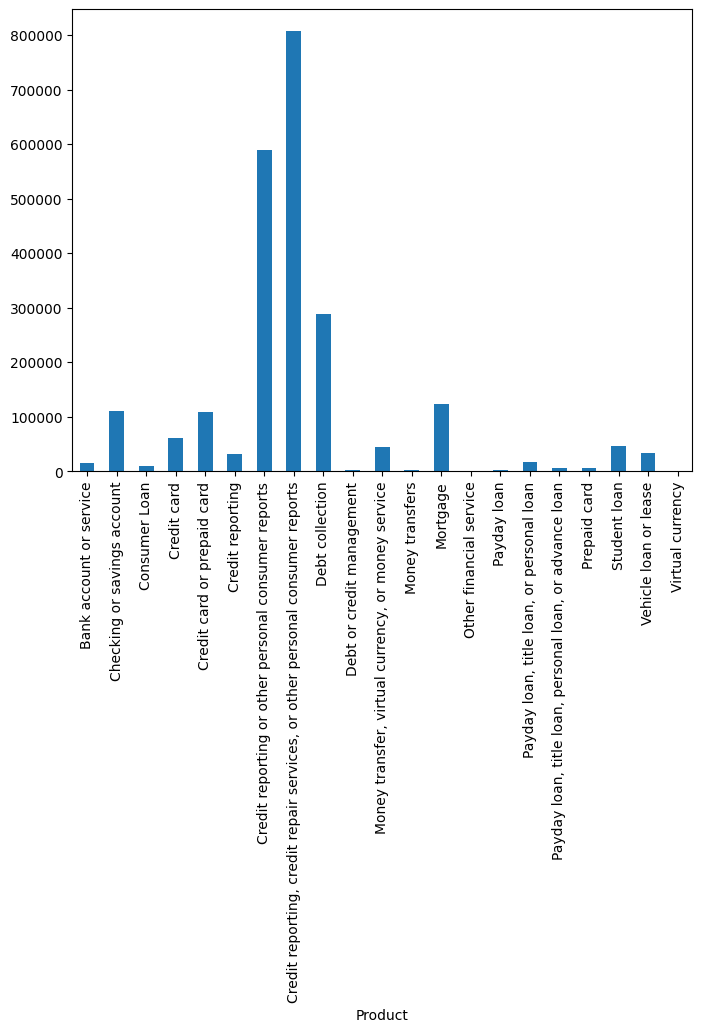

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(2301581, 2044242)

In [13]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . scottrade
       . citigold
  . Most correlated bigrams:
       . opened citigold
       . citigold checking
# 'Checking or savings account':
  . Most correlated unigrams:
       . funds
       . bank
  . Most correlated bigrams:
       . savings account
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . vehicle
       . car
  . Most correlated bigrams:
       . drive time
       . dealer services
# 'Credit card':
  . Most correlated unigrams:
       . overdue
       . card
  . Most correlated bigrams:
       . bureau start
       . want bureau
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . rewards
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . experian
       . equifax
  . Most correlated bigrams:
       . tax lien
       . disputed resolve
# 'Credit reportin

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [15]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [16]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [17]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

Product                       Consumer_complaint_narrative  \
89118  Debt collection  This company refuses to provide me verificatio...   

       category_id  
89118            0

In [18]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

Product                       Consumer_complaint_narrative  \
424  Credit reporting  I am disputing the inaccurate information the ...   

     category_id  
424            1

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

<ipython-input-21-72f014537037>:4: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='model_name', y='accuracy', data=cv_df,


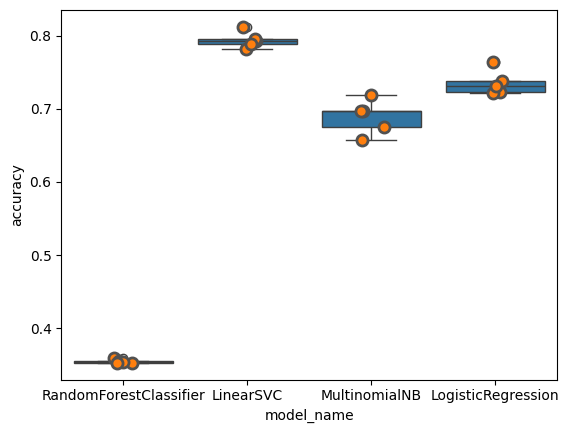

In [21]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [22]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.793982
LogisticRegression        0.735207
MultinomialNB             0.688621
RandomForestClassifier    0.354904
Name: accuracy, dtype: float64

In [23]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

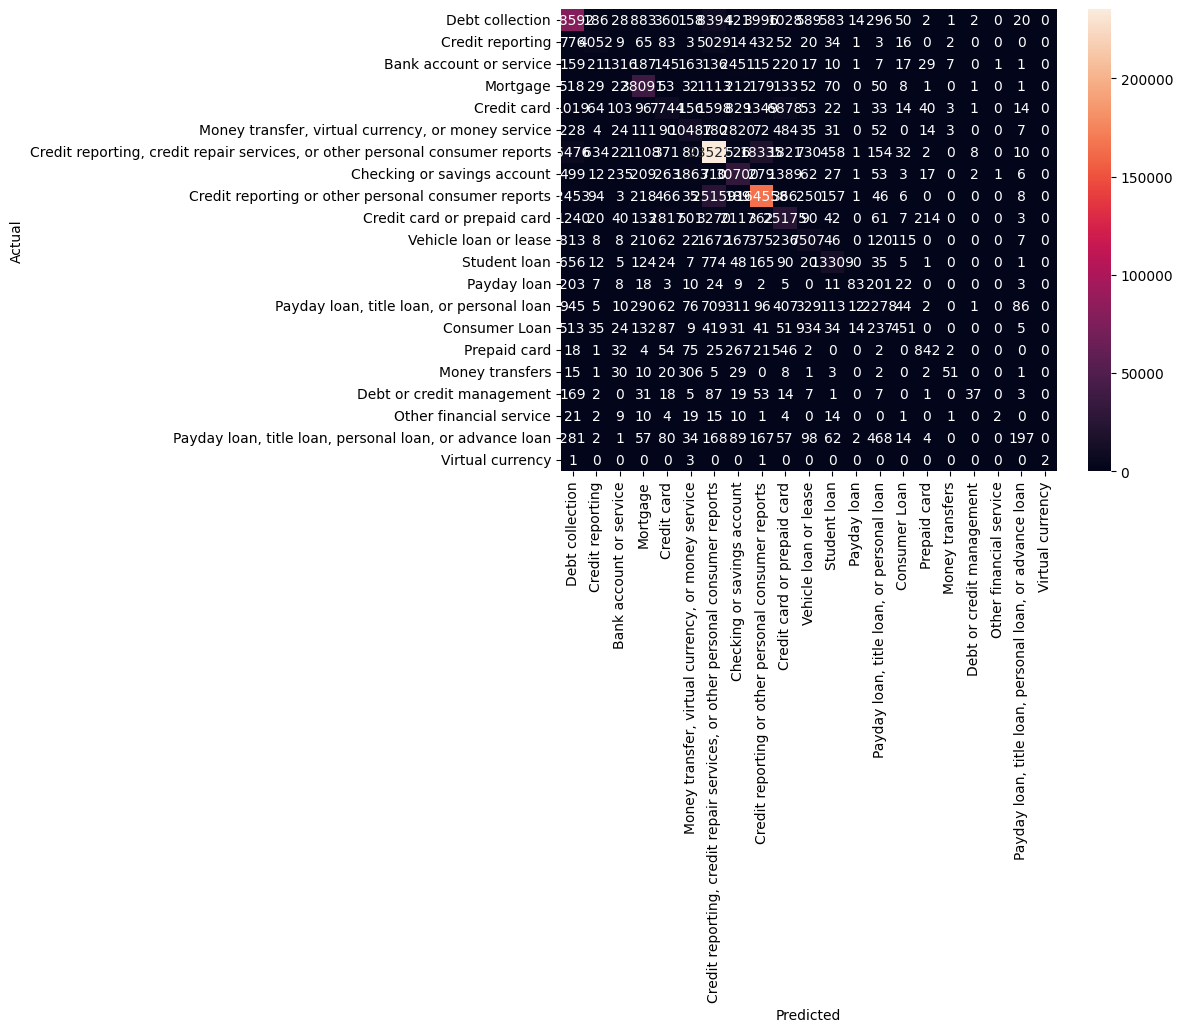

In [24]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Credit reporting' predicted as 'Debt collection' : 776 examples.


Product                       Consumer_complaint_narrative
6692149  Credit reporting  I do not owe a creditor having this name. \nTh...
6632756  Credit reporting  I 've been seeing an apartment for {$16000.00}...
4713044  Credit reporting  I have something on my credit report from Nati...
271314   Credit reporting  I was first made aware that I had an outstandi...
4572798  Credit reporting  Just stated account updated i didnt receive no...
...                   ...                                                ...
5367033  Credit reporting  This is a follow up to case Your submission, [...
175637   Credit reporting  I had a XXXX account in XXXX, XXXX that I clos...
6567670  Credit reporting  It shows on my credit that I have a {$75.00} b...
6670464  Credit reporting  I have multiple accounts on my credit report t...
6498643  Credit reporting  Upon checking my credit report I noticed I had...

[776 rows x 2 columns]


'Bank account or service' predicted as 'Debt collection' : 159 examples.


Product  \
6876794  Bank account or service   
6324776  Bank account or service   
4737156  Bank account or service   
4690970  Bank account or service   
6561554  Bank account or service   
...                          ...   
6467927  Bank account or service   
6693155  Bank account or service   
6464047  Bank account or service   
217887   Bank account or service   
6491118  Bank account or service   

                              Consumer_complaint_narrative  
6876794  I submitted a complaint to you ( case # XXXX )...  
6324776  I received a letter from Fifth Third Bank " Th...  
4737156  We finance a bed bought at XXXX in XXXX 2014. ...  
4690970  I had a delinquent loan with Navy Federal Cred...  
6561554  I want to create a situation to safely pass al...  
...                                                    ...  
6467927  I got divorced from my ex husband because he w...  
6693155  I received a letter from Citibank informing me...  
6464047  I spoke with XXXX XXXX form Bank America on XX...  
217887   I have a Health Savings Account that was levie...  
6491118  I was in search of information about BOA 's Pr...  

[159 rows x 2 columns]


'Mortgage' predicted as 'Debt collection' : 518 examples.


Product                       Consumer_complaint_narrative
5645871  Mortgage  I have disputed this account and have reached ...
5886560  Mortgage  XXXX wakefield and associates date again XX/XX...
6675680  Mortgage  i am a plaintiff in a pending lawsuit the basi...
4424020  Mortgage  COMPLAINT DIRECTED TO GMFS MORTGAGE XXXX, ITS ...
6808552  Mortgage        Sps collected debt not owed or already paid
...           ...                                                ...
4650617  Mortgage  In XX/XX/XXXX I got behind in my mortgage due ...
5410585  Mortgage  A third party dept collector has continued to ...
80670    Mortgage  Company will not refund surplus, have lied rep...
6511144  Mortgage  Wells Fargo continues to conceal from the Cons...
1893431  Mortgage  I have asked the company several times. Actual...

[518 rows x 2 columns]


'Credit card' predicted as 'Debt collection' : 1019 examples.


Product                       Consumer_complaint_narrative
1679999  Credit card  On XXXX a account was open without my permissi...
52659    Credit card  I settled both of my Capital One accounts with...
17553    Credit card  I have been contacted on numerous times by pho...
2158228  Credit card  on XX/XX/XXXX i received a call from a credit ...
961969   Credit card  Discover bank open a credit card in my name th...
...              ...                                                ...
1753531  Credit card  On XX/XX/XXXX I submitted CFPB complaint # XXX...
142417   Credit card  hsbc card I do not have ... seems to be identi...
2532053  Credit card  I filed an identity theft affidavit quite some...
1682155  Credit card  Contacted by the company debt collections mult...
1744598  Credit card  Received calls and emails from company during ...

[1019 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Debt collection' : 228 examples.


Product  \
4249363  Money transfer, virtual currency, or money ser...   
2286699  Money transfer, virtual currency, or money ser...   
4663320  Money transfer, virtual currency, or money ser...   
2043091  Money transfer, virtual currency, or money ser...   
4157344  Money transfer, virtual currency, or money ser...   
...                                                    ...   
1575958  Money transfer, virtual currency, or money ser...   
3805059  Money transfer, virtual currency, or money ser...   
6623244  Money transfer, virtual currency, or money ser...   
5050157  Money transfer, virtual currency, or money ser...   
6128312  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
4249363  I have requested PayPal to close additional ac...  
2286699  On XX/XX/XXXX I entered an agreement with Inla...  
4663320  I received a report of fraudulent activity on ...  
2043091   They said " investments are not their concern ''  
4157344  I want to thank you for giving me a chance to ...  
...                                                    ...  
1575958       They didn't give me the {$50.00} they owe me  
3805059  I have a balance around {$5000.00} with capita...  
6623244  PayPal is claiming that I owe an outstanding d...  
5050157  On XX/XX/XXXX I signed on with Freedom Debt Re...  
6128312  On XX/XX/XXXX a case was opened against me thr...  

[228 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 6476 examples.


Product  \
2745411  Credit reporting, credit repair services, or o...   
6464174  Credit reporting, credit repair services, or o...   
4500744  Credit reporting, credit repair services, or o...   
5829501  Credit reporting, credit repair services, or o...   
4801052  Credit reporting, credit repair services, or o...   
...                                                    ...   
3082162  Credit reporting, credit repair services, or o...   
6150169  Credit reporting, credit repair services, or o...   
4502697  Credit reporting, credit repair services, or o...   
6088616  Credit reporting, credit repair services, or o...   
213444   Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
2745411  NOTICE REQUEST FOR REINVESTIGATION RE : XXXX X...  
6464174  Commonwealth financial Systems debt amount is ...  
4500744  I already reached out to the credit bureaus an...  
5829501  A few months ago, I recieved an email saying t...  
4801052  I have tried contacting this company several t...  
...                                                    ...  
3082162  I am in the DO NOT CALL LIST. \nThe company CO...  
6150169  FIDELITY INFORMATION C Original creditor : XXX...  
4502697  I am reviewing my credit report and it shows a...  
6088616  I received the response from XXXX XXXX XXXX th...  
213444   I can find right place to post this. Your web ...  

[6476 rows x 2 columns]


'Checking or savings account' predicted as 'Debt collection' : 499 examples.


Product  \
4466918  Checking or savings account   
1202141  Checking or savings account   
5633930  Checking or savings account   
2849978  Checking or savings account   
357176   Checking or savings account   
...                              ...   
6414029  Checking or savings account   
415554   Checking or savings account   
3167503  Checking or savings account   
5271790  Checking or savings account   
2613968  Checking or savings account   

                              Consumer_complaint_narrative  
4466918  I filed a NOTICE OF INTENT TO FILE A PETITION ...  
1202141  Include dates, amounts, and actions that were ...  
5633930  Someone fraudulently opened a XXXX XXXX accoun...  
2849978  Price was marked at {$490.00} for a sale item ...  
357176   On XX/XX/2023 I received a phone from a woman ...  
...                                                    ...  
6414029  I have some weird harassing legal office calli...  
415554   After my bank was notified of the garnishment,...  
3167503  This is a follow-up complaint on a previously ...  
5271790  On XX/XX/2022 {$160.00} was withdrawn from my ...  
2613968  XX/XX/XXXX I sent a XXXX  payment of {$470.00}...  

[499 rows x 2 columns]


'Credit reporting or other personal consumer reports' predicted as 'Debt collection' : 2453 examples.


Product  \
853967   Credit reporting or other personal consumer re...   
2039637  Credit reporting or other personal consumer re...   
1454707  Credit reporting or other personal consumer re...   
735557   Credit reporting or other personal consumer re...   
2839938  Credit reporting or other personal consumer re...   
...                                                    ...   
2308636  Credit reporting or other personal consumer re...   
2006880  Credit reporting or other personal consumer re...   
3856060  Credit reporting or other personal consumer re...   
683358   Credit reporting or other personal consumer re...   
1199794  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
853967   I am writing to formally request validation of...  
2039637  I contacted the third-party company. Thats on ...  
1454707  XXXX XXXX XXXX I am unaware of the amount due ...  
735557   It was brought to my attention upon checking m...  
2839938  I moved out of a property that was run by loca...  
...                                                    ...  
2308636  Company Kickoff Lending LLc has placed a XXXX ...  
2006880  I have recently pulled my credit report and no...  
3856060  It's been longer then 30 days I did a debt val...  
683358   I declare under penalty of perjury ( under the...  
1199794  I am writing about the dispute of the charge o...  

[2453 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Debt collection' : 1240 examples.


Product  \
6308254  Credit card or prepaid card   
5572851  Credit card or prepaid card   
4431247  Credit card or prepaid card   
3813288  Credit card or prepaid card   
3361442  Credit card or prepaid card   
...                              ...   
3294889  Credit card or prepaid card   
3844163  Credit card or prepaid card   
5807565  Credit card or prepaid card   
5156497  Credit card or prepaid card   
3789539  Credit card or prepaid card   

                              Consumer_complaint_narrative  
6308254  I just found out in the month of XX/XX/XXXX th...  
5572851  My account has been delinquent for 90-120 days...  
4431247  On  XXXX   XXXX ,  XXXX  I contacted Citibank ...  
3813288  In regards to account number XXXX, I had consu...  
3361442  I have attempted several times to get this mat...  
...                                                    ...  
3294889  I paid my balance and accidentally over paid b...  
3844163  In XX/XX/XXXX I received a duplicate charge to...  
5807565  Received letter from Citigroup stating that th...  
5156497  Entered an agreement that required set amount ...  
3789539  XXXX, XXXX SOC SEC # XXXX DOB XX/XX/XXXX ADDRE...  

[1240 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Debt collection' : 813 examples.


Product  \
5913720  Vehicle loan or lease   
6599559  Vehicle loan or lease   
4756461  Vehicle loan or lease   
5897937  Vehicle loan or lease   
1441967  Vehicle loan or lease   
...                        ...   
5216095  Vehicle loan or lease   
5759010  Vehicle loan or lease   
5757023  Vehicle loan or lease   
3869259  Vehicle loan or lease   
6283569  Vehicle loan or lease   

                              Consumer_complaint_narrative  
5913720  To Whom It May Concern, This complaint is deal...  
6599559  XXXX XXXX, XXXX Dear FTC, Many months ago my l...  
4756461  I make my car payments to One Main Financial a...  
5897937  On XX/XX/2018 I sent a letter to XXXX XXXX XXX...  
1441967  On XX/XX/2024. I made XXXX payments to Southea...  
...                                                    ...  
5216095  Consumer Portfolio Services Inc. calls me more...  
5759010  Never received any bill for XXXX or XX/XX/2019...  
5757023  Harley-Davidson financial keeps harassing me a...  
3869259  I lost the vehicle in XXXX now its hard for me...  
6283569  My pay checks were being garnished in XXXX so ...  

[813 rows x 2 columns]


'Student loan' predicted as 'Debt collection' : 656 examples.


Product                       Consumer_complaint_narrative
5575951  Student loan       Im getting harassing phone calls about this.
4439640  Student loan  Account is reporting twice for the same accoun...
2066104  Student loan  Navient only calls me between XXXX and XXXX Mo...
1345746  Student loan  I have XXXX reenter a payment plan that I have...
6480406  Student loan  I am co signer on daughters loan and daughter ...
...               ...                                                ...
5930800  Student loan  XXXX XXXX refuses to tell me how they are comi...
5606171  Student loan  XXXX hired a third party debt collector for my...
6679182  Student loan  I enrolled using my GI Bill and somehow ended ...
6567033  Student loan  XXXX is the most recent loan servicer for our ...
6787241  Student loan  I received a letter from my employer today sta...

[656 rows x 2 columns]


'Payday loan' predicted as 'Debt collection' : 203 examples.


Product                       Consumer_complaint_narrative
4737705  Payday loan  Some place called ADR GROUP keeps calling hara...
156695   Payday loan  I am receiving threatening phone calls from a ...
6656749  Payday loan  I was charged {$89.00} over the actual first m...
6557026  Payday loan  I never took a loan from XXXX and someone from...
5629982  Payday loan  Lender is contacting my boyfriends mother, who...
...              ...                                                ...
62123    Payday loan  XX/XX/2012 my apartment was robbed. They stole...
6458318  Payday loan  Rapid cash I did n't have money when the check...
5262490  Payday loan  I 've applied a payday loan many years ago thr...
4582582  Payday loan  As we previously advised you, you have failed ...
6683406  Payday loan  National Credit Adjusters has contacted my fri...

[203 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 945 examples.


Product  \
5153246  Payday loan, title loan, or personal loan   
4212634  Payday loan, title loan, or personal loan   
4755257  Payday loan, title loan, or personal loan   
4508958  Payday loan, title loan, or personal loan   
5951180  Payday loan, title loan, or personal loan   
...                                            ...   
6636971  Payday loan, title loan, or personal loan   
3577178  Payday loan, title loan, or personal loan   
4624639  Payday loan, title loan, or personal loan   
5764125  Payday loan, title loan, or personal loan   
6319855  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
5153246  My husband, who I am separated from, took out ...  
4212634  Charged me {$90.00} for a returned check fee. ...  
4755257  XX/XX/XXXX received call from a ace collection...  
4508958  I have had my Conn 's installment loan for 3 y...  
5951180  I received flyer in mail I called about loan. ...  
...                                                    ...  
6636971  Wells Fargo refused to honor a check, written ...  
3577178  We have repeatedly told XXXX at the telegraph ...  
4624639  I unfortunately pulled amount a 2 loans to pay...  
5764125  On XX/XX/18 husband and I signed up for a vaca...  
6319855  I was notified of this account when it showed ...  

[945 rows x 2 columns]


'Consumer Loan' predicted as 'Debt collection' : 513 examples.


Product                       Consumer_complaint_narrative
6649432  Consumer Loan  Nonstop calls. I probably receive 3-5 calls a ...
5580303  Consumer Loan  I receive multiple calls from USAA for someone...
224335   Consumer Loan  I had XXXX medical bills that were extremely h...
268432   Consumer Loan  XXXX has continued to report a judgment on my ...
6646904  Consumer Loan  Timeline of Events Tuesday, XX/XX/2017 : My da...
...                ...                                                ...
5588801  Consumer Loan  I have a loan that is to be paid back in month...
166776   Consumer Loan  The company continuously calls my family and f...
6665873  Consumer Loan  I have an auto loan with PFS financial XXXX. M...
170538   Consumer Loan  On my credit reports with XXXX, XXXX, and XXXX...
6389560  Consumer Loan  This bill was disputed years ago.. All XXXX cr...

[513 rows x 2 columns]


'Prepaid card' predicted as 'Debt collection' : 18 examples.


Product                       Consumer_complaint_narrative
6651914  Prepaid card  Did not authorize the account and customer ser...
1633072  Prepaid card  I would like the monetary funds of {$9000.00} ...
1623067  Prepaid card  Dear Management Center, Due to bad service and...
985569   Prepaid card  I received a {$25.00} gift card from my work. ...
5399354  Prepaid card  I recieved my actual paycheck after my origina...
2607170  Prepaid card  I had ordered a product from this website and ...
877508   Prepaid card  I did not receive the right amount of funds th...
906638   Prepaid card  I revived an email from a company called net s...
2599818  Prepaid card  On XXXX XXXX I noticed that {$770.00} was paid...
1707698  Prepaid card  Rapid Cash had took there payment, Which I was...
3462912  Prepaid card    illegal conduct doing covid-19 pandemic us bank
321575   Prepaid card  i have already files a complaint and got the r...
804900   Prepaid card  I have disputed this company and it's party of...
2073535  Prepaid card  Attempts to collect debt not owed ( debt was p...
3541325  Prepaid card  I received letter XXXX from company today date...
1150845  Prepaid card  When is this bank going to be done XXXX  XXXX ...
1356294  Prepaid card  I received a gift card for XXXX from my mother...
786905   Prepaid card  Its been almost 2 years Bank of America sent m...


'Money transfers' predicted as 'Debt collection' : 15 examples.


Product                       Consumer_complaint_narrative
6659561  Money transfers  I opened a PayPal account XX/XX/XXXX for an eB...
61514    Money transfers  Wanted to buy a XXXX puppy. Found one from XXX...
6648819  Money transfers  I sold a couch for {$190.00} and received paym...
6476955  Money transfers  On XXXX XXXX, 2015 Recieved a call @ XXXX XXXX...
52615    Money transfers  XXXX, now operating under the umbrella of XXXX...
6675722  Money transfers  I was befriended by XXXX from XXXX and over th...
6505911  Money transfers  Addendum to CFPB Case # XXXX : A Fraudster use...
5561085  Money transfers  I received a phone call from XXXX stating that...
57809    Money transfers  OK hope this works this time. Been looking for...
238441   Money transfers  I received a phone call at XXXX on Thursday XX...
4646020  Money transfers  Vicitms of Fraud. We received a phone call tha...
173734   Money transfers  Finances wired to bank account of XXXX XXXX XX...
6365825  Money transfers  Advertized Restaurant for Sale. Engaged with p...
88924    Money transfers  I was told by a person claiming to be XXXX XXX...
6681932  Money transfers  For years I 've never had a problem paying big...


'Debt or credit management' predicted as 'Debt collection' : 169 examples.


Product  \
3323564  Debt or credit management   
1076641  Debt or credit management   
3608935  Debt or credit management   
2740521  Debt or credit management   
3463911  Debt or credit management   
...                            ...   
1923666  Debt or credit management   
3204295  Debt or credit management   
2302354  Debt or credit management   
1554240  Debt or credit management   
2697246  Debt or credit management   

                              Consumer_complaint_narrative  
3323564  That my account is original I know them and it...  
1076641  the balances were much lower before they went ...  
3608935  I saw these XXXX accounts on my credit report....  
2740521  XXXX open a new account when I move to a new a...  
3463911  I called a number which I thought was a debt c...  
...                                                    ...  
1923666  Diverse adjustments I have not ever dealt with...  
3204295  MIDLAND CREDIT MANAGEMENT I settled a {$510.00...  
2302354  In XXXX, XXXX, XXXX. I XXXX XXXX XXXX has been...  
1554240  I have been in the debt relief process for abo...  
2697246  My original mortgage lender was XXXXXXXX XXXX ...  

[169 rows x 2 columns]


'Other financial service' predicted as 'Debt collection' : 21 examples.


Product  \
141025   Other financial service   
6488604  Other financial service   
85095    Other financial service   
6448609  Other financial service   
6844992  Other financial service   
6677092  Other financial service   
5609445  Other financial service   
6671892  Other financial service   
6663297  Other financial service   
1982799  Other financial service   
68348    Other financial service   
49638    Other financial service   
6578240  Other financial service   
6573585  Other financial service   
6363397  Other financial service   
5288422  Other financial service   
27033    Other financial service   
3580347  Other financial service   
6477050  Other financial service   
6657204  Other financial service   
6427216  Other financial service   

                              Consumer_complaint_narrative  
141025   when making a purchase at XXXX in XXXX nj, I w...  
6488604  I was contacted by a representative and was to...  
85095    Global Client Solutions accepted a total of {$...  
6448609  I paid Global Client Solutions to help me with...  
6844992  We had a lot of debt with credit cards etc and...  
6677092  I have a bad experience to DMB financial credi...  
5609445  The American Student Services has taken owners...  
6671892  I attempted to exchange euros to dollars at th...  
6663297  Received a letter in mail written XXXX XXXX re...  
1982799  On XXXX XXXX I called Apple Law firm to help m...  
68348    the company promised to combine my debts for i...  
49638    Dear Consumer Financial Protection Bureau : ( ...  
6578240  I started their program in XXXX of 2012. I bel...  
6573585  Beginning In XXXX of 2010, Global Client Solut...  
6363397  Returning to the XXXX I exchanged XXXX at the ...  
5288422  I 've been receiving calls from a payday loan ...  
27033    I went into an agreement with Global Client So...  
3580347  Nicholes Financial Inc is reporting a Charged ...  
6477050  The cashier named XXXX XXXX, working in the Ch...  
6657204  I contacted Clear One Advantage XX/XX/2016, I ...  
6427216  Back in XXXX of XXXX I had credit card debt. I...


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Debt collection' : 281 examples.


Product  \
825220   Payday loan, title loan, personal loan, or adv...   
1002036  Payday loan, title loan, personal loan, or adv...   
2355203  Payday loan, title loan, personal loan, or adv...   
1715489  Payday loan, title loan, personal loan, or adv...   
1271402  Payday loan, title loan, personal loan, or adv...   
...                                                    ...   
647354   Payday loan, title loan, personal loan, or adv...   
2841709  Payday loan, title loan, personal loan, or adv...   
986524   Payday loan, title loan, personal loan, or adv...   
875910   Payday loan, title loan, personal loan, or adv...   
1017738  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
825220   I closed and deleted my account with empower a...  
1002036  They are calling me three times a day almost e...  
2355203  I am writing to address a matter of concern re...  
1715489  We paid off our loan balance in XXXX and the c...  
1271402  This Company reported I that I have Paid in fu...  
...                                                    ...  
647354   There are numerous issues with this company. I...  
2841709  Orginaly I recieved a personal loan from my ba...  
986524   It is XXXX XXXX XXXX on XX/XX/year> as I write...  
875910   No one is listening to my proposal to resolvin...  
1017738  I applied for financing through XXXX XXXX  ( X...  

[281 rows x 2 columns]


'Debt collection' predicted as 'Credit reporting' : 186 examples.


Product                       Consumer_complaint_narrative
5769382  Debt collection  I have some follow up information on a collect...
267780   Debt collection  I was involved in a real estate investment ove...
306307   Debt collection  Last year Account Services started reporting s...
5899218  Debt collection  There is an open collection account on my cred...
5869701  Debt collection  I am periodically receiving harassing telephon...
...                  ...                                                ...
2902140  Debt collection  received a letter asking me to provide my taxp...
6384267  Debt collection  I have had a collection reappearing on my cred...
5841868  Debt collection  XXXX XXXX XXXX is trying to state that I was o...
3187992  Debt collection  XXXX still reports this XXXX  t after more tha...
321691   Debt collection  Due to the fact that my situation is not prope...

[186 rows x 2 columns]


'Bank account or service' predicted as 'Credit reporting' : 21 examples.


Product  \
10318    Bank account or service   
5449325  Bank account or service   
6665042  Bank account or service   
6650058  Bank account or service   
6448871  Bank account or service   
211829   Bank account or service   
5377754  Bank account or service   
6651284  Bank account or service   
43293    Bank account or service   
6229185  Bank account or service   
5279313  Bank account or service   
1134602  Bank account or service   
5265474  Bank account or service   
6678609  Bank account or service   
5640137  Bank account or service   
6681150  Bank account or service   
240967   Bank account or service   
263359   Bank account or service   
267081   Bank account or service   
6459085  Bank account or service   
6653355  Bank account or service   

                              Consumer_complaint_narrative  
10318    My wife XXXX away in XXXX and had a credit car...  
5449325  On XXXX XXXX, I attempted to open an account w...  
6665042  This is a follow up, with additional informati...  
6650058  www.socialsecurity.gov Attn XXXX XXXX XXXX XXX...  
6448871  I received a XXXX day late notice on my credit...  
211829   In XXXX / XXXX of XXXX, I began to have paymen...  
5377754  in XXXX 2015 i bought an item from amazon, {$1...  
6651284  hsbc needs to clear this off my cr report, thi...  
43293    1ST NATIONAL BANK OF OMAHA XXXX XXXX XXXX XXXX...  
6229185  I tried to apply for a loan online. I was redi...  
5279313  Tried to open up an account with XXXX differen...  
1134602  I have had an account with NetSpend Debit for ...  
5265474  Wells Fargo is still sending me letters saying...  
6678609  I filed a complaint with your agency, Case No....  
5640137  On XXXX/XXXX/2015 I applied online to open a S...  
6681150  I reported a fraud claim to US BANK on XXXX/XX...  
240967   I am disputing a transaction ( please see belo...  
263359   I applied for a credit card, The representativ...  
267081   You are inaccurately and incompletely furnishi...  
6459085  I am a victim of identity theft. Several years...  
6653355  ON XXXX I WAS CHARGE {$14.00} FOR A FREE MOVIE...


'Mortgage' predicted as 'Credit reporting' : 29 examples.


Product                       Consumer_complaint_narrative
1741139  Mortgage  PNC Bank sent me a letter stating that my acco...
6553199  Mortgage  XXXX/XXXX/XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
303380   Mortgage  I had a home equity line of credit on my perso...
6693260  Mortgage  Experian refused to validate and verify a debt...
6470005  Mortgage  requested credit report from XXXX on XXXX/XXXX...
6457973  Mortgage  Bank of American is actively reporting foreclo...
1873371  Mortgage  I was asked ( as I was leaving the branch ) to...
6357574  Mortgage  I am looking at my credit report and saw an in...
18983    Mortgage  I bought a house with the lender Security Nati...
2639716  Mortgage  Per the answer in complaint XXXX I never reque...
6455458  Mortgage  I have banked with Navy Federal Credit Union f...
6684480  Mortgage  I have been with Selene Finance for a year or ...
128428   Mortgage  Several disputes have been sent in regarding m...
1626114  Mortgage  I send payments to this company in certified c...
5447813  Mortgage  A copy of credit reports were received in XXXX...
5255655  Mortgage  I had a short sale back in 2009 which was nego...
3190087  Mortgage  Your format does not work for me. I have an XX...
4231211  Mortgage  See attached letter to State of Maine which ad...
5931841  Mortgage  On XXXX at roughly XXXX CST, I attempted to vi...
4617178  Mortgage  In  2011  the said company,  XXXX , failed to ...
205038   Mortgage  I secured a mortgage in XX/XX/XXXX through a X...
321091   Mortgage  According to the Fair Credit Reporting Act, Na...
6571107  Mortgage  The original debt and lien was created by XXXX...
218308   Mortgage  Realtime Resolutions is reporting a loan that ...
6683221  Mortgage  After finding additional information, I 'd lik...
6659920  Mortgage  In XXXX XXXX, 2007 I filed bankruptcy and incl...
9939     Mortgage  I had a property in XXXX, Oregon with a mortga...
6626724  Mortgage  I went through a foreclosure with WellsFargo, ...
175001   Mortgage  This issue was reported with cfpb on Case numb...


'Credit card' predicted as 'Credit reporting' : 64 examples.


Product                       Consumer_complaint_narrative
378003   Credit card  I'm a XXXX traveler who open credit cards at a...
168302   Credit card  Under 623-15 U.S.C. 1681s, Section 623 ( a ) (...
6694556  Credit card  XXXX & XXXX 2016 Over Limit Reported To XXXX C...
5394559  Credit card  On XXXX XXXX, 2015, I disputed whether the acc...
6246473  Credit card  XXXX XXXX, 2016 XXXX ran my credit report with...
...              ...                                                ...
358773   Credit card  for XXXX entered into an agreement to combined...
6457266  Credit card  The issue is that Equifax Credit Bureau seems ...
6696512  Credit card  I have recently become aware that I am a victi...
2045352  Credit card  OLD NATIONAL BANK XXXX BEEN OPEN SINCE XXXX AC...
6473789  Credit card  I have been paying HHGregg through Sychony XXX...

[64 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 634 examples.


Product  \
5310944  Credit reporting, credit repair services, or o...   
5851558  Credit reporting, credit repair services, or o...   
4893349  Credit reporting, credit repair services, or o...   
6481770  Credit reporting, credit repair services, or o...   
6149165  Credit reporting, credit repair services, or o...   
...                                                    ...   
3596770  Credit reporting, credit repair services, or o...   
6140456  Credit reporting, credit repair services, or o...   
5561005  Credit reporting, credit repair services, or o...   
6443583  Credit reporting, credit repair services, or o...   
6803876  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
5310944  I am filing this complaint because the Credit ...  
5851558  The name XXXX XXXX was added to my Equifax cre...  
4893349  why do they no report paid on time but if you ...  
6481770  I've lived in XXXX, Virginia for 26 years I pu...  
6149165  I was part of the data beach with Equifax. I w...  
...                                                    ...  
3596770  I have been trying to open a credit card throu...  
6140456  I applied to XXXX XXXX to apply for downpaymen...  
5561005  After paying Experian 's website a fee and ans...  
6443583  There is a withdrawn Federal tax lien still sh...  
6803876  Hello- After looking at my bank statements in ...  

[634 rows x 2 columns]


'Checking or savings account' predicted as 'Credit reporting' : 12 examples.


Product  \
4483233  Checking or savings account   
1060701  Checking or savings account   
2710910  Checking or savings account   
4689059  Checking or savings account   
4617490  Checking or savings account   
6276459  Checking or savings account   
5676094  Checking or savings account   
3537159  Checking or savings account   
6605933  Checking or savings account   
6586205  Checking or savings account   
5386821  Checking or savings account   
1176468  Checking or savings account   

                              Consumer_complaint_narrative  
4483233     My account was hacked in 2010 like most others  
1060701  Someone without my knowledge used my identific...  
2710910  I WAS XXXX XX/XX/2015 ON A XXXX XXXX XXXX BY C...  
4689059  I AM A VICTIM OF IDENTITY THEFT SINCE XXXX AND...  
4617490  I have paid an account that was closed due to ...  
6276459  My son has had a savings account with the XXXX...  
5676094  Early Warning Failed to supply sufficient evid...  
3537159  ItriedforTHREEhourstobookaflightandpayviadebit...  
6605933  My last XXXX banks someone has been able to st...  
6586205    They wo n't let me access my money through XXXX  
5386821  Applied for checking account already having XX...  
1176468  THEY CLOSED THE ACCOUNT AND DID NOT GIVE ME MY...


'Credit reporting or other personal consumer reports' predicted as 'Credit reporting' : 94 examples.


Product  \
2399634  Credit reporting or other personal consumer re...   
1241551  Credit reporting or other personal consumer re...   
2396251  Credit reporting or other personal consumer re...   
1515930  Credit reporting or other personal consumer re...   
1443149  Credit reporting or other personal consumer re...   
...                                                    ...   
1447006  Credit reporting or other personal consumer re...   
2314684  Credit reporting or other personal consumer re...   
2606649  Credit reporting or other personal consumer re...   
2840997  Credit reporting or other personal consumer re...   
335997   Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
2399634  I am unable to obtain my Transunion credit rep...  
1241551  Transunion is reporting an old account from XX...  
2396251  APPLIED FOR AN XXXX XXXX XXXX CREDIT CARD. XXX...  
1515930  XXXX notified me of a XXXX credit card applica...  
1443149  I previously disputed with Experian directly a...  
...                                                    ...  
1447006  Representative states they never sent out a le...  
2314684  On XX/XX/2024, I reviewed my posted credit sco...  
2606649  I submitted a request to have some unauthorize...  
2840997  Equifax will not allow lenders to access my cr...  
335997   I found XXXX accounts on my credit report that...  

[94 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Credit reporting' : 20 examples.


Product  \
6223303  Credit card or prepaid card   
6869459  Credit card or prepaid card   
6325144  Credit card or prepaid card   
6225282  Credit card or prepaid card   
5829391  Credit card or prepaid card   
5678754  Credit card or prepaid card   
2765555  Credit card or prepaid card   
4654802  Credit card or prepaid card   
3893527  Credit card or prepaid card   
6579722  Credit card or prepaid card   
123630   Credit card or prepaid card   
3791840  Credit card or prepaid card   
27048    Credit card or prepaid card   
5127871  Credit card or prepaid card   
4927751  Credit card or prepaid card   
2917804  Credit card or prepaid card   
4316391  Credit card or prepaid card   
5057998  Credit card or prepaid card   
3495545  Credit card or prepaid card   
3431989  Credit card or prepaid card   

                              Consumer_complaint_narrative  
6223303  Equifax credit leak, I submitted a form on the...  
6869459  I payed in full. Then I received a bill for ad...  
6325144  I paid the full amount of this account off whi...  
6225282  I applied for a job and the employer did a bac...  
5829391  There are two delinquent accounts currently ap...  
5678754  XXXX closed my ac after being paid off and ful...  
2765555  I get an online statement and I did not receiv...  
4654802  My cell phone broke credit karma did not recog...  
3893527  I had no clue about this account until I check...  
6579722  Denied credit for dubious reasons : " Derogato...  
123630   On XXXX/XXXX/16 I did a transfer of XXXX from ...  
3791840  I ws looking at my account and a see the minum...  
27048    On XXXX XXXX,2016 a hard hit inquiry was place...  
5127871  XXXX XXXX is illegally reporting Late Payments...  
4927751  I had this account in 2008 it keeps updating. ...  
2917804  saw XXXX  charge in pending transactions. Was ...  
4316391  I applied for a credit card from First Nationa...  
5057998  i have a complain on here like 6 mths ago bout...  
3495545  I closed my XXXX 's Card back in XXXX of 2008....  
3431989  Hello. \n\nThe Florida Attorney General 's Off...


'Vehicle loan or lease' predicted as 'Credit reporting' : 8 examples.


Product  \
3485212  Vehicle loan or lease   
6412122  Vehicle loan or lease   
2478097  Vehicle loan or lease   
6612429  Vehicle loan or lease   
4746541  Vehicle loan or lease   
2563469  Vehicle loan or lease   
6488751  Vehicle loan or lease   
2358263  Vehicle loan or lease   

                              Consumer_complaint_narrative  
3485212  Please help me if its charged off all these ye...  
6412122  I paid my truck off in one lump sum on XXXX XX...  
2478097  Purchased XXXX new snowmobiles in XXXX from Po...  
6612429  Account is paid and satified and would like th...  
4746541  I am the co-applicant of a vehicle purchased. ...  
2563469  Mystery 30 day late. I've always paid on time....  
6488751  We were making payments as agreed  with GM Fin...  
2358263  This item is being reported on my consumer rep...


'Student loan' predicted as 'Credit reporting' : 12 examples.


Product                       Consumer_complaint_narrative
6667238  Student loan  I am writing to dispute the following informat...
6219763  Student loan  I have 2 Federal Student loans that are showin...
4681200  Student loan        Would like a XXXX or less Per month payment
6664682  Student loan  I have paid off the student loans in 2015 and ...
324982   Student loan  XXXX accounts ending in xxxx and xxxx, have in...
6429578  Student loan  Account duplicated multiple times. \nDepartmen...
6449993  Student loan  I consolidated my student loan in XXXX 2013.Or...
6689901  Student loan  XXXX loans were closed and moved to XXXX, on X...
6076118  Student loan  I had a credit score and was alway paying my b...
4645589  Student loan  NAVIENT is in direct violation of my rights un...
6665712  Student loan  XXXX credit reporting service reduced my credi...
1258700  Student loan  private XXXX XXXX. \n\nCo-signed with XXXX XXX...


'Payday loan' predicted as 'Credit reporting' : 7 examples.


Product                       Consumer_complaint_narrative
6657743  Payday loan  I am a victim of identity theft and someone st...
4410154  Payday loan  On XXXX XXXX, 2015 I initiated an online payda...
6311922  Payday loan  I set up payment to come directly from my payr...
300597   Payday loan  i had no knowledge of this account. Payday loa...
5256538  Payday loan  On Monday XXXX XXXX, 2016, I received an alert...
6514518  Payday loan  I have sent a copy of my old bank statement sh...
4625478  Payday loan  My identity was stolen in XX/XX/2009. A XXXX X...


'Consumer Loan' predicted as 'Credit reporting' : 35 examples.


Product                       Consumer_complaint_narrative
5532178  Consumer Loan  I closed an account with Delbert Services ( DB...
87986    Consumer Loan  Santander Bank Incorrectly stated late by thir...
6659434  Consumer Loan  My student loans where all consolidated into X...
6483596  Consumer Loan  Hello! \nMy daughter and I have a vehicle leas...
149774   Consumer Loan  This letter is a follow up to my original lett...
193038   Consumer Loan  On XXXX XXXX 2016, I received an online offer ...
6631695  Consumer Loan  SPRINGLEAF AGREED TO REMOVE THEMSELVES FROM MY...
6430314  Consumer Loan  An Auto loan was opened in my name with Gatewa...
281693   Consumer Loan  I sent a letter to ONE MAIN FINANCIAL regardin...
6468443  Consumer Loan  Since I have not been able to pay the Loan thi...
49608    Consumer Loan  On XXXX, I filed an dispute with Westlake Fina...
6653360  Consumer Loan  My complaint is with Experian, XXXX and XXXX a...
6677681  Consumer Loan  You have Ally bank listed twice on XXXX/XXXX/2...
4771383  Consumer Loan  Dear Sir or Madam : We are writing to dispute ...
4624055  Consumer Loan  I have a collection for {$20.00} that was paid...
6681663  Consumer Loan  XXXX/XXXX/2015 - Terminated my lease early bec...
156640   Consumer Loan  I am filing this complaint against TD Auto Fin...
6495989  Consumer Loan  BMW Financial Services continues to report my ...
88458    Consumer Loan  This duplicate case is in reference to complai...
6510954  Consumer Loan  Inaccurate information is being reported to XX...
4915946  Consumer Loan  CAN AFFES CHARGE US XXXX PAYMENT ON A PAYMENT ...
142014   Consumer Loan  XXXX XXXX XXXX XXXX XXXX XXXX XXXX VA XXXX dob...
6613051  Consumer Loan  Enclosed are detailed transactions for my Infi...
6645896  Consumer Loan  For about XXXX6 years I have had multiple acco...
5610356  Consumer Loan  One of the reasons given for denial for a home...
214196   Consumer Loan  XXXX/XXXX/XXXX GM FINANCIAL ACC # XXXX Late Da...
5766752  Consumer Loan  I RECENTLY CHECKED MY CREDIT AND NOTICED A MER...
245994   Consumer Loan  I recently received a copy of my XXXX credit r...
6364126  Consumer Loan  Completed chapter XXXX everything still remain...
6458196  Consumer Loan  Statue of limitations expired in 2011 with ori...
6448392  Consumer Loan  The creditor Pentagon Federal Credit Union ( a...
240150   Consumer Loan  In XXXX 2015, I disputed an auto loan with Fir...
63091    Consumer Loan  I got a car loan with Santander on XX/XX/2016 ...
153730   Consumer Loan  I recently received a copy of my XXXX credit r...
47226    Consumer Loan  In XXXX of 2016 my wallet was stolen. I filed ...


'Debt collection' predicted as 'Bank account or service' : 28 examples.


Product                       Consumer_complaint_narrative
6355807  Debt collection  Dear States Attorney, I 've taken during the p...
234798   Debt collection  In regard to the EFTA ( Electronic Funds Trans...
152227   Debt collection  I was told that I would receive compensation f...
6643640  Debt collection  The debt was forgiven by the bank. \n\nThe acc...
2413054  Debt collection  During XXXX and XX/XX/XXXX, and XX/XX/XXXX, I ...
6631920  Debt collection  I recently filed a complaint against,  XXXX   ...
3837197  Debt collection  In  XXXX , I fell behind on both my signature ...
6281880  Debt collection  A personal representative from that company vi...
6612950  Debt collection  Wells Fargo Bank made an unauthorized draft ag...
6459904  Debt collection  Im in the process of cleaning up my XXXX credi...
5733258  Debt collection  On XX/XX/XXXX, I received a called from the Pe...
3585711  Debt collection  This is the third complaint written against th...
5115130  Debt collection  On XX/XX/XXXX Wells Fargo Bank took {$15000.00...
1947780  Debt collection  This matter is from my XXXX XXXX car insurance...
6447758  Debt collection  I never have account with this company which X...
6444663  Debt collection  Bank Of America withdrew funds from my account...
6455832  Debt collection  I had previously been making payments to clear...
285253   Debt collection  HSBC has been a horrible lender and they have ...
6447828  Debt collection  Weltman , Weinberg & Reis Co. of XXXX Ohio rec...
5574540  Debt collection  RE : XXXX On XX/XX/XXXX my corporation was sol...
145034   Debt collection  Wells Fargo is allowing someone named XXXX XXX...
298801   Debt collection  To the Consumer Financial Protection Bureau, I...
16482    Debt collection  A XXXX XXXX XXXX of US Bank XXXX XXXX XXXX on ...
80989    Debt collection  I signed a check to XXXX when married to my ex...
5231263  Debt collection  Synchrony bank keeps relentlessly sending me e...
6658877  Debt collection  XXXX 2014 I received XXXX checks in the amount...
211036   Debt collection  a check was mailed out on XX/XX/2015 with my o...
6696378  Debt collection  Ebay floods inboxes with offers to " sell for ...


'Credit reporting' predicted as 'Bank account or service' : 9 examples.


Product                       Consumer_complaint_narrative
6449526  Credit reporting  I have attempted several times to correct XXXX...
31014    Credit reporting  I was CLOSING my XXXX checking account in XXXX...
4749121  Credit reporting  The company is reporting my score too low and ...
6377802  Credit reporting  I contacted XXXX back in XXXX 2016 about possi...
6877419  Credit reporting  My complaint is with Telecheck and TRS ( their...
6662030  Credit reporting  I 've always had a rep payee and they have alw...
195983   Credit reporting  I am being charged for a money order from the ...
6693509  Credit reporting  I went to the bank to open an account and was ...
5342173  Credit reporting  This company XXXX shows I have an open account...


'Mortgage' predicted as 'Bank account or service' : 22 examples.


Product                       Consumer_complaint_narrative
257870   Mortgage  On XXXX/XXXX/2015, I scheduled a XXXX time dra...
5567615  Mortgage  XXXX XXXX XXXX I submitted a payment for the l...
6239446  Mortgage  We formed XXXX corporations for the purchase o...
107452   Mortgage  I have an equity line of credit with Huntingto...
4900902  Mortgage  I have taken a loan from bank of America for {...
6460020  Mortgage  I PAID .WELLS FARGO BANK OF XXXX IL. XXXX XXXX...
6458741  Mortgage  BBT once again is overcharging my escrows acco...
86524    Mortgage  chase bank sends individuals over to my house ...
232947   Mortgage  Bank of America sold my account in XXXX 2016. ...
6488929  Mortgage  Today 's Date : XXXX/XXXX/2015 On XXXX/XXXX/15...
6231520  Mortgage  In XXXX BOA offered me an incentive under the ...
4629750  Mortgage  On or about XXXX XXXX, XXXX I received a bill ...
6448864  Mortgage  On XXXX XXXX, XX/XX/2015 I sent a letter infor...
21474    Mortgage  I paid off my equity loan and ask the bank emp...
1273983  Mortgage  Wells Fargo : 1 ) Advised me to borrow {$75000...
76019    Mortgage  Wells Fargo has again withdrawn money from our...
1616778  Mortgage  On XX/XX/XXXX  my husband proceeded to a local...
5363546  Mortgage  I wrote a {$100000.00} check against my HELOC,...
6476950  Mortgage  XXXX XXXX added fees to my account that were e...
5894318  Mortgage  My husband and I had a home equity loan from S...
50009    Mortgage  This is an additional complaint to the previou...
5367221  Mortgage  I was approved for a trial loan modification o...


'Credit card' predicted as 'Bank account or service' : 103 examples.


Product                       Consumer_complaint_narrative
6471189  Credit card  I have submitted a complaint against Citibank ...
105500   Credit card  My debit card was lost and fraudulently used t...
74923    Credit card  VISA credit card through Bank Of America -- --...
6490061  Credit card  I am a divorced woman that returned to school ...
119028   Credit card  I 've had a FIA XXXX Credit Card since XXXX. I...
...              ...                                                ...
113565   Credit card  About 6 month ago I applied for a secured Cred...
6463609  Credit card  I made an electronic payment to Chase Cardmemb...
6476703  Credit card  Capital One bank took money out of my account ...
104510   Credit card  My credit card at Santander Bank was used by s...
2487967  Credit card  PNC bank is not responsive to customer service...

[103 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 24 examples.


Product  \
5954155  Money transfer, virtual currency, or money ser...   
6418059  Money transfer, virtual currency, or money ser...   
6024772  Money transfer, virtual currency, or money ser...   
6558589  Money transfer, virtual currency, or money ser...   
6581632  Money transfer, virtual currency, or money ser...   
5900619  Money transfer, virtual currency, or money ser...   
2489226  Money transfer, virtual currency, or money ser...   
6366161  Money transfer, virtual currency, or money ser...   
181811   Money transfer, virtual currency, or money ser...   
6631394  Money transfer, virtual currency, or money ser...   
193831   Money transfer, virtual currency, or money ser...   
5595864  Money transfer, virtual currency, or money ser...   
2447195  Money transfer, virtual currency, or money ser...   
150629   Money transfer, virtual currency, or money ser...   
3506049  Money transfer, virtual currency, or money ser...   
6290872  Money transfer, virtual currency, or money ser...   
4933928  Money transfer, virtual currency, or money ser...   
6625427  Money transfer, virtual currency, or money ser...   
5920492  Money transfer, virtual currency, or money ser...   
5440402  Money transfer, virtual currency, or money ser...   
4741738  Money transfer, virtual currency, or money ser...   
2581933  Money transfer, virtual currency, or money ser...   
5570320  Money transfer, virtual currency, or money ser...   
5871706  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
5954155  On XX/XX/XXXX a {$50.00} bill was taken from m...  
6418059  I went in to Bank of America in  XXXX   XXXX  ...  
6024772  Paypal closed my account with XXXX in it for n...  
6558589  I have been disputing an unauthorized bank mon...  
6581632  A prospective client found me on my website. H...  
5900619  I lost or had my cashiers check stolen on or a...  
2489226  I did not receive a expected deposit. I was to...  
6366161  I have two accounts with XXXX XXXX XXXX. \n\nS...  
181811   My former neighbor and business XXXX XXXX XXXX...  
6631394  I wired  XXXX  {$100000.00} transfers to an in...  
193831   I have had a Wells Fargo checking account sinc...  
5595864  My husband tried to wire {$4000.00} to his ail...  
2447195  Today I went to Bank of America in XXXX XXXX X...  
150629   Last week the SunTrust Bank branch at XXXX XXX...  
3506049  I had a life insurance check from XXXX XXXX fo...  
6290872  PayPal has been harassing me non-stop over the...  
4933928  I transferred funds to my bank account and was...  
6625427  In XXXX 2016 I realized that a paypal account ...  
5920492  I transferred {$1000.00} from my Bank of Ameri...  
5440402  Case Number - XXXX. \nPlease refer to the case...  
4741738  I cashed a cashiers check for services perform...  
2581933  Under the oath I told Wells Fargo all XXXX tra...  
5570320  On XX/XX/2016, my colleague XXXX XXXX and I en...  
5871706  I made purchases from XXXX on line store in XX...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Bank account or service' : 22 examples.


Product  \
6285098  Credit reporting, credit repair services, or o...   
4860172  Credit reporting, credit repair services, or o...   
6589817  Credit reporting, credit repair services, or o...   
6439267  Credit reporting, credit repair services, or o...   
6432739  Credit reporting, credit repair services, or o...   
5838193  Credit reporting, credit repair services, or o...   
2471943  Credit reporting, credit repair services, or o...   
5014084  Credit reporting, credit repair services, or o...   
13012    Credit reporting, credit repair services, or o...   
5531566  Credit reporting, credit repair services, or o...   
3483699  Credit reporting, credit repair services, or o...   
4658006  Credit reporting, credit repair services, or o...   
5669910  Credit reporting, credit repair services, or o...   
6432219  Credit reporting, credit repair services, or o...   
5871587  Credit reporting, credit repair services, or o...   
1804913  Credit reporting, credit repair services, or o...   
5584408  Credit reporting, credit repair services, or o...   
4488731  Credit reporting, credit repair services, or o...   
5578039  Credit reporting, credit repair services, or o...   
3700874  Credit reporting, credit repair services, or o...   
2541425  Credit reporting, credit repair services, or o...   
5234130  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
6285098  My XXXX year old mother was recently diagnosed...  
4860172  IamtryingtoapplyforamortgagebutXXXX,XXXXandExp...  
6589817  On XX/XX/2016 a Bank of America account was op...  
6439267  SunTrust Bank ruined my credit by reporting me...  
6432739  During  XXXX   XXXX ,  201  6 Wells Fargo plac...  
5838193  Charge off for  XXXX   XXXX  accounts are sayi...  
2471943  I have messaged and called Chase numerous time...  
5014084  Hello, Back in early XX/XX/2015 I had a bank a...  
13012    In their response to my complaint # XXXX Navy ...  
5531566  Back in XXXX of 2016, I deposited a check into...  
3483699  PNC BANK CARD SERVICES XXXX XXXX XXXX, PA XXXX...  
4658006  I am writing to share my concerns about unscru...  
5669910  2hardinquiry'sforthesameloanfromthesamecompany...  
6432219  My HELOC w ith First Merit B ank termed out  X...  
5871587  To whom it may concern : This is a formal noti...  
1804913  Identity theft occurred in another state that ...  
5584408  Two accounts were opened in XXXX  in my name i...  
4488731  Chase XXXX XXXX XXXX De XXXX reference # on th...  
5578039  Thedateoflastactivityisincorrect.Howcanthisacc...  
3700874  We were sent to collections for a bank fee wit...  
2541425  In XXXX of XXXX, we set up a monthly auto-pay ...  
5234130  Three weeks ago I applied for a loan online. I...


'Checking or savings account' predicted as 'Bank account or service' : 235 examples.


Product  \
6502172  Checking or savings account   
5093263  Checking or savings account   
5612877  Checking or savings account   
5629698  Checking or savings account   
4738349  Checking or savings account   
...                              ...   
6353732  Checking or savings account   
4048600  Checking or savings account   
4740218  Checking or savings account   
6643661  Checking or savings account   
5926215  Checking or savings account   

                              Consumer_complaint_narrative  
6502172  Initiated a timely debit card dispute with PNC...  
5093263  Over one year ago, I went to my local TD Bank ...  
5612877  my checking account was charged a {$34.00} fee...  
5629698  I opened my Citi checking account with the fol...  
4738349  Key Bank acct  XXXX   XXXX   XXXX  on Tuesday ...  
...                                                    ...  
6353732  I do not recall opening an account with PNC Ba...  
4048600  We were charged fees because we did not have a...  
4740218  On  XXXX   XXXX ,    2015 I re ceived a call f...  
6643661  have opened Discover Bank online savings accou...  
5926215  Bank has denied my Fraud Claim and Rebuttal ba...  

[235 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Bank account or service' : 40 examples.


Product  \
5583509  Credit card or prepaid card   
4056578  Credit card or prepaid card   
6585801  Credit card or prepaid card   
2931761  Credit card or prepaid card   
2791347  Credit card or prepaid card   
4645789  Credit card or prepaid card   
4650107  Credit card or prepaid card   
3815659  Credit card or prepaid card   
2490456  Credit card or prepaid card   
285930   Credit card or prepaid card   
5458049  Credit card or prepaid card   
6672711  Credit card or prepaid card   
5427207  Credit card or prepaid card   
182507   Credit card or prepaid card   
3961804  Credit card or prepaid card   
4405349  Credit card or prepaid card   
6631028  Credit card or prepaid card   
5841012  Credit card or prepaid card   
3597161  Credit card or prepaid card   
5040819  Credit card or prepaid card   
3753451  Credit card or prepaid card   
6570489  Credit card or prepaid card   
5829884  Credit card or prepaid card   
6708752  Credit card or prepaid card   
5867605  Credit card or prepaid card   
5861031  Credit card or prepaid card   
5349762  Credit card or prepaid card   
5311646  Credit card or prepaid card   
5949964  Credit card or prepaid card   
5273444  Credit card or prepaid card   
3470808  Credit card or prepaid card   
6289084  Credit card or prepaid card   
6432120  Credit card or prepaid card   
6367776  Credit card or prepaid card   
4839364  Credit card or prepaid card   
6415021  Credit card or prepaid card   
5931667  Credit card or prepaid card   
4758336  Credit card or prepaid card   
5863058  Credit card or prepaid card   
5732192  Credit card or prepaid card   

                              Consumer_complaint_narrative  
5583509  I attempted to buy a {$50.00} gift card online...  
4056578  On XXXX, a fraudulent charge of {$210.00} was ...  
6585801  I availed of the Secured Card service from Ban...  
2931761  I have a checking account with Bank of America...  
2791347  On XX/XX/XXXX, I made my monthly payment for m...  
4645789  Chase did not issue a free night certificate t...  
4650107  Company never issued a card - The bonus promis...  
3815659  Bank of America sent me a letter stating that ...  
2490456  cashier entered {$970.00} as total for money o...  
285930   I have been trying to receive back child suppo...  
5458049  I submitted a manual payment on XXXX to Barcla...  
6672711  XXXX direct express has allowed someone to emp...  
5427207  American Express has made several attempts to ...  
182507   I contacted Bank of America because my recentl...  
3961804  So I've been trying to figure out the extra fe...  
4405349  I opened a joint account with my husband over ...  
6631028  Bank Of America Intentionally Robs Me and i ca...  
5841012  I have had a credit account with Bank of Ameri...  
3597161  I applied for a secured credit card with USAA ...  
5040819  Capital One Bank has no grace period for payme...  
3753451  My name is XXXX XXXX. This bank opened a credi...  
6570489  In XX/XX/ I signed up for a new Key Bank XXXX,...  
5829884  I spoke to XXXX today and she said that the ch...  
6708752  My wallet was stolen with my debit cards issue...  
5867605  There are five steps to submit your complaint ...  
5861031  Citibank is refusing to allow me to reduce the...  
5349762  On the day I received my Social security XXXX ...  
5311646  I was not notified about the end of the promot...  
5949964  I had a wellsfargo bank account and had a cred...  
5273444  I opened a checking account at Bank of America...  
3470808  Regions Bank has repeatedly placed a multi-day...  
6289084  FROM : XXXX XXXX XXXX CASE BANK OF AMERICA! # ...  
6432120  I AM A US CITIZEN LIVING IN XXXX. I HAVE A CHE...  
6367776  Complaint XXXX about COMENITY CAPITAL BANK. I ...  
4839364  I was denied credit and found USAA Bank Fraudu...  
6415021  On XXXX XXXX my wallet was lost/stolen while i...  
5931667  PayPal Credit, somehow ( either when I inadver...  
4758336  In XXXX my credit card was stolen at a concert...  
5863058  


'Vehicle loan or lease' predicted as 'Bank account or service' : 8 examples.


Product  \
4740313  Vehicle loan or lease   
5696290  Vehicle loan or lease   
5600391  Vehicle loan or lease   
5133336  Vehicle loan or lease   
5103061  Vehicle loan or lease   
4524679  Vehicle loan or lease   
282055   Vehicle loan or lease   
6855221  Vehicle loan or lease   

                              Consumer_complaint_narrative  
4740313  US bank intentionally misleads consumers to co...  
5696290  No monies are owed to XXXX. XXXX took their mo...  
5600391  I called about get information on how there ca...  
5133336  I had an existing loan with USBank for a boat....  
5103061  My credit report says Santander Charged off a ...  
4524679  I have been a member of USAA bank for over a d...  
282055   I used  Charles Schwab  's Bill Pay to make pa...  
6855221  Upon lease expiration, I received funds deposi...


'Payday loan' predicted as 'Bank account or service' : 8 examples.


Product                       Consumer_complaint_narrative
298925   Payday loan  I received a letter from XXXX stating that the...
112600   Payday loan  I had a pending payment due on XX/XX/2016 of t...
10562    Payday loan  The lender withdrew funds from my bank account...
6681651  Payday loan  As a continuance to my official Case number : ...
408      Payday loan  I had a payday loan with CashNetUSA online abo...
6506245  Payday loan  I submitted request to stop ACH transactions f...
6485819  Payday loan  On XXXX XXXX, 2016 I paid {$55.00} ( receipt )...
221616   Payday loan  To Whom It May Concern : I had a short-term ca...


'Payday loan, title loan, or personal loan' predicted as 'Bank account or service' : 10 examples.


Product  \
243154   Payday loan, title loan, or personal loan   
6601215  Payday loan, title loan, or personal loan   
4208442  Payday loan, title loan, or personal loan   
6365267  Payday loan, title loan, or personal loan   
5865463  Payday loan, title loan, or personal loan   
4430335  Payday loan, title loan, or personal loan   
6482323  Payday loan, title loan, or personal loan   
5986635  Payday loan, title loan, or personal loan   
4485963  Payday loan, title loan, or personal loan   
4843430  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
243154   Received a check from ace cash espress, inc re...  
6601215  Wells Fargo Bank, N.A. Attorney XXXX XXXX XXXX...  
4208442  Before I met and married my husband in  XXXX ....  
6365267  On XXXX XXXX, XXXX, I spoke to my personal ban...  
5865463  Good Afternoon, I have an overdraft line of cr...  
4430335  I contacted  Loan  Me, an on-line lean company...  
6482323  Last year I h ad a loan trough Check N Go . I ...  
5986635  Purchased a cell phone through XXXX XXXX who u...  
4485963  TD bank takes exceptionaly long reporting inco...  
4843430  US Bank coerced me into adding a reserve line ...


'Consumer Loan' predicted as 'Bank account or service' : 24 examples.


Product                       Consumer_complaint_narrative
4405938  Consumer Loan  After multiples inquires with the general numb...
6442053  Consumer Loan  Fifth Third Bank made an unauthorized withdraw...
53974    Consumer Loan  First Niagara Bank was bought out by Key Bank....
6668971  Consumer Loan  I paid an auto loan off through PNC Bank on XX...
94799    Consumer Loan  On XXXX XXXX, I mailed out a check that was po...
329487   Consumer Loan  I had to do a stop payment on the first instal...
172639   Consumer Loan  I submitted XXXX applications through the Bank...
6470692  Consumer Loan  I had fraudulent activity on my checking accou...
6674651  Consumer Loan  XXXX XXXX I was talked into applying for a use...
305952   Consumer Loan  I bought a XXXX XXXX from a business in XXXX X...
364761   Consumer Loan  I had set up an automatic draft payment from m...
6683516  Consumer Loan  I received a check from XXXX XXXX XXXX co to p...
6215232  Consumer Loan  I went to a local Sun Loans branch to pay of a...
77698    Consumer Loan  My first payment was due XXXX/XXXX/15 and it w...
6688113  Consumer Loan  I had a car loan through Regional Acceptance t...
6451615  Consumer Loan  Please reverse the {$34.00} NSF fee as it was ...
4899436  Consumer Loan  on XXXX XXXX, 2016, there was an inquiry made ...
76835    Consumer Loan  It happened around first week of XXXX 2015. I ...
7430     Consumer Loan  On XXXX XXXX XXXX, 2015 I tried to initiate a ...
6465061  Consumer Loan  Middlegate Funding is such a rip off and I wou...
6662289  Consumer Loan  The chase auto financial repossessed my vehicl...
69492    Consumer Loan  I am writing to request assistance in handling...
70045    Consumer Loan  I have a personal line of credit with Regions ...
5278412  Consumer Loan  I wrote them and attached a copy of the cashed...


'Prepaid card' predicted as 'Bank account or service' : 32 examples.


Product                       Consumer_complaint_narrative
108215   Prepaid card  On XXXX XXXX, 2016, Paypal closed my account w...
6660048  Prepaid card  On XXXX/XXXX/XXXX at XXXX XXXX Contacted AMEX ...
6668858  Prepaid card  Experienced identity theft fraud involving my ...
6656129  Prepaid card  On XXXX XXXX, 2016, there is a charge of {$780...
1986976  Prepaid card  On XX/XX/XXXX I was terminated from my place o...
482      Prepaid card  I have a netspend debit, credit card, I have s...
6480460  Prepaid card  I have a ADP TotalPay card for my paycheck tha...
5338965  Prepaid card  Paypal recently limited my account. I still ha...
94529    Prepaid card  I ca n't access my money. And I ca n't make tr...
6736502  Prepaid card  To Whom It May Concern : I am composing a comp...
6513206  Prepaid card  I have direct deposit, and my money is n't sho...
330608   Prepaid card  On XXXX XXXX, 2016 my debit card was used in a...
6663004  Prepaid card  In the process of making a purchase over the i...
6461408  Prepaid card  On XXXX XXXX, 2015 after a purchase of {$8.00}...
6686905  Prepaid card  IRS says my funds were released on XXXX/XXXX/1...
6438529  Prepaid card  I lost my card ending in XXXX. Western union p...
126889   Prepaid card  I received an email how about Friday night XXX...
266009   Prepaid card  On XXXX/XXXX/16, I used my card at a Chase ban...
41467    Prepaid card  I have been unable to access my direct deposit...
6335119  Prepaid card  Everything was fine until they had an update. ...
5117662  Prepaid card  On XXXX/XXXX/16 I requested {$600.00} from an ...
5872301  Prepaid card  I am a Colorado resident. I have a {$100.00} V...
6484630  Prepaid card  On XX/XX/2016 around XXXX I went to bank of Am...
54734    Prepaid card  Around XXXX, I moved into a new apartment. Aft...
5601078  Prepaid card  On XXXX/XXXX/15 I received an email from AMERI...
55466    Prepaid card  I had an account with the prepaid card America...
6459185  Prepaid card  Well, I called citi on XXXX/XXXX/16 to determi...
6696898  Prepaid card  Received Netspend deceptive mail with read deb...
5248524  Prepaid card  I fully used an eBay gift card of about {$500....
227512   Prepaid card  In XXXX XXXX, I lost a loved one so I had frie...
6480425  Prepaid card  In XX/XX/XXXX 2015, I emailed T-Mobile Visa Pr...
161953   Prepaid card  Today on XXXX/XXXX/2016, I received an email s...


'Money transfers' predicted as 'Bank account or service' : 30 examples.


Product                       Consumer_complaint_narrative
12873    Money transfers  This is a complaint against PayPal Credit for ...
6362077  Money transfers  In XXXX 2015, I established a PayPal business ...
6385147  Money transfers  My name is XXXX XXXX XXXX XXXX XXXX I currentl...
6667512  Money transfers  I purchased a number of items via Paypal on eB...
49793    Money transfers  My husband sent me a check in the mail using t...
108626   Money transfers  Charles Schwab ( brokerage ) illegally took {$...
6645797  Money transfers  This company if refusing to refund my money fo...
6494099  Money transfers  PayPal signed me up for their Online Credit un...
429900   Money transfers  Paypal submitted a credit check on myself, wit...
6683820  Money transfers  I have a paypal credit account, which used to ...
102670   Money transfers  I am a customer of PNC Bank. I transferred {$1...
102640   Money transfers  On XXXX XXXX, 2016, several fraudulent charges...
6659059  Money transfers  Back in XXXX of 2016 we went overseas. Not rea...
219591   Money transfers  I made a transfer from my Bank of America chec...
216594   Money transfers  a wire transfer of funds was sent from my acco...
6481564  Money transfers  I transferred funds from my TD Bank in the U.S...
3934384  Money transfers  On XXXX XXXX, 2015 I made a trade for virtual ...
309749   Money transfers  I am very frustrated in trying to get this pro...
5268422  Money transfers  Still have n't received XXXX refunds to my deb...
6524465  Money transfers  I initiated a transfer between Suntrust Bank a...
6462045  Money transfers  On XXXX/XXXX/2016, I loaded {$500.00} to my pa...
6470353  Money transfers  I purchased a ring as described as a certified...
5373180  Money transfers  My wife used to send money to XXXX. she died X...
6513113  Money transfers  On Friday XXXX XXXX, 2015, I spoke to a repres...
15791    Money transfers  On XXXX XXXX, 2016, I received a call from the...
6478089  Money transfers  I gave my mon-ey to JPMorgan Chase bankand ask...
4225544  Money transfers  I use paypal for several years and reciently w...
6617870  Money transfers  I would like to close my Paypal account, " XXX...
48684    Money transfers  On XX/XX/2016, I requested a wire transfer fro...
338320   Money transfers  Hello, Upon reviewing my XXXX XXXX business ch...


'Other financial service' predicted as 'Bank account or service' : 9 examples.


Product  \
264923   Other financial service   
6484463  Other financial service   
19422    Other financial service   
6693988  Other financial service   
321674   Other financial service   
204822   Other financial service   
278189   Other financial service   
9133     Other financial service   
209322   Other financial service   

                              Consumer_complaint_narrative  
264923   I ordered XXXX XXXX yesterday ( XXXX/XXXX/2015...  
6484463  Dear CFPB, I contacted Bank of America to clos...  
19422    Signed up for Lexington Law and was told that ...  
6693988  I was pointed towards XXXX XXXX by my Bank XXX...  
321674   I entered a branch of Bank of America at XXXX ...  
204822   In XXXX of 2015 I contacted XXXX XXXX from S. ...  
278189   My payroll check was stolen and cashed by a th...  
9133     At age XXXX, my mother fell and was XXXX. Due ...  
209322   I purchased XXXX money orders for {$990.00} eq...


'Debt collection' predicted as 'Mortgage' : 883 examples.


Product                       Consumer_complaint_narrative
3614342  Debt collection  This is new information, and a new complaint, ...
5962206  Debt collection  I was layed off XX/XX/XXXX .I 'm collecting be...
5121306  Debt collection  XX/XX/XXXX XXXXXXXX XXXX XXXX XXXXXXXX XXXX XX...
6236219  Debt collection  Bankruptcy discharged without refirmation. The...
3645443  Debt collection  I state this to be true to the best of my know...
...                  ...                                                ...
6358910  Debt collection  Mother passed away XX/XX/XXXX, Father assumed ...
5781830  Debt collection  I have been dealing with Bayview loan services...
4475142  Debt collection  I took out a XXXX XXXX loan with The XXXX Bank...
2473571  Debt collection  On XX/XX/2023, XXXX XXXX purchased a residenti...
5697883  Debt collection  In the reply to my complaint the company state...

[883 rows x 2 columns]


'Credit reporting' predicted as 'Mortgage' : 65 examples.


Product                       Consumer_complaint_narrative
303471   Credit reporting  In XXXX of 2015 an auto pay was set up for equ...
322946   Credit reporting  Hi, I want to buy a house and borrow Heloc and...
6688815  Credit reporting  My husband and I separated in XXXX XXXX and se...
6564753  Credit reporting  Someone has a home loan in my name and some cr...
5108511  Credit reporting  I purchased insurance with this company in XXX...
...                   ...                                                ...
6694060  Credit reporting  I stop paying my mortgage so that i can become...
6338873  Credit reporting  We have had our mortgage with Freedom Mortgage...
4673903  Credit reporting  Open account with CitiMortgage  XXXX   XXXX . ...
6633651  Credit reporting  Had a second mortgage by me and my x wife in t...
6458435  Credit reporting  I applied for a loan with a loan advisor XXXX ...

[65 rows x 2 columns]


'Bank account or service' predicted as 'Mortgage' : 187 examples.


Product  \
337207   Bank account or service   
4503413  Bank account or service   
6676447  Bank account or service   
5335933  Bank account or service   
6623826  Bank account or service   
...                          ...   
5679557  Bank account or service   
6358754  Bank account or service   
113382   Bank account or service   
234406   Bank account or service   
264421   Bank account or service   

                              Consumer_complaint_narrative  
337207   My mother passed away XX/XX/XXXX. We had a hom...  
4503413  Nationstar mortgage services on mortgages are ...  
6676447  I applied for Business loan products at NFCU w...  
5335933  I have a complaint pending with the CFPB and t...  
6623826  My father left me a trust fund with a local ba...  
...                                                    ...  
5679557  I had a bill payer set to be paid from my sunt...  
6358754  In 2012 I re-financed my mortgage FROM Chase t...  
113382   I am a first time home buyer attempting to pur...  
234406   We have our mortgage and checking account with...  
264421   Navy Federal Credit Union charged me XXXX ( ~ ...  

[187 rows x 2 columns]


'Credit card' predicted as 'Mortgage' : 96 examples.


Product                       Consumer_complaint_narrative
6658855  Credit card  US Bank charges a late fee when I make a month...
497817   Credit card  When making payments on the Bank of America ba...
86166    Credit card  I had inadvertently sent an overpayment to US ...
802343   Credit card  I have a credit card through PNC Bank. Since X...
1994995  Credit card  I have perfect credit payment history. We were...
...              ...                                                ...
2604530  Credit card  I had a Navy Federal Credit Union XXXX Credit ...
3401503  Credit card  I have been asking since XX/XX/XXXX to review ...
6656555  Credit card  Reference previous complaint XXXX This is a fo...
1174884  Credit card  Your website is totally lacking in Customer Se...
6454849  Credit card  On XXXX XXXX 2016 I again received marketing e...

[96 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 111 examples.


Product  \
4183791  Money transfer, virtual currency, or money ser...   
6314357  Money transfer, virtual currency, or money ser...   
4574509  Money transfer, virtual currency, or money ser...   
1997787  Money transfer, virtual currency, or money ser...   
4239290  Money transfer, virtual currency, or money ser...   
...                                                    ...   
4664948  Money transfer, virtual currency, or money ser...   
2770201  Money transfer, virtual currency, or money ser...   
5677910  Money transfer, virtual currency, or money ser...   
5030540  Money transfer, virtual currency, or money ser...   
274778   Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
4183791  IN APROX. XXXX OF XXXX I RECEIVED A CHECK FOR ...  
6314357  On XX/XX/XXXX, I initiated a rollover of a 401...  
4574509  XX/XX/2021 I got an email from a senior escrow...  
1997787  Wire transfer for home purchase was stolen by ...  
4239290  Well its been about 45 days since i made my fi...  
...                                                    ...  
4664948  I put a withdrawal order and it has to get to ...  
2770201  I'm reaching out to you today to seek your ass...  
5677910  On XX/XX/2019 I submitted a complaint with you...  
5030540  On XX/XX/XXXX I received and email asking for ...  
274778   On XX/XX/XXXX I had a house fire which involve...  

[111 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 1108 examples.


Product  \
5830165  Credit reporting, credit repair services, or o...   
4577431  Credit reporting, credit repair services, or o...   
5486303  Credit reporting, credit repair services, or o...   
2460046  Credit reporting, credit repair services, or o...   
5416568  Credit reporting, credit repair services, or o...   
...                                                    ...   
6833352  Credit reporting, credit repair services, or o...   
2780920  Credit reporting, credit repair services, or o...   
5556733  Credit reporting, credit repair services, or o...   
2710485  Credit reporting, credit repair services, or o...   
4856799  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
5830165  On XXXX XXXX, XXXX, I requested an investigati...  
4577431  I was advised in when I was making my XX/XX/XX...  
5486303  I received a number of calls from a phone numb...  
2460046  XX/XX/2023 trying to dispute late payment on m...  
5416568  My name is XXXX XXXX XXXX I have a investment ...  
...                                                    ...  
6833352  In XX/XX/XXXX I was informed of a company call...  
2780920  My original home mortgage loan was with XXXX, ...  
5556733  I am currently in the process of refinancing m...  
2710485  I thought I made my XX/XX/XXXX mortgage paymen...  
4856799  Our mortgage and servicing was sold to XXXX XX...  

[1108 rows x 2 columns]


'Checking or savings account' predicted as 'Mortgage' : 209 examples.


Product  \
584786   Checking or savings account   
4779226  Checking or savings account   
2602976  Checking or savings account   
4937382  Checking or savings account   
5409284  Checking or savings account   
...                              ...   
2916367  Checking or savings account   
5024874  Checking or savings account   
5610436  Checking or savings account   
2492037  Checking or savings account   
5095444  Checking or savings account   

                              Consumer_complaint_narrative  
584786   CFPB XXXX XXXX, XXXX XXXX, Bank of America, XX...  
4779226  I recently applied for a PPP loan through a co...  
2602976  I got a cash out refinance from a home and pai...  
4937382  I make a payment of XXXX XXXX It was in XX/XX/...  
5409284  I filed a small estate affidavit to get my mot...  
...                                                    ...  
2916367  I have had a checking and savings account with...  
5024874  REFERENCE CASE # - XXXX I HAVE SENT THIS INFOR...  
5610436  On XX/XX/XXXX I attempted to deposit into my S...  
2492037  Several years ago I closed my HELOC account in...  
5095444  Feedback provided CFPB CLOSED THIS AND THE BAN...  

[209 rows x 2 columns]


'Credit reporting or other personal consumer reports' predicted as 'Mortgage' : 218 examples.


Product  \
2681621  Credit reporting or other personal consumer re...   
2428755  Credit reporting or other personal consumer re...   
2958671  Credit reporting or other personal consumer re...   
3392653  Credit reporting or other personal consumer re...   
3606173  Credit reporting or other personal consumer re...   
...                                                    ...   
2304906  Credit reporting or other personal consumer re...   
2751128  Credit reporting or other personal consumer re...   
2296366  Credit reporting or other personal consumer re...   
1346316  Credit reporting or other personal consumer re...   
2071929  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
2681621  XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...  
2428755  Recently I applied for a new loan and found th...  
2958671  OCWEN Account number XXXX Closed XX/XX/XXXXXXX...  
3392653  Back in XX/XX/2023 I called specialized loan s...  
3606173  Freedom Mortgage is saying my payment is late ...  
...                                                    ...  
2304906  This is my notice to Amerihome that unless the...  
2751128  I applied for a HELOC on XX/XX/XXXX with the c...  
2296366  Freedom Mortgage has an accurately stated that...  
1346316  I applied for a mortgage with my current credi...  
2071929  My mortgage is held by Guild Mortgage. Since X...  

[218 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Mortgage' : 133 examples.


Product  \
6067337  Credit card or prepaid card   
5340870  Credit card or prepaid card   
4747097  Credit card or prepaid card   
4111547  Credit card or prepaid card   
5358194  Credit card or prepaid card   
...                              ...   
5086131  Credit card or prepaid card   
359877   Credit card or prepaid card   
6315198  Credit card or prepaid card   
5389472  Credit card or prepaid card   
6831246  Credit card or prepaid card   

                              Consumer_complaint_narrative  
6067337  Hello, I need assistance in a challenging situ...  
5340870  I went to Wells Fargo bank to make a deposit i...  
4747097  On XX/XX/XXXX my husband and I refinanced our ...  
4111547  XXXX XXXX Main Office : XXXX XXXX XXXX, XXXX, ...  
5358194  On XX/XX/XXXX I went on to American Expresses ...  
...                                                    ...  
5086131  RELATED TO CFPB COMPLIANT XXXX AND BANK OF AME...  
359877   During pandemic all of the banks which I am st...  
6315198  To whom it may concern : This is my second req...  
5389472  I applied for a mortgage refinance with XXXX u...  
6831246  I am in the middle of applying for a mortgage....  

[133 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Mortgage' : 210 examples.


Product  \
4870602  Vehicle loan or lease   
5297704  Vehicle loan or lease   
6826095  Vehicle loan or lease   
5487977  Vehicle loan or lease   
3620721  Vehicle loan or lease   
...                        ...   
2094621  Vehicle loan or lease   
5868359  Vehicle loan or lease   
6438524  Vehicle loan or lease   
4115734  Vehicle loan or lease   
6773005  Vehicle loan or lease   

                              Consumer_complaint_narrative  
4870602  I refinanced my XXXX XXXX XXXX with PenFed Cre...  
5297704  I submitted a loan application with Regions Ba...  
6826095  Sun Trust merged with BBT and they converted t...  
5487977  I was behind on my payments, then they called ...  
3620721  PNC Bank will not mail our statements to our p...  
...                                                    ...  
2094621  I inquired about this a while back and still h...  
5868359  I took out my loan in XXXX. I continuously pay...  
6438524  I am trying to obtain relief due to the pandem...  
4115734  Due to unforeseen circumstances, I incurred se...  
6773005  Had applied for an auto loan with Auto lenders...  

[210 rows x 2 columns]


'Student loan' predicted as 'Mortgage' : 124 examples.


Product                       Consumer_complaint_narrative
6355074  Student loan  Submitted a request on loan makers paperwork f...
5342977  Student loan  I had gotten a few months behind on my wells f...
5801831  Student loan  SoFi failed to let me know why they denied my ...
6458980  Student loan  Make payments and the principle does n't go down.
2343373  Student loan  Below are the instances of fraudulent behavior...
...               ...                                                ...
6517493  Student loan  I was mislead with the contact and start of my...
5000326  Student loan  I asked Wells Fargo for the balance of my debt...
5841638  Student loan  I have had several issues with Wells Fargo, li...
5742327  Student loan  I have refinanced through navies and they have...
4243452  Student loan  Hello, I have been contacting them now for alm...

[124 rows x 2 columns]


'Payday loan' predicted as 'Mortgage' : 18 examples.


Product                       Consumer_complaint_narrative
5340920  Payday loan  Was told that first payment was gon na be slig...
10107    Payday loan  I requested spot loan to draft the full paymen...
5114471  Payday loan  The interest was XXXX apr. and would get paid ...
6412679  Payday loan  I contacted Check-n-go to extend my payment ou...
6695970  Payday loan  XXXX XXXX, XXXX I received funds from Delbert ...
6484404  Payday loan  I applied for a loan with company and was appr...
55800    Payday loan  I apply for a Loan with no interest for XXXX m...
5385026  Payday loan  I rec 'd a loan from dollar quick in XXXX XXXX...
6691862  Payday loan  Credit Shop said my interest rate was 32.25 %....
50574    Payday loan  My wife and I purchased carpets XXXX today fin...
6497961  Payday loan  I think these loan should be illegal due to fa...
6482158  Payday loan  This where I draw the line these folks knew I ...
6697227  Payday loan  I applied for a loan for {$400.00} to help pay...
156594   Payday loan  The company deducts interest from partial prin...
6292992  Payday loan  the lender removed money from a bank account i...
6666272  Payday loan  The lender had agreed in an email not to deduc...
239641   Payday loan  Almost 18 months ago, my loan was purchased by...
296275   Payday loan  XXXX site said it is normally 20-35 % interest...


'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 290 examples.


Product  \
6822949  Payday loan, title loan, or personal loan   
5745380  Payday loan, title loan, or personal loan   
6586384  Payday loan, title loan, or personal loan   
3094538  Payday loan, title loan, or personal loan   
2527780  Payday loan, title loan, or personal loan   
...                                            ...   
5507342  Payday loan, title loan, or personal loan   
6170555  Payday loan, title loan, or personal loan   
4958326  Payday loan, title loan, or personal loan   
5025811  Payday loan, title loan, or personal loan   
4938233  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
6822949  This loan has been sold to many collection age...  
5745380  Applied for a XXXX loan with this place. Went ...  
6586384  I send bill pay a XXXX payment monthly and I c...  
3094538  When I made the application they answered me t...  
2527780  Payment process is intentionally difficult in ...  
...                                                    ...  
5507342  SBA XXXX Loan - Lender Gross Negligence and Lo...  
6170555  I received a call today XX/XX/18 about XXXX fr...  
4958326  XX/XX/20 called to obtain my payoff balance, s...  
5025811  I had a loan with XXXX XXXX that was paid off ...  
4938233  On XX/XX/20, I applied for a Home equity line ...  

[290 rows x 2 columns]


'Consumer Loan' predicted as 'Mortgage' : 132 examples.


Product                       Consumer_complaint_narrative
5468723  Consumer Loan  Regional Finance has been harassing me when I ...
6697339  Consumer Loan  I was advised by XXXX employees ( XXXX males )...
6489172  Consumer Loan  Continually harass my husband and I. I am a XX...
6311290  Consumer Loan  I am being charged a late fee o f $ 700+ d oll...
6680413  Consumer Loan  My wife and I applied for a car loan from our ...
...                ...                                                ...
85801    Consumer Loan  My primary mortgage has a foreclosure sale dat...
186310   Consumer Loan  I was recently shopping for a pool loan and wa...
6463772  Consumer Loan  I was supposed to start making my car note pay...
306113   Consumer Loan  I have a loan with Ditech ( GreenTree ) that w...
6230163  Consumer Loan  As I anticipated, BMO Harris Bank added a late...

[132 rows x 2 columns]


'Money transfers' predicted as 'Mortgage' : 10 examples.


Product                       Consumer_complaint_narrative
6654585  Money transfers  Quicken Loans pulled {$310.00} out of our chec...
5302611  Money transfers  We have attempted to wire money to a escrow ac...
6675452  Money transfers  On XXXX XXXX 2016, I had {$86000.00} stolen fr...
299178   Money transfers  Lost $ XXXX down payment due to wire fraud. A ...
30830    Money transfers  Dear XXXX, I found out in XXXX ; through famil...
15781    Money transfers  On XXXX XXXX, my office ( Home Loan Alliance T...
75129    Money transfers  I was contacted by XXXX, XXXX XXXX, and asked ...
6666950  Money transfers  Claim number XXXX XXXX XXXX XXXX XXXX This com...
6507012  Money transfers  XXXX and XXXX XXXX began receiving phone calls...
6510750  Money transfers  I sent money to my friend in XXXX but by mista...


'Debt or credit management' predicted as 'Mortgage' : 31 examples.


Product  \
3033629  Debt or credit management   
1847955  Debt or credit management   
644943   Debt or credit management   
1869798  Debt or credit management   
933036   Debt or credit management   
1002671  Debt or credit management   
1869194  Debt or credit management   
1056405  Debt or credit management   
1774662  Debt or credit management   
2187624  Debt or credit management   
1744498  Debt or credit management   
2679731  Debt or credit management   
1862189  Debt or credit management   
1307954  Debt or credit management   
968675   Debt or credit management   
719859   Debt or credit management   
1245976  Debt or credit management   
2079436  Debt or credit management   
3663889  Debt or credit management   
1535755  Debt or credit management   
2175982  Debt or credit management   
3778416  Debt or credit management   
2012885  Debt or credit management   
1445910  Debt or credit management   
208469   Debt or credit management   
3160861  Debt or credit management   
1629703  Debt or credit management   
1009554  Debt or credit management   
974157   Debt or credit management   
2939446  Debt or credit management   
1082100  Debt or credit management   

                              Consumer_complaint_narrative  
3033629  In XX/XX/XXXX, I closed on a XXXX bedroom unit...  
1847955  Dear CFPB, I am writing to formally lodge a co...  
644943   My husband and I purchased a home in SC earlie...  
1869798  On or about XX/XX/2023 an agreement between my...  
933036   1 ) red-lining and dual-tracking on the part o...  
1002671  I had contracted with XXXX XXXX XXXX on XXXX w...  
1869194  Received email from attorney for loan modifica...  
1056405  After documents requested, documented provided...  
1774662  {$1800.00} XXXX XXXX XXXX XXXX XXXX. 4 payment...  
2187624  On the XXXX of XXXX we were served with a laws...  
1744498  XXXX ) lost job and was put on a plan by Flags...  
2679731  I requested a fix rate. Each time they suppose...  
1862189  Ive been trying to fix my reasons Jp Morgan ch...  
1307954  For the last 3 years I have been trying to wor...  
968675   Face servicing is in charge of my Mortgage Deb...  
719859   Entered into a contract for XXXX  years with B...  
1245976  I am reaching out to you regarding an urgent m...  
2079436  Spoke to XXXXXXXX XXXX XXXXXXXX Cust. Service ...  
3663889  We somehow got looped into PHH mortgage servic...  
1535755  I ran into a XXXX XXXX misfortune and reached ...  
2175982  In XX/XX/XXXX I took out a an interest free fu...  
3778416  Hello, I've been going through hardship for ov...  
2012885  I called the bank for a long time they told me...  
1445910  XXXX XXXX did not sign the mortgage note. They...  
208469   I have been working with face servicing for th...  
3160861  Mr. Cooper, the nations largest nonbank servic...  
1629703  I requested today by phone a payment history r...  
1009554  In XXXX of XXXX  I responded via an XXXX numbe...  
974157   My father XXXX XXXX passed away XXXX years ago...  
2939446  They gave me the wrong information pertaining ...  
1082100  XXXX is the complaint. \n\nThey are charging t...


'Other financial service' predicted as 'Mortgage' : 10 examples.


Product  \
4352047  Other financial service   
6494721  Other financial service   
17658    Other financial service   
185001   Other financial service   
127244   Other financial service   
5350346  Other financial service   
5615871  Other financial service   
6664918  Other financial service   
6481743  Other financial service   
185389   Other financial service   

                              Consumer_complaint_narrative  
4352047  hired foreclosure defense group charged me a s...  
6494721  wells fargo bank mortgages, forced home owners...  
17658    My wife XXXX and I sold our house in XXXX ( NH...  
185001   I asked Wells Fargo if they would accept a Dee...  
127244   I signed up with Nationwide Biweekly Administr...  
5350346  We enrolled in nationwide bi weekly program an...  
5615871  RE : CFPB Case number : XXXX On XXXX XXXX, XXX...  
6664918  XXXX XXXX 2016 Consumer Finance Protection Bur...  
6481743  The post office destroyed my money order, maki...  
185389   I was referred to Waterstone Mortgage by a rea...


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Mortgage' : 57 examples.


Product  \
515630   Payday loan, title loan, personal loan, or adv...   
1737792  Payday loan, title loan, personal loan, or adv...   
1963913  Payday loan, title loan, personal loan, or adv...   
3041792  Payday loan, title loan, personal loan, or adv...   
2162008  Payday loan, title loan, personal loan, or adv...   
732795   Payday loan, title loan, personal loan, or adv...   
3738320  Payday loan, title loan, personal loan, or adv...   
1106160  Payday loan, title loan, personal loan, or adv...   
1568941  Payday loan, title loan, personal loan, or adv...   
1256055  Payday loan, title loan, personal loan, or adv...   
1521452  Payday loan, title loan, personal loan, or adv...   
2059627  Payday loan, title loan, personal loan, or adv...   
3161414  Payday loan, title loan, personal loan, or adv...   
3319402  Payday loan, title loan, personal loan, or adv...   
981489   Payday loan, title loan, personal loan, or adv...   
1160337  Payday loan, title loan, personal loan, or adv...   
446914   Payday loan, title loan, personal loan, or adv...   
986429   Payday loan, title loan, personal loan, or adv...   
1749457  Payday loan, title loan, personal loan, or adv...   
1855906  Payday loan, title loan, personal loan, or adv...   
1492896  Payday loan, title loan, personal loan, or adv...   
1683080  Payday loan, title loan, personal loan, or adv...   
2259792  Payday loan, title loan, personal loan, or adv...   
2836461  Payday loan, title loan, personal loan, or adv...   
515449   Payday loan, title loan, personal loan, or adv...   
2114790  Payday loan, title loan, personal loan, or adv...   
3698341  Payday loan, title loan, personal loan, or adv...   
1919436  Payday loan, title loan, personal loan, or adv...   
2212254  Payday loan, title loan, personal loan, or adv...   
1712051  Payday loan, title loan, personal loan, or adv...   
2530963  Payday loan, title loan, personal loan, or adv...   
1271840  Payday loan, title loan, personal loan, or adv...   
2828924  Payday loan, title loan, personal loan, or adv...   
2012223  Payday loan, title loan, personal loan, or adv...   
2321682  Payday loan, title loan, personal loan, or adv...   
1583922  Payday loan, title loan, personal loan, or adv...   
1325899  Payday loan, title loan, personal loan, or adv...   
3605445  Payday loan, title loan, personal loan, or adv...   
3061425  Payday loan, title loan, personal loan, or adv...   
2957333  Payday loan, title loan, personal loan, or adv...   
1830038  Payday loan, title loan, personal loan, or adv...   
2253080  Payday loan, title loan, personal loan, or adv...   
2653282  Payday loan, title loan, personal loan, or adv...   
626526   Payday loan, title loan, personal loan, or adv...   
1940207  Payday loan, title loan, personal loan, or adv...   
3797821  Payday loan, title loan, personal loan, or adv...   
1273042  Payday loan, title loan, personal loan, or adv...   
3421578  Payday loan, title loan, personal loan, or adv...   
4460033  Payday loan, title loan, personal loan, or adv...   
2788302  Payday loan, title loan, personal loan, or adv...   
2242691  Payday loan, title loan, personal loan, or adv...   
2489442  Payday loan, title loan, personal loan, or adv...   
2068608  Payday loan, title loan, personal loan, or adv...   
3046374  Payday loan, title loan, personal loan, or adv...   
356347   Payday loan, title loan, personal loan, or adv...   
1706027  Payday loan, title loan, personal loan, or adv...   
1228512  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
515630   I was promised a remote appointment setting jo...  
1737792  They are overcharging me for a last payment fo...  
1963913  I emailed XXXX XXXX customer service line on X...  
3041792  My payments were to be XXXX XXXX  monthly when...  
2162008  I have been considering getting a new home equ...  
732795   This complaint is to determine that XXXX XXXX ...  
3738320  XX/XX/2023 request


'Debt collection' predicted as 'Credit card' : 360 examples.


Product                       Consumer_complaint_narrative
1196874  Debt collection  We ( my wife and I ) identified fraudulent cha...
4880819  Debt collection  My wife and I have been having difficulty with...
5486613  Debt collection  The dispute is a American Express credit card ...
3202040  Debt collection  I opened CFPB case about AMEX XXXX. They tried...
4403681  Debt collection  On XX/XX/2023 American Express XXXX left a voi...
...                  ...                                                ...
6687393  Debt collection  On XXXX XXXX 2015 I have received XXXX calls f...
3570802  Debt collection          my cards was charged after id was stolen.
2659117  Debt collection  The XXXX XXXX XXXX ( XXXX ) has I.C System out...
6459511  Debt collection  XXXX from Cash One called and left a message o...
3681548  Debt collection  Synchrony Bank sold my account to a collection...

[360 rows x 2 columns]


'Credit reporting' predicted as 'Credit card' : 83 examples.


Product                       Consumer_complaint_narrative
6477021  Credit reporting  The credit card company erroneously charged me...
6661960  Credit reporting  I discovered that someone opened a Discover ca...
6447945  Credit reporting  I began receiving bills from Experian XXXX XXX...
185224   Credit reporting  In XXXX of 2015 I bought a Truck and my Score ...
5379682  Credit reporting  I was added to a certain credit card as an " a...
...                   ...                                                ...
103432   Credit reporting  i am a retired XXXX of XXXX large corporations...
6645795  Credit reporting  I discovered a past due balance on a XXXX cred...
6425936  Credit reporting  Some one opened up a credit account at CITIBAN...
185481   Credit reporting  As per attached letter, Citi admitted that it ...
6688419  Credit reporting  I attempted to acquire a loan with a lending c...

[83 rows x 2 columns]


'Bank account or service' predicted as 'Credit card' : 145 examples.


Product  \
163900   Bank account or service   
4344868  Bank account or service   
111842   Bank account or service   
6310552  Bank account or service   
307155   Bank account or service   
...                          ...   
5276628  Bank account or service   
51671    Bank account or service   
112187   Bank account or service   
6469079  Bank account or service   
169057   Bank account or service   

                              Consumer_complaint_narrative  
163900   On XX/XX/XXXX2015 I ordered, via XXXX, a XXXX ...  
4344868  US Bank : XXXX/XXXX/17 : Trying to make a paym...  
111842   On Wells Fargo 's online banking website, ther...  
6310552  I contacted US Bank to open up a dispute of XX...  
307155   In XXXX of 2015, when I opened by bank stateme...  
...                                                    ...  
5276628  On XXXX/XXXX/2016, I called my bank, USAA ( XX...  
51671    I filed a claim with Bank Of America regarding...  
112187   As I am sure you are aware, the practice of We...  
6469079  My name is XXXX XXXX. My father XXXX XXXX pass...  
169057   On XXXX/XXXX/2016 I erroneously paid {$1800.00...  

[145 rows x 2 columns]


'Mortgage' predicted as 'Credit card' : 53 examples.


Product                       Consumer_complaint_narrative
3066334  Mortgage  Dear Sir and Madam, I have been requesting to ...
5066414  Mortgage  US Bank .... They cashed my check on XX/XX/XXX...
5505331  Mortgage  I mistakenly electronically paid my Wells Farg...
2950235  Mortgage  Securities Fraud, racketeering. \nI am an Inve...
2566170  Mortgage  In XX/XX/2023 I paid {$4700.00} {$100.00} of w...
4954776  Mortgage  I am facing harassment and fraud from XXXXXXXX...
2909536  Mortgage  I scheduled a payment on XXXX  2023, as I alwa...
3799656  Mortgage  Discover is requiring me to have my husband al...
2447239  Mortgage  Chase Bank NA has made XXXX 'automatic payment...
1761549  Mortgage  I set up my payments to pay twice monthly. I h...
3959111  Mortgage  The banks website autopay misleads you into th...
203366   Mortgage  I have a XXXX XXXX with BoA. Recently I was XX...
212861   Mortgage  Capital one makes many mistakes with my mortga...
430909   Mortgage  15 U.S.C. 1601 is a section of the United Stat...
6445939  Mortgage  I was shocked when I reviewed my credit report...
2982165  Mortgage  XXXX XXXX XXXX transferred me to XXXX XXXX  te...
1443914  Mortgage  On XX/XX/24 I was charged a {$25.00} Rush Mail...
1454308  Mortgage  I applied for a mortgage with Navy Federal Cre...
6420419  Mortgage  I received a call from my banker advising that...
4593802  Mortgage  Wells Fargo purposely turned off my auto payme...
2279628  Mortgage  Something late payment due to the mail system....
2129371  Mortgage  We were paying {$200.00} over the minimum each...
5760388  Mortgage  Why do you refuse to get your hackers out of h...
6645715  Mortgage  I WAS ASSESSED ATTORNEY FEES ON XXXX/XXXX/15 {...
71676    Mortgage  Company refuses to provide me with the process...
6629124  Mortgage  I filed bk a year ago and have been able to se...
5640666  Mortgage  Chase is marking late for payment that are not...
1660929  Mortgage  I am questioning my ARM adjustment index. \n\n...
873998   Mortgage  ATTN : UNDERWRITING DEPT, I Applied for a CAMP...
269344   Mortgage  On XX/XX/24 I had not gotten my mortgage state...
6462188  Mortgage  continue to raise my monthly payments without ...
5277110  Mortgage  I just days ago got from XXXX a credit report ...
5118028  Mortgage  XXXX XXXX XXXX DBA XXXX XXXX. \n\nThree months...
2023514  Mortgage  When Citizens bank attempted to take an automa...
6432938  Mortgage  Someone has been fraudulently accessing my acc...
6672325  Mortgage  On XXXX/XXXX/16 I sent Chase a certified lette...
3236835  Mortgage  Bank of America issued me a 1099-C in XXXX. I ...
2634734  Mortgage  Hello, I am writing with hopes that you may he...
2719430  Mortgage  This started when I tasked my ex girlfriend to...
91625    Mortgage  I was told this was just a mistake, but it is ...
115655   Mortgage  I made a payment for my monthly statement bala...
27612    Mortgage  I am writing to request correction of the erro...
3114780  Mortgage  Truist failed to withdraw payments as set up o...
6505236  Mortgage  I obtained a payoff amount by phone on XXXX/XX...
3313152  Mortgage  I called Citizens bank on numerous occasions t...
1954008  Mortgage  Payment lost not credited to my account after ...
5569177  Mortgage  Wells Fargo refuses to give credit for payment...
6288453  Mortgage  I was shocked when I reviewed my credit report...
6488904  Mortgage  I noticed a hard inquiry on my credit from XXX...
1582463  Mortgage  In XX/XX/2024 we noticed on our statement that...
2339699  Mortgage  The salesman did not inform me about the resci...
4007997  Mortgage  I can better explain what happened by sharing ...
6662383  Mortgage  Chase mistakenly pulled my credit 3 times duri...


'Money transfer, virtual currency, or money service' predicted as 'Credit card' : 90 examples.


Product  \
3761846  Money transfer, virtual currency, or money ser...   
2394609  Money transfer, virtual currency, or money ser...   
1256060  Money transfer, virtual currency, or money ser...   
647894   Money transfer, virtual currency, or money ser...   
2129918  Money transfer, virtual currency, or money ser...   
...                                                    ...   
6656296  Money transfer, virtual currency, or money ser...   
2799596  Money transfer, virtual currency, or money ser...   
1624381  Money transfer, virtual currency, or money ser...   
6284547  Money transfer, virtual currency, or money ser...   
3973432  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
3761846  PayPal charged my credit card {$150.00} for di...  
2394609  On XX/XX/2023 I made a purchase on a reputable...  
1256060  I bought a ticket from XXXX to XXXX with XXXX ...  
647894   On XX/XX/year> a payment of {$9300.00} FROM MY...  
2129918  This complaint is for Incomm.I do not accept t...  
...                                                    ...  
6656296  Hi there,? I find it rather ironic that I have...  
2799596  On XX/XX/2023 at XXXX XXXX  I made a purchase ...  
1624381  I recently booked a house thru XXXX XXXX from ...  
6284547  On XX/XX/XXXX 2016 I went on XXXX to pay a ven...  
3973432  On XX/XX/2002, a payment was made in error to ...  

[90 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card' : 371 examples.


Product  \
4584218  Credit reporting, credit repair services, or o...   
4735933  Credit reporting, credit repair services, or o...   
6863740  Credit reporting, credit repair services, or o...   
6460485  Credit reporting, credit repair services, or o...   
4149074  Credit reporting, credit repair services, or o...   
...                                                    ...   
6366035  Credit reporting, credit repair services, or o...   
5851532  Credit reporting, credit repair services, or o...   
6704595  Credit reporting, credit repair services, or o...   
3345764  Credit reporting, credit repair services, or o...   
6382535  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
4584218  and I purchased my wifes engagement and weddin...  
4735933  I have a credit card with   XXXX   XXXX   XXXX...  
6863740  I received a notice that there was some suspic...  
6460485  On XX/XX/XXXX, I opened an account with XXXX w...  
4149074  I was at work on Thursday the XXXX when XXXX g...  
...                                                    ...  
6366035  A Sears worker tricked me into applying for a ...  
5851532  I was a Bank of America customer, one day my c...  
6704595  Discover Financial Services continues to repor...  
3345764  Capital one credit card say over my credit lim...  
6382535  On XX/XX/2017 I purchased some items from XXXX...  

[371 rows x 2 columns]


'Checking or savings account' predicted as 'Credit card' : 263 examples.


Product  \
4499751  Checking or savings account   
4527340  Checking or savings account   
2007616  Checking or savings account   
4420222  Checking or savings account   
3683079  Checking or savings account   
...                              ...   
1307690  Checking or savings account   
2072986  Checking or savings account   
1176941  Checking or savings account   
1885771  Checking or savings account   
266507   Checking or savings account   

                              Consumer_complaint_narrative  
4499751                   Discrimination because I am XXXX  
4527340  XXXX   XXXX  i lost my chase credit card at my...  
2007616  Around XX/XX/2023 I purchased a laptop from XX...  
4420222  I went to a XXXX in California, and I brought ...  
3683079  Made a {$20.00} gas purchase inside store. My ...  
...                                                    ...  
1307690  I have been using American Express ( AMEX ) Cr...  
2072986  I was trying to pay my rent by XXXX if I did n...  
1176941  XX/XX/year> I reported a dispute for a transac...  
1885771  My name is XXXX XXXX XXXX, and I am writing to...  
266507   I have been disputing a charge since XXXX for ...  

[263 rows x 2 columns]


'Credit reporting or other personal consumer reports' predicted as 'Credit card' : 466 examples.


Product  \
3771772  Credit reporting or other personal consumer re...   
2912349  Credit reporting or other personal consumer re...   
1446030  Credit reporting or other personal consumer re...   
2451907  Credit reporting or other personal consumer re...   
3463098  Credit reporting or other personal consumer re...   
...                                                    ...   
1273485  Credit reporting or other personal consumer re...   
3400419  Credit reporting or other personal consumer re...   
1421932  Credit reporting or other personal consumer re...   
2663827  Credit reporting or other personal consumer re...   
1265812  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
3771772  I was asking for a credit limit increase onlin...  
2912349  These delayed payments are not in line with my...  
1446030  Recently I found out a credit card was opened ...  
2451907  Dear Discover, I hope this message finds you w...  
3463098  I applied for Venture card using the pre-appro...  
...                                                    ...  
1273485  Sometime in XXXX or early XX/XX/XXXX the tenan...  
3400419  I have consistently made my payments on schedu...  
1421932  I have consistently ensured my payments are ma...  
2663827  The contrast between my consistent on-time pay...  
1265812  I urgently request the removal of this erroneo...  

[466 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Credit card' : 2817 examples.


Product  \
227111   Credit card or prepaid card   
1849372  Credit card or prepaid card   
5423135  Credit card or prepaid card   
5718555  Credit card or prepaid card   
5368964  Credit card or prepaid card   
...                              ...   
6319080  Credit card or prepaid card   
1940165  Credit card or prepaid card   
4310744  Credit card or prepaid card   
2811439  Credit card or prepaid card   
6407907  Credit card or prepaid card   

                              Consumer_complaint_narrative  
227111   On XXXX XXXX, 2017, I went to JCPenney to buy ...  
1849372  It is completely unjustified that I have consi...  
5423135  My girlfriend and I were going to XXXX but com...  
5718555  discover offer my, one year 0 interest with 2 ...  
5368964  I called and requested the CC company close my...  
...                                                    ...  
6319080  Fraud - someone use my Social Security number ...  
1940165  XX/XX/XXXX, XXXX made a purchase at Pottery Ba...  
4310744  Complaint Against Discover - Attempted Closure...  
2811439  Good Morning, I have attempted to payoff a clo...  
6407907  Received an email from Synchrony Bank requesti...  

[2817 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Credit card' : 62 examples.


Product  \
2314562  Vehicle loan or lease   
1742666  Vehicle loan or lease   
2042530  Vehicle loan or lease   
5505254  Vehicle loan or lease   
1795916  Vehicle loan or lease   
...                        ...   
3395060  Vehicle loan or lease   
1756996  Vehicle loan or lease   
3253051  Vehicle loan or lease   
4791153  Vehicle loan or lease   
1724378  Vehicle loan or lease   

                              Consumer_complaint_narrative  
2314562  I don't believe I owe the amount listed on my ...  
1742666  Mazda Financial has repossessed my vehicle wit...  
2042530  With Penfed Credit Union, I had a credit card ...  
5505254  I was shocked when I reviewed my credit report...  
1795916  XXXX XXXX XXXX XXXX, Fl, XXXX XXXX XXXX XXXX C...  
...                                                    ...  
3395060  I am trying to transfer my equity to another p...  
1756996  Dear GM Financial, I was shocked and confused ...  
3253051  I applied for an auto XXXX  through USAA. And ...  
4791153  On or about XXXX of XXXX, the following unfair...  
1724378  Interest rate was told different then it was w...  

[62 rows x 2 columns]


'Student loan' predicted as 'Credit card' : 24 examples.


Product                       Consumer_complaint_narrative
5252212  Student loan  I have scheduled automatic payments. The payme...
6574215  Student loan  I recently requested a copy of my credit repor...
5856288  Student loan  The company was always calling me to make a pa...
4024131  Student loan  I have a loan with Sallie Mae. Ive made my pay...
1901272  Student loan  Recently changed my bank info, so had to switc...
3790993  Student loan  I believe the account is invalid. DPEDNELNET n...
6679566  Student loan  I spoke with a representative on XXXX XXXX, 20...
980499   Student loan  On XX/XX/year> I called to request a paid off ...
6604911  Student loan  My lender, Discover, issues an email message t...
2493761  Student loan  I am writing to follow up on the recent corres...
45903    Student loan  I was contacted in XXXX 2015 by XXXX that they...
2834210  Student loan  I have been paying this company since 2013 and...
621986   Student loan  I have tried for years for this company to iss...
3752890  Student loan  Institutions subject to CFPB supervisory autho...
3095208  Student loan  I believe the account is invalid. LIBERTY CARE...
3624446  Student loan                        Interest rate is very high.
3428583  Student loan  I was told my payments will be {$980.00} a mon...
1415305  Student loan  I am composing this complaint in response to m...
184994   Student loan  Wells Fargo is not treating me fairly or as a ...
6507550  Student loan  I receive XXXX billing statements for the same...
2345961  Student loan  On XX/XX/XXXX  I sent Nelnet Inc an endorsed r...
6690049  Student loan  The representatives get attitudes with you abo...
1433462  Student loan  Sent message on XX/XX/year> because interest r...
6524022  Student loan  I was funneled into payment plans that did not...


'Payday loan, title loan, or personal loan' predicted as 'Credit card' : 62 examples.


Product  \
3269518  Payday loan, title loan, or personal loan   
5433944  Payday loan, title loan, or personal loan   
3508774  Payday loan, title loan, or personal loan   
5098198  Payday loan, title loan, or personal loan   
5693671  Payday loan, title loan, or personal loan   
...                                            ...   
3875321  Payday loan, title loan, or personal loan   
5916910  Payday loan, title loan, or personal loan   
2121559  Payday loan, title loan, or personal loan   
1386041  Payday loan, title loan, or personal loan   
5796628  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
3269518  I was unable to make payments to todays cash d...  
5433944  Affirm paid for an item on my behalf that was ...  
3508774  I had some dental work done in XXXX ( {$3500.0...  
5098198  Discover Financial Rep responded from Delaware...  
5693671  I tried to purchase an XXXX w installments fro...  
...                                                    ...  
3875321  Company refused my SCRA request under Louisian...  
5916910  I was mislead by PayPal Credit and forced to p...  
2121559  On XX/XX/XXXX I placed an order with wayfair. ...  
1386041  On XX/XX/2023 Avant LLC, formally Avant Credit...  
5796628  I received emails stating on autopay and calle...  

[62 rows x 2 columns]


'Consumer Loan' predicted as 'Credit card' : 87 examples.


Product                       Consumer_complaint_narrative
306051   Consumer Loan  I had a XXXX done and my dentist said I could ...
6694530  Consumer Loan  In XXXX 2016 I received a letter in the mail f...
6691873  Consumer Loan  My husband has four years of spotless payments...
6453745  Consumer Loan  I requested that Home Depot XXXX provide me wi...
5447469  Consumer Loan  I went to NFCU because I wanted to consolidate...
...                ...                                                ...
5265161  Consumer Loan  Navy Federal and I agreed on an interest rate ...
6661854  Consumer Loan  I have used PayPal Credit on line for a few pu...
6670867  Consumer Loan  To whom it may concern, On XX/XX/2016- I accep...
5367923  Consumer Loan  I had a dental practice which I terminated in ...
75304    Consumer Loan  On XXXX XXXX, 2015 I had an appointment at the...

[87 rows x 2 columns]


'Prepaid card' predicted as 'Credit card' : 54 examples.


Product                       Consumer_complaint_narrative
5484429  Prepaid card  These cards are still the latest crusade for f...
2757955  Prepaid card  During my incarcerration my card was used with...
1173810  Prepaid card  My XXXX card was stolen before it arrived in t...
6501802  Prepaid card  I signed up for Pay Power XXXX Visa card to ge...
1738235  Prepaid card  U.S. Bank branch at XXXX XXXX La XXXX XXXX, XX...
193344   Prepaid card  I have a prepaid Citi Visa debit card from XXX...
990813   Prepaid card  Recently, I found that my XXXX XXXX card was u...
1054456  Prepaid card  Back in XX/XX/year> I purchased a {$2000.00} g...
6465603  Prepaid card  Hello, My name is XXXX XXXX. I am writing in r...
5697950  Prepaid card  I 've complained before about these rebate/rew...
6155274  Prepaid card  I closed out the account back in XXXX 2015 and...
6451014  Prepaid card  , XXXX XXXX, Il, XXXX, entity number is XXXX, ...
5275632  Prepaid card  While booking a flight with XXXX XXXX I was do...
6684137  Prepaid card  My brother purchased a {$100.00} gift card for...
320027   Prepaid card  On XXXX XXXX, 2015 I made a purchase on XXXX. ...
325085   Prepaid card  Net Spend has sent a visa to my work, to my ho...
3206235  Prepaid card  To whom it may concern, I am reaching out to s...
5491586  Prepaid card  I just filed two complaints with this bureau a...
6376379  Prepaid card  I purchased to 'Simon 5 % back ' Giftcards, wi...
4895103  Prepaid card  XXXX/XXXX/15 called XXXX how to do a split tra...
322791   Prepaid card  On XXXX XXXX, 2015 I received an email from Am...
1901105  Prepaid card  I qualified for a Best Buy card XXXX weeks ago...
2967732  Prepaid card  I am writing to bring to your attention a conc...
6475055  Prepaid card  I returned several items to my local Home Depo...
6600152  Prepaid card  There was XXXX unauthorized transactions on my...
2569337  Prepaid card  Complaint XXXX XXXX This is the letter of inca...
6611454  Prepaid card  I have Wells Fargo Visa Credit Card for around...
6634961  Prepaid card  I had a secured card with  Wells Fargo  for {$...
337925   Prepaid card  From XXXXXXXX XXXX XXXX until XXXX of XXXX som...
1206312  Prepaid card  The SELF building credit account a blue card b...
6682320  Prepaid card  Consumer Financial Protection Board Complaint ...
1306894  Prepaid card  On XX/XX/2024 I purchased XXXX {$200.00} South...
201240   Prepaid card  There were no fees associated with this accoun...
1131686  Prepaid card  i tried sending emails to dispute the claim an...
269800   Prepaid card  I lost my wallet on XXXX/XXXX/2016 and called ...
1698372  Prepaid card  I had an unauthorized charge on my child suppo...
6568418  Prepaid card  I purchased XXXX XXXX XXXX cards recently, and...
556559   Prepaid card  My card was stolen and used by someone other t...
5566984  Prepaid card  I purchased a car-wash card from XXXX XXXX XXX...
848643   Prepaid card  Lowe 's Appliance Rebate program denied my app...
1728325  Prepaid card  Once again, I have been charged twice for one ...
6581550  Prepaid card  My card was used unauthorized in total of XXXX...
1614844  Prepaid card  Yes I had two Bank of America credit cards and...
1236928  Prepaid card  I was studying XXXX in for XXXX months from XX...
152899   Prepaid card  To date I have filed XXXX ( separate ) transac...
2004876  Prepaid card  XXXX Attempted to purchase products on-line mu...
2423458  Prepaid card  ON XXXX I made an online purchase with Macys (...
1059640  Prepaid card  Hello, I purchased this card on XX/XX/year> wi...
128033   Prepaid card  XXXX/XXXX/15 purchased an American Express Blu...
1711633  Prepaid card  I purchased a XXXX costume from the merchant X...
3877673  Prepaid card  XXXX wrote : Sent via form submission from XXX...
4239319  Prepaid card  I purchased 2 {$200.00} Mastercard gift cards ...
2909372  Prepaid card  I purchased a XXXX XXXX XXXX card from a XXXXX...
1243476  Prepaid card  On XX/XX/year>, we received three US Bank VISA...


'Money transfers' predicted as 'Credit card' : 20 examples.


Product                       Consumer_complaint_narrative
6693388  Money transfers  while looking for employment I was approached ...
6682053  Money transfers  When paying a XXXX invoice of XXXX, I wanted t...
162932   Money transfers  I have been talking to a man for over a month ...
6713674  Money transfers  XXXX Michigan Paralegal XXXX XXXX XXXX located...
6685736  Money transfers  PayPal enrolled me in PayPal Credit without me...
6465195  Money transfers  On EBAY, I had to take down all my items. I 'm...
6503043  Money transfers  After cancelling my XXXX XXXX in XXXX of 2016,...
6238178  Money transfers  on XXXX XXXX, 2016 i ordered a projector liste...
298092   Money transfers  I purchased a used XXXX on ebay. I 've made hu...
104778   Money transfers  My XXXX husband my a Chase XXXX transfer from ...
111022   Money transfers  A customer initiated a chargeback through thei...
5334252  Money transfers  Paypal used the a method for payment without m...
6665243  Money transfers  XXXX/XXXX/15 I requested a Paypal Credit line ...
29203    Money transfers  This morning I submitted payments for items I ...
40580    Money transfers  XX/XX/2016 - centurylink account closed XX/XX/...
6671359  Money transfers  PayPal requires users to link a bank account t...
6667411  Money transfers  Money transfer MONEY GRAM reference number XXX...
309833   Money transfers  On XXXX XXXX, 2015 I set up an on-line wire tr...
49103    Money transfers  USD ) on XX/XX/2016. The date of expected paym...
6664111  Money transfers  On XXXX/XXXX/2015 I applied for the Barclay Pl...


'Debt or credit management' predicted as 'Credit card' : 18 examples.


Product  \
2932451  Debt or credit management   
915121   Debt or credit management   
636901   Debt or credit management   
3755168  Debt or credit management   
898295   Debt or credit management   
1612645  Debt or credit management   
834818   Debt or credit management   
1947901  Debt or credit management   
377287   Debt or credit management   
1302616  Debt or credit management   
1679885  Debt or credit management   
2507433  Debt or credit management   
1691727  Debt or credit management   
559852   Debt or credit management   
2871852  Debt or credit management   
2069727  Debt or credit management   
1687865  Debt or credit management   
3820309  Debt or credit management   

                              Consumer_complaint_narrative  
2932451  On XX/XX/2024 called American Express Serve ab...  
915121   I have requested A Refund for an unauthrorized...  
636901   I open a XXXX XXXX account in XXXX  to put goo...  
3755168  I have just called Chase today ( XX/XX/2023 )....  
898295   This company deceived me into believing how mu...  
1612645  TO : Capital One Re : XXXX cases with the XXXX...  
834818   On XX/XX/year> I was charged a XXXXXXXX XXXX  ...  
1947901  I HAVE HAD ACCOUNTS WITH XXXX XXXX XXXX ON AND...  
377287   On XX/XX/year> I signed an agreement with ASAP...  
1302616  On XX/XX/year>, we purchased a couch from XXXX...  
1679885  In XX/XX/year> I bought a XXXX XXXX  from XXXX...  
2507433  I contacted Freedom Debt Relief about some cre...  
1691727  I got an email from Company that a loan was ap...  
559852   I received a phone call on XX/XX/year> around ...  
2871852  Hello, Tally ( XXXXtally.XXXX  ) was an app th...  
2069727  XX/XX/24 around XXXX I was attempting to chang...  
1687865  Applied for financing for dental work.. was ap...  
3820309  The only problem is we did not make payment on...


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Credit card' : 80 examples.


Product  \
3888804  Payday loan, title loan, personal loan, or adv...   
2812357  Payday loan, title loan, personal loan, or adv...   
1181023  Payday loan, title loan, personal loan, or adv...   
559500   Payday loan, title loan, personal loan, or adv...   
2325597  Payday loan, title loan, personal loan, or adv...   
...                                                    ...   
4752761  Payday loan, title loan, personal loan, or adv...   
3171122  Payday loan, title loan, personal loan, or adv...   
1551677  Payday loan, title loan, personal loan, or adv...   
3117166  Payday loan, title loan, personal loan, or adv...   
396385   Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
3888804  I applied for a Discover loan on XXXX and got ...  
2812357  On or around XX/XX/XXXX  I received an adverse...  
1181023  Ref : XXXX JP Morgan Chase and affiliates Lend...  
559500   My interest rates is extremely high My was XXX...  
2325597  I am filing this complaint against Enerbank US...  
...                                                    ...  
4752761  I am writing to urgently address the untenable...  
3171122  Everytime it says I was qualified I applied an...  
1551677  I met with XXXX XXXX XXXX regarding new window...  
3117166  XX/XX/2024 at XXXX I received an email from Af...  
396385   On XX/XX/year> I signed up to get an XXXXXXXX ...  

[80 rows x 2 columns]


'Debt collection' predicted as 'Money transfer, virtual currency, or money service' : 158 examples.


Product                       Consumer_complaint_narrative
1407124  Debt collection  I had 2 charges on my cash app card and both m...
5263440  Debt collection  I received an invoice from XXXX  ( Invoice # X...
4522038  Debt collection  Received email purportedly from " XXXX '' ( se...
1262194  Debt collection  PayPal has called me back to back 6 times whil...
6808547  Debt collection  My entire issue is with PayPal. \n\nThe issue ...
...                  ...                                                ...
1410704  Debt collection  Took my almost my whole check for payment with...
3315940  Debt collection  Bank of America used my checking and savings, ...
3230417  Debt collection  I had an account with XXXX. My relationship wi...
2980926  Debt collection  I had a PayPal account and I sold 4 XXXX  tick...
1438559  Debt collection  I was approached in my driveway and a man hand...

[158 rows x 2 columns]


'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 163 examples.


Product  \
6665196  Bank account or service   
6466104  Bank account or service   
6487446  Bank account or service   
6687469  Bank account or service   
209851   Bank account or service   
...                          ...   
15703    Bank account or service   
75994    Bank account or service   
6557385  Bank account or service   
6491414  Bank account or service   
6515552  Bank account or service   

                              Consumer_complaint_narrative  
6665196  Chase bank has no allow me to recover XXXX dol...  
6466104  Received a Western Union money order that I ca...  
6487446  My account was unexpectedly limited and shut d...  
6687469  On XXXX/XXXX/16, I initiated a domestic online...  
209851   I have been a paypal user for nearly a year an...  
...                                                    ...  
15703    On XXXX, I scheduled XXXX transfers from my ac...  
75994    My paypal account has been put in a negative b...  
6557385  Bought hair from " XXXX '' on XXXX, THROUGH PA...  
6491414  I am writing this to request your assistance i...  
6515552  US Bank XXXX XXXX XXXX XXXX XXXX XXXX, OH XXXX...  

[163 rows x 2 columns]


'Mortgage' predicted as 'Money transfer, virtual currency, or money service' : 32 examples.


Product                       Consumer_complaint_narrative
5536963  Mortgage  This is a disputed response to previously file...
4212766  Mortgage  LETTER GIVING NOTICE OXXXX XXXX XXXX XXXX XXXX...
5843585  Mortgage  PLEASE FURNISH ALL WIRE TRANSFERS MADE BY M FR...
1976260  Mortgage  A former employee, forged money orders from co...
5223357  Mortgage  On XX/XX/2022, I received an email from what l...
6033750  Mortgage  This company sent our funds from our home sale...
3716895  Mortgage  from ; XXXX XXXX XXXX  XXXX XXXX XXXX XXXX.. \...
5480543  Mortgage  Please refer to close case # XXXX The issue st...
6672110  Mortgage  Nationwide Biweekly Administration. \n\nI sign...
5763887  Mortgage  On XX/XX/18 at about XXXX I had called Ditech ...
3357313  Mortgage  I was scammed to open a home equity loan with ...
5503921  Mortgage  On XXXX XXXX 2017 I went to Wells Fargo Branch...
6796911  Mortgage  My situation is critical, I am a senior, age o...
3926989  Mortgage  I had wells Fargo accounts that were opened th...
5551525  Mortgage  XX/XX/2018 XXXX XXXX XXXX XXXX. XXXX XXXX Wash...
5991469  Mortgage  I closed on this property on XX/XX/18 none of ...
5488764  Mortgage  Dear Consumer Financial Protection Bureau, I a...
5814038  Mortgage  checked with Chase prior to sending a wire in ...
5024436  Mortgage  In XX/XX/XXXX I sold a property in XXXX XXXX, ...
5905009  Mortgage  I don't get a response, it takes them weeks to...
4098909  Mortgage  Spoke to a XXXX XXXX XXXX today XX/XX/2021 and...
4961677  Mortgage  Hello, XXXX : New Day XXXX is scamming folks i...
4944268  Mortgage  On XX/XX/XXXX, the mortgagors initiated throug...
2642517  Mortgage  Due to Well 's Fargo flak accounts and the eas...
6372248  Mortgage  I have not been paid by XXXX XXXX investor Ven...
2664380  Mortgage  I am attempting to close with XXXX XXXX XXXX X...
2084030  Mortgage  A check for {$51000.00} was written by a third...
2324589  Mortgage  I have sent the XXXX, correctly filled out rem...
1000854  Mortgage  Ive been trying to collect an overpayment that...
5880310  Mortgage  On XX/XX/2021, Solidifi XXXX XXXX emailed us a...
3347784  Mortgage  Stealing money, not working the account correctly
6413835  Mortgage  Supposed to get payment from XXXX XXXX  Wester...


'Credit card' predicted as 'Money transfer, virtual currency, or money service' : 156 examples.


Product                       Consumer_complaint_narrative
1960785  Credit card  I have a PayPal credit card. I signed as I am ...
1911232  Credit card  On XX/XX/XXXX, XXXX I booked a room with XXXX ...
6648854  Credit card  I purchased a paint gun from XXXX, I paid {$25...
2244481  Credit card  I had a PayPal account and made payment electr...
1846017  Credit card  Amex mis appriated money from my account givin...
...              ...                                                ...
2194134  Credit card  I placed an order online on XX/XX/XXXX amount ...
1512711  Credit card  On XX/XX/2023, I initiated a balance transfer ...
3671005  Credit card  Received an email and invoice # XXXX today XXX...
2852200  Credit card  Logged into Venmo app to make payment, showed ...
1518708  Credit card  Request for Account Limitation Review and Reso...

[156 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Money transfer, virtual currency, or money service' : 80 examples.


Product  \
5238490  Credit reporting, credit repair services, or o...   
5445320  Credit reporting, credit repair services, or o...   
5874128  Credit reporting, credit repair services, or o...   
2891842  Credit reporting, credit repair services, or o...   
4833144  Credit reporting, credit repair services, or o...   
...                                                    ...   
3925644  Credit reporting, credit repair services, or o...   
6767399  Credit reporting, credit repair services, or o...   
5177800  Credit reporting, credit repair services, or o...   
6594455  Credit reporting, credit repair services, or o...   
4970885  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
5238490  I am from XXXX. am XXXX XXXX XXXX. was about t...  
5445320  There is an inquiry on my report from PayPal t...  
5874128  Attempted to utilize check-cashing service at ...  
2891842  On XXXX, I tried to log into XXXX XXXX with XX...  
4833144  Equifax has my card linked to another customer...  
...                                                    ...  
3925644  Certegy, XXXX 's chech cashing verifying servi...  
6767399  XX/XX/XXXX entered into forbearance plan with ...  
5177800  Banking institution responded to my notificati...  
6594455  Paypal put a rolling reserve on not one but th...  
4970885                      Thought I already paid it off  

[80 rows x 2 columns]


'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 1863 examples.


Product  \
6639632  Checking or savings account   
3605750  Checking or savings account   
2427650  Checking or savings account   
2743888  Checking or savings account   
2112582  Checking or savings account   
...                              ...   
5185065  Checking or savings account   
3375929  Checking or savings account   
3014617  Checking or savings account   
6850973  Checking or savings account   
1299439  Checking or savings account   

                              Consumer_complaint_narrative  
6639632  I purchased concert tickets on XXXX XXXX for a...  
3605750  I have a Venmo account, that I use for busines...  
2427650  I initiated a wire transfer around XXXX  on XX...  
2743888  I have a cash app account I've used for quite ...  
2112582  Every time I try to transfer money to my other...  
...                                                    ...  
5185065  I have a small DJ business that i run on the s...  
3375929  XX/XX/23 Have a XXXX balance in my Venmo accou...  
3014617  Bank would not cash a check that was endorsed ...  
6850973  fraudulant/scam activity through wire transfer...  
1299439  I was speaking with the wire transfer departme...  

[1863 rows x 2 columns]


'Credit reporting or other personal consumer reports' predicted as 'Money transfer, virtual currency, or money service' : 35 examples.


Product  \
2785835  Credit reporting or other personal consumer re...   
2061450  Credit reporting or other personal consumer re...   
2469563  Credit reporting or other personal consumer re...   
3386913  Credit reporting or other personal consumer re...   
2973453  Credit reporting or other personal consumer re...   
1158889  Credit reporting or other personal consumer re...   
1115643  Credit reporting or other personal consumer re...   
411690   Credit reporting or other personal consumer re...   
2161647  Credit reporting or other personal consumer re...   
733199   Credit reporting or other personal consumer re...   
3180986  Credit reporting or other personal consumer re...   
1794666  Credit reporting or other personal consumer re...   
1912214  Credit reporting or other personal consumer re...   
1432482  Credit reporting or other personal consumer re...   
2938226  Credit reporting or other personal consumer re...   
2145240  Credit reporting or other personal consumer re...   
3404908  Credit reporting or other personal consumer re...   
2690917  Credit reporting or other personal consumer re...   
1761949  Credit reporting or other personal consumer re...   
2009502  Credit reporting or other personal consumer re...   
2147942  Credit reporting or other personal consumer re...   
2273722  Credit reporting or other personal consumer re...   
1001748  Credit reporting or other personal consumer re...   
2755355  Credit reporting or other personal consumer re...   
2462801  Credit reporting or other personal consumer re...   
1064964  Credit reporting or other personal consumer re...   
3639968  Credit reporting or other personal consumer re...   
1419470  Credit reporting or other personal consumer re...   
3599160  Credit reporting or other personal consumer re...   
3064088  Credit reporting or other personal consumer re...   
1777842  Credit reporting or other personal consumer re...   
1453294  Credit reporting or other personal consumer re...   
3423936  Credit reporting or other personal consumer re...   
1952937  Credit reporting or other personal consumer re...   
2236995  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
2785835  In XXXX Paypal breached there own contract and...  
2061450  I got an alert from my credit monitoring compa...  
2469563  I attempted to cash a fake check with my XXXX ...  
3386913  Hello i have an account from XXXX XXXX XXXX bu...  
2973453  I was told in last complaint that credit karma...  
1158889  My account with XXXX XXXX XXXX XXXX XXXX was l...  
1115643  Greetings, I was a victim of an online job sca...  
411690   XXXX suspended my account and my business acco...  
2161647  This problem has been on going and involves ma...  
733199   I need my phone number changed with experience...  
3180986                 Transferring money that is not his  
1794666  There was an investigation in Truist as well a...  
1912214  I started a free trial with experian credit to...  
1432482  Your ticket XXXX - Settlement, has been update...  
2938226  Hello i have an account from XXXX XXXX XXXX bu...  
2145240  On XX/XX/2023 we presented a check for payment...  
3404908  On XX/XX/year> I called the customer support l...  
2690917  Yes I am XXXX XXXX XXXX and me and my wife XXX...  
1761949  Yes I am XXXX XXXX XXXX and me and my wife XXX...  
2009502  On XX/XX/2024, I fell victim to identity fraud...  
2147942  I was robbed at XXXXXXXX XXXX  in XXXX of 2023...  
2273722  On XX/XX/2024 I received two separate emails f...  
1001748  This complaint is against a company, PayPal. R...  
2755355  Last XX/XX/year> at XXXX noon, PayPal emailed ...  
2462801  When I filed for a divorce from my now XXXX XX...  
1064964  Somebody hacked into my credit karma informati...  
3639968  I requested my report, in the mail i received ...  
1419470  SYNCB/PPC- While scrutinizing my credit report...  
3599160  Hello i have an account from XXXX XXXX X


'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 501 examples.


Product  \
1392660  Credit card or prepaid card   
5207674  Credit card or prepaid card   
5547754  Credit card or prepaid card   
3020712  Credit card or prepaid card   
2340150  Credit card or prepaid card   
...                              ...   
5637764  Credit card or prepaid card   
1961757  Credit card or prepaid card   
1389863  Credit card or prepaid card   
3735969  Credit card or prepaid card   
4984888  Credit card or prepaid card   

                              Consumer_complaint_narrative  
1392660  Cash app has reset my password sends me notifi...  
5207674  On XX/XX/2020 at XXXX XXXX, I received an emai...  
5547754  I am a natural person and a federally protecte...  
3020712  I have a cash app account that I made with a n...  
2340150  On XX/XX/2023, I received an email from XXXX c...  
...                                                    ...  
5637764  Crypto.com is refusing to follow Visa Guidelin...  
1961757  Synchrony Bank XXXX XXXX XXXX XXXX, PA XXXX Ha...  
1389863  IRS deposited my refund of XXXX on XX/XX/22 un...  
3735969  PayPal is a direct violation of federal regula...  
4984888  The Merchant is attempting to charge me for an...  

[501 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Money transfer, virtual currency, or money service' : 22 examples.


Product  \
4660923  Vehicle loan or lease   
3609216  Vehicle loan or lease   
3475579  Vehicle loan or lease   
2949711  Vehicle loan or lease   
5632756  Vehicle loan or lease   
3567476  Vehicle loan or lease   
4116365  Vehicle loan or lease   
5311588  Vehicle loan or lease   
2409838  Vehicle loan or lease   
2814764  Vehicle loan or lease   
6392531  Vehicle loan or lease   
1504204  Vehicle loan or lease   
1471451  Vehicle loan or lease   
2359144  Vehicle loan or lease   
3263446  Vehicle loan or lease   
4881069  Vehicle loan or lease   
5850312  Vehicle loan or lease   
1984412  Vehicle loan or lease   
1482248  Vehicle loan or lease   
5763483  Vehicle loan or lease   
4176066  Vehicle loan or lease   
5253349  Vehicle loan or lease   

                              Consumer_complaint_narrative  
4660923  The car was in total loss. USbank allow me to ...  
3609216  As of XX/XX/2023, I refinanced my car loan fro...  
3475579  I submitted a complaint on XX/XX/2023 with the...  
2949711  Account is XXXX  days behind i have been tryin...  
5632756  In XXXX and for XXXX I sent a Money Order by w...  
3567476  The boat was totaled on XX/XX/XXXX due to XXXX...  
4116365  Wells Fargo auto loan and wire transfer articl...  
5311588  On the XXXX of XXXX I sent in a payment of {$5...  
2409838  My ally financial account # is : XXXX This acc...  
2814764  XXXX has refused to take a payment over the ph...  
6392531  I sent two money orders to XXXX XXXX. The firs...  
1504204  On XX/XX/XXXX, a payment was made to Ally Fina...  
1471451  I was made to pay a down payment in which I ha...  
2359144  We have finally refinanced with another bank t...  
3263446  I recently purchased a tesla and did a third-p...  
4881069  I got a loan from Carvana. I used my XXXX card...  
5850312  on XX/XX/XXXX Westlake financial issued a chec...  
1984412  seller over charged this buyer. when buyer con...  
1482248  I refinanced my vehicle loan with Bank of Amer...  
5763483  I used an online service to lease a car month ...  
4176066  On XX/XX/2023 I sent a payment of {>= $1,000,0...  
5253349  On XX/XX/2019, my car was totalled. I informed...


'Student loan' predicted as 'Money transfer, virtual currency, or money service' : 7 examples.


Product                       Consumer_complaint_narrative
3784282  Student loan  I filed complaint XXXX about CITI BANK and it ...
5557149  Student loan  I can't login to the website, or contact them ...
2671395  Student loan  On XX/XX/XXXX I was contacted on XXXX from a g...
102061   Student loan  I made a small purchase through my XXXX accoun...
4618661  Student loan  XXXX  response to XXXX is not complete and doe...
2124028  Student loan  My full name is XXXX XXXX XXXX PNC Bank XXXX X...
2496191  Student loan  Good afternoon, My name is XXXX XXXX and I am ...


'Payday loan' predicted as 'Money transfer, virtual currency, or money service' : 10 examples.


Product                       Consumer_complaint_narrative
358871   Payday loan  I do n't understand why 745 cash texts me afte...
6448779  Payday loan  I was told this a pre trail intervention to ca...
207916   Payday loan  I paid speedy cash on time then something went...
5866475  Payday loan  I applied for a loan online and in person by s...
129517   Payday loan  Received a call from US Bank numbers ( XXXX ),...
6488571  Payday loan  I was contacted by ELoan.They would give me a ...
6681968  Payday loan  I signed up for Paypal where I entered my cred...
84156    Payday loan  my XXXX $ loan has turned in to {$12000.00} pa...
6645769  Payday loan  i was told by paypal credit i will have no int...
5249875  Payday loan  Middlegate Funding is such a rip off and I wou...


'Payday loan, title loan, or personal loan' predicted as 'Money transfer, virtual currency, or money service' : 76 examples.


Product  \
5193789  Payday loan, title loan, or personal loan   
1752535  Payday loan, title loan, or personal loan   
5730211  Payday loan, title loan, or personal loan   
2531022  Payday loan, title loan, or personal loan   
4814478  Payday loan, title loan, or personal loan   
...                                            ...   
4144256  Payday loan, title loan, or personal loan   
6413954  Payday loan, title loan, or personal loan   
4883140  Payday loan, title loan, or personal loan   
2617361  Payday loan, title loan, or personal loan   
6004568  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
5193789  I asked for a remittance transfer Sent in a co...  
1752535  I applied for the loan, however, luckily I did...  
5730211  I paid {$850.00} to my account with PayPal on ...  
2531022  Submitted coupons/remittance process and was d...  
4814478  Using the XXXX app, recurved an error message ...  
...                                                    ...  
4144256  Dear Consumer Financial Protection Bureau, I r...  
6413954  I filed my claim to ACE Cash Express Refund Pr...  
4883140                   PNC wont let me link my account.  
2617361  On XX/XX/XXXX, I signed up for an account with...  
6004568  Friday, XX/XX/XXXX, I drove from XXXX, NC to X...  

[76 rows x 2 columns]


'Consumer Loan' predicted as 'Money transfer, virtual currency, or money service' : 9 examples.


Product                       Consumer_complaint_narrative
47504    Consumer Loan  I had filed a complaint against Key Bank XXXX ...
6662998  Consumer Loan  PayPal charged XXXX small fees to my bank acco...
5663178  Consumer Loan  A payment in the amount of XXXX was sent to a ...
204189   Consumer Loan  I never signed up for a Paypal loan. I did n't...
6681745  Consumer Loan  I had set up a post dated payment for later in...
168779   Consumer Loan  we received in the mail ; Make home affordable...
6697808  Consumer Loan  Bank Fraud, Wire Fraud and Elder Fraud to star...
204939   Consumer Loan  I purchased golf shoes on ebay for {$100.00}, ...
6669621  Consumer Loan  When making an online payment there is a multi...


'Prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 75 examples.


Product                       Consumer_complaint_narrative
1947284  Prepaid card  I have a unauthorized charge on my account cas...
2288299  Prepaid card  I was at XXXX in XXXX Tennessee my cell phone ...
6697391  Prepaid card  I was sent {$2400.00} from my client through P...
1160169  Prepaid card  I have a Venmo card issued by XXXX. On XX/XX/y...
3111365  Prepaid card  I was a victim of fraud and I dispute the char...
...               ...                                                ...
4628758  Prepaid card  I wired money to PayPal from my bank on XXXX. ...
168444   Prepaid card  When going into a XXXXbank branch to get XXXX ...
2009577  Prepaid card  Subject : Legal action against Venmo for unjus...
3455784  Prepaid card  Cash app never verified this charge with the m...
1388224  Prepaid card  Cash app XX/XX/year> XXXXXXXX XXXX spoke with ...

[75 rows x 2 columns]


'Money transfers' predicted as 'Money transfer, virtual currency, or money service' : 306 examples.


Product                       Consumer_complaint_narrative
6652058  Money transfers  They Violated My Consumer Rights by with holdi...
6516738  Money transfers  I found a deal on craigslist for a vehicle and...
207054   Money transfers  I sent a money transfer back in XXXX. The mone...
6718860  Money transfers  I GOT SCAMMED VIA PAYPALHe told me to send as ...
6555497  Money transfers  I order an item ( XXXX ) via online on a websi...
...                  ...                                                ...
5873620  Money transfers  I am writing because Western Union is not taki...
6322830  Money transfers  I opened an account with MoneyGram to transfer...
97249    Money transfers  I wire transferred XXXX XXXX to a company in X...
6441168  Money transfers  XX/XX/2017 I friend of mine send money order t...
6666169  Money transfers  Earlier this month I made two transfers via We...

[306 rows x 2 columns]


'Other financial service' predicted as 'Money transfer, virtual currency, or money service' : 19 examples.


Product  \
6483461  Other financial service   
267708   Other financial service   
145055   Other financial service   
6648108  Other financial service   
47566    Other financial service   
6618165  Other financial service   
4134615  Other financial service   
6471603  Other financial service   
231365   Other financial service   
6372446  Other financial service   
6463906  Other financial service   
6453673  Other financial service   
2925131  Other financial service   
321658   Other financial service   
5423936  Other financial service   
5423324  Other financial service   
73012    Other financial service   
6435515  Other financial service   
6480258  Other financial service   

                              Consumer_complaint_narrative  
6483461  I PURCHASED A MONEY ORDER TO PAY MY RENT ON XX...  
267708   Everytime I try to cash my paycheck at XXXX or...  
145055   Dear Sir or Madam : Please be advised the sole...  
6648108  During my last vacation, that I spent in XXXX,...  
47566    i have purchased MoneyOrders from western unio...  
6618165  I purchased a money order for a total of {$170...  
4134615  I purchased XXXX money orders from Western Uni...  
6471603  I purchased several money orders from Money Gr...  
231365   I have tried several times to cash my paycheck...  
6372446  Reference Case # XXXX The XXXX money orders th...  
6463906  My husband and I sent 2 US postal service mone...  
6453673  Purchased a money order to pay my rent. Landlo...  
2925131  This company has a problem telling the true wi...  
321658   I purchased a money order from XXXX on XXXX XX...  
5423936  I have tried to send money to people that I kn...  
5423324  I was purchasing services from an XXXX seller ...  
73012    Received check fro Capital One, LLC for {$2400...  
6435515  I recently used the Paypal service to make a p...  
6480258  I purchased a MoneyGram Money Order for {$400....


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Money transfer, virtual currency, or money service' : 34 examples.


Product  \
1153238  Payday loan, title loan, personal loan, or adv...   
3050811  Payday loan, title loan, personal loan, or adv...   
3064750  Payday loan, title loan, personal loan, or adv...   
941655   Payday loan, title loan, personal loan, or adv...   
1110016  Payday loan, title loan, personal loan, or adv...   
2867264  Payday loan, title loan, personal loan, or adv...   
1277881  Payday loan, title loan, personal loan, or adv...   
2778699  Payday loan, title loan, personal loan, or adv...   
992866   Payday loan, title loan, personal loan, or adv...   
4422725  Payday loan, title loan, personal loan, or adv...   
1096185  Payday loan, title loan, personal loan, or adv...   
673360   Payday loan, title loan, personal loan, or adv...   
2232460  Payday loan, title loan, personal loan, or adv...   
1551419  Payday loan, title loan, personal loan, or adv...   
1485116  Payday loan, title loan, personal loan, or adv...   
3231716  Payday loan, title loan, personal loan, or adv...   
1588742  Payday loan, title loan, personal loan, or adv...   
2168103  Payday loan, title loan, personal loan, or adv...   
3341096  Payday loan, title loan, personal loan, or adv...   
1766884  Payday loan, title loan, personal loan, or adv...   
2207478  Payday loan, title loan, personal loan, or adv...   
2426700  Payday loan, title loan, personal loan, or adv...   
1147034  Payday loan, title loan, personal loan, or adv...   
1002935  Payday loan, title loan, personal loan, or adv...   
2095265  Payday loan, title loan, personal loan, or adv...   
2213290  Payday loan, title loan, personal loan, or adv...   
1718061  Payday loan, title loan, personal loan, or adv...   
2325003  Payday loan, title loan, personal loan, or adv...   
1055977  Payday loan, title loan, personal loan, or adv...   
1701687  Payday loan, title loan, personal loan, or adv...   
1568328  Payday loan, title loan, personal loan, or adv...   
1793296  Payday loan, title loan, personal loan, or adv...   
3815573  Payday loan, title loan, personal loan, or adv...   
5017837  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
1153238  Cash Net USA, an Enova International company. ...  
3050811  On or around XX/XX/2024 I applied for a person...  
3064750  ON XX/XX/2022 PAYPAL INC .AUTHORIZED A TRANSAC...  
941655   Was sold fale jewelry cash app doesnt want to ...  
1110016  I was scammed, the scammers were impersonating...  
2867264  I met XXXX XXXX through a guy name XXXX XXXX i...  
1277881  I have been using SoLo as a XXXX ( i.e. XXXX X...  
2778699  My problem started when I disputed a transacti...  
992866   Basically I lent money out to people on the so...  
4422725  I contacted company because they took money fr...  
1096185  I have been utilizing cash at borrow for appro...  
673360   On XX/XX/year> Navy Federal Credit Union allow...  
2232460  I was a victim of online fraud. Person purport...  
1551419  I was told that my credit score was bad and fo...  
1485116  On XX/XX/XXXX at about XXXX, I received a text...  
3231716  Actual cash value means the cash price you can...  
1588742  on XX/XX/2023. I booked a flight with XXXX XXX...  
2168103  Paypal claims I owe money from a pay in 4 tran...  
3341096  On XX/XX/2024 borrowed {$150.00}. Terms and ag...  
1766884  I was contacted by a loan XXXX at one main fin...  
2207478  I sent a cashiers check to money lion in the a...  
2426700  Hello, my name is XXXX and I really hope you c...  
1147034  I have been using Solo Funds for a few years o...  
1002935  I asked them to take money from my personal ac...  
2095265  In XX/XX/XXXX I called Affirm to notify them o...  
2213290  This company XXXX XXXX sent me documents for a...  
1718061  XXXX XXXX XXXX XXXX  loan, {$2700.00} loan, ha...  
2325003  On or around XX/XX/year> I applied for a perso...  
1055977  I was scammed, the scammers were impersonating...  
1701687  XX/XX/year> I placed order for XXXX XXXX 


'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 8394 examples.


Product                       Consumer_complaint_narrative
3405978  Debt collection  Disputed this debt x2, wrote to company and re...
4749631  Debt collection  When my ex-wife and I was married she put a lo...
5252151  Debt collection  I was a victim of identity theft these have be...
307437   Debt collection  Someone has a capital one card credit in my na...
1075857  Debt collection  My XXXX  credit report shows a negative report...
...                  ...                                                ...
996872   Debt collection  consumer was unable to provide orginal documen...
4906438  Debt collection  Synchrony bank is reporting an account as char...
1680345  Debt collection  Im filing a complaint against Equifax. I am a ...
4471499  Debt collection  I am a victim of identity theft. The following...
3457628  Debt collection  Last XXXX I requested that accounts that do no...

[8394 rows x 2 columns]


'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 5029 examples.


Product                       Consumer_complaint_narrative
5247697  Credit reporting  I have a address listed on my credit report an...
5111106  Credit reporting  i have faxed proof for payment. on accounts. X...
6367282  Credit reporting  XXXX XXXX, 2016 I initiated an online dispute ...
110822   Credit reporting  Transunion should not be allowed to charge for...
6498777  Credit reporting  there is a XXXX XXXX account on my credit repo...
...                   ...                                                ...
330193   Credit reporting  When I recently viewed my Equifax credit repor...
96554    Credit reporting  I sent a letter requesting removal/deletion of...
6544132  Credit reporting  I have over XXXX credit inquiries on my credit...
34442    Credit reporting  I requested a copy of all XXXX national credit...
6627972  Credit reporting  I receive a cancellation of debt letter from X...

[5029 rows x 2 columns]


'Bank account or service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 136 examples.


Product  \
6294589  Bank account or service   
6670127  Bank account or service   
6625174  Bank account or service   
329720   Bank account or service   
6471496  Bank account or service   
...                          ...   
44603    Bank account or service   
6687712  Bank account or service   
6508061  Bank account or service   
6468263  Bank account or service   
207281   Bank account or service   

                              Consumer_complaint_narrative  
6294589  I had closed an account with Bank of America w...  
6670127  I was defrauded by two companies XXXX-which is...  
6625174  Hello, i am the victim of identity theft. Seve...  
329720   I would Like to file a complaint on bank of Am...  
6471496  Consumer Finance, I contacted Navy Federal Cre...  
...                                                    ...  
44603    Someone used my online account info through a ...  
6687712  On XXXX XXXX, 2016, XXXX XXXX XXXX XXXX wrote ...  
6508061  Chexsystem Consumer RelationsXXXX XXXX XXXX XX...  
6468263  XX/XX/XXXX, I took out a credit card loan from...  
207281   Thank you CFPB. In regards to complaints numbe...  

[136 rows x 2 columns]


'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 1113 examples.


Product                       Consumer_complaint_narrative
5986737  Mortgage  In XX/XX/XXXX we filed a chapter XXXX bankrupt...
6609490  Mortgage  Please see attached documentation. It explains...
6680732  Mortgage  I was XXXX in the Military which caused late p...
22701    Mortgage  At the request of Carrington Mortgage, I have ...
238770   Mortgage  Was instructed to send in my personal info, in...
...           ...                                                ...
6683037  Mortgage  The Dime savings bank denied a loan because th...
53164    Mortgage  In XXXX of XXXX, my wife and I were shopping f...
4386060  Mortgage  My husband and i are in the process of refinan...
2541542  Mortgage  On XX/XX/XXXX I submitted a complaint to the C...
5861710  Mortgage  transunion credit reporting refuses to correct...

[1113 rows x 2 columns]


'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 1598 examples.


Product                       Consumer_complaint_narrative
6667803  Credit card  Chase Bank : from XX/XX/XXXX to XX/XX/XXXX are...
6515910  Credit card  I lost my job during the Great Recession and s...
1887568  Credit card  This letter certifies that I, XXXX XXXX XXXX ,...
6502808  Credit card  The Citi bank credit card on my credit reports...
1767337  Credit card  See the attached documents. I want the bureau ...
...              ...                                                ...
6672378  Credit card  I have reached out to chase and have spoken wi...
207192   Credit card  Disputed charges on GE Lowes XXXX XXXX XXXX XX...
51842    Credit card  After moving out of my uncles house I attempte...
4736459  Credit card  navy federal is reporting acct as mine. after ...
1588286  Credit card  There are items on my credit report that is no...

[1598 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 180 examples.


Product  \
4621696  Money transfer, virtual currency, or money ser...   
3554526  Money transfer, virtual currency, or money ser...   
5722198  Money transfer, virtual currency, or money ser...   
6179032  Money transfer, virtual currency, or money ser...   
5416553  Money transfer, virtual currency, or money ser...   
...                                                    ...   
5320362  Money transfer, virtual currency, or money ser...   
6394839  Money transfer, virtual currency, or money ser...   
6852598  Money transfer, virtual currency, or money ser...   
6387928  Money transfer, virtual currency, or money ser...   
2575272  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
4621696  I already filed a complaint with the CFPB, whi...  
3554526  This is about the complaint ID XXXX Case is no...  
5722198  They're not verifying my account and I've been...  
6179032  Hi, I have a huge problem with the information...  
5416553  I have some concerns about the information tha...  
...                                                    ...  
5320362  I never made any of these purchases but I have...  
6394839  XXXX XXXX, 2017 @ XXXX XXXX Upon creating an a...  
6852598  Elder financial Abuse My name is XXXX XXXX XXX...  
6387928  XXXX will not allow my XXXX account connect to...  
2575272  XXXX19 : Received suspicious letter from PayPa...  

[180 rows x 2 columns]


'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 710 examples.


Product  \
4923595  Checking or savings account   
2260653  Checking or savings account   
1219571  Checking or savings account   
5098599  Checking or savings account   
3865691  Checking or savings account   
...                              ...   
1492869  Checking or savings account   
5741912  Checking or savings account   
4730343  Checking or savings account   
198240   Checking or savings account   
4047482  Checking or savings account   

                              Consumer_complaint_narrative  
4923595  I would like to submit a dispute for a file I ...  
2260653  XX/XX/700 I received emails from Bank of Ameri...  
1219571  B of A removed the autopay on my checking acco...  
5098599  Not a duplicate compliant. The issue is not re...  
3865691  Good Morning This morning, at approximately XX...  
...                                                    ...  
1492869  Two years ago I told you about Bank OF America...  
5741912  My complaint is regarding City Bank. Citi Bank...  
4730343  On XX/XX/2021 XXXX with drawed $ XXXXI called ...  
198240   My balance is now accurate in my   XXXX   XXXX...  
4047482  opened an account and they closed it for some ...  

[710 rows x 2 columns]


'Credit reporting or other personal consumer reports' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 25159 examples.


Product  \
2839514  Credit reporting or other personal consumer re...   
2644472  Credit reporting or other personal consumer re...   
1007306  Credit reporting or other personal consumer re...   
614963   Credit reporting or other personal consumer re...   
3832361  Credit reporting or other personal consumer re...   
...                                                    ...   
1760585  Credit reporting or other personal consumer re...   
3186211  Credit reporting or other personal consumer re...   
2351269  Credit reporting or other personal consumer re...   
1987504  Credit reporting or other personal consumer re...   
1394521  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
2839514  The credit bureaus keep disrespecting the laws...  
2644472  This is my several endeavor to tell you that I...  
1007306  I disputed this account several times in the p...  
614963   I asked the company to remove the names that a...  
3832361  There are billing issues on my accounts and sh...  
...                                                    ...  
1760585  My name is XXXX XXXX XXXX this complaint is no...  
3186211  When I reviewed my credit report, I discovered...  
2351269  I did not initiate these inquiries, and I beli...  
1987504  I have tried to send my disputes to the major ...  
1394521  As by Law, under 15 U.S Code 1601- Congression...  

[25159 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 3270 examples.


Product  \
6339797  Credit card or prepaid card   
2428506  Credit card or prepaid card   
3657203  Credit card or prepaid card   
5010427  Credit card or prepaid card   
5648531  Credit card or prepaid card   
...                              ...   
6322249  Credit card or prepaid card   
2314700  Credit card or prepaid card   
6831940  Credit card or prepaid card   
5855973  Credit card or prepaid card   
2056200  Credit card or prepaid card   

                              Consumer_complaint_narrative  
6339797  Hi there - Since I am in the process of buying...  
2428506  XXXX XXXX XXXX XXXX had a dispute on my credit...  
3657203  A Capital One account was open with out my per...  
5010427  This company is clearly discriminated against ...  
5648531  I am a natural person and consumer who has rec...  
...                                                    ...  
6322249  They store credit card information for future ...  
2314700  On XX/XX/2022 a letter came in the mail indica...  
6831940  JPMorgan Chases is reporting a tradeline that ...  
5855973  XXXX has been non-compliant with removing the ...  
2056200  See the attached documents. I want the bureau ...  

[3270 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 1672 examples.


Product  \
5573053  Vehicle loan or lease   
6183117  Vehicle loan or lease   
2413413  Vehicle loan or lease   
1923557  Vehicle loan or lease   
4893175  Vehicle loan or lease   
...                        ...   
1764696  Vehicle loan or lease   
2125753  Vehicle loan or lease   
2468865  Vehicle loan or lease   
1572930  Vehicle loan or lease   
2808661  Vehicle loan or lease   

                              Consumer_complaint_narrative  
5573053  They said it would be closed out on the XXXX o...  
6183117  I got a loan through Flagship credit acceptanc...  
2413413  I HAVE LATE PAYMENTS incorrectly reporting on ...  
1923557  I accidentally made an double payment at the e...  
4893175  My identity was stolen me and my family will b...  
...                                                    ...  
1764696  Account name CAPITAL ONE AUTO FINANCE Account ...  
2125753  XXXX XXXX sold us a XXXX XXXX XXXX XXXX We had...  
2468865  XXXX XXXX XXXX XXXX XXXX XXXX XXXX Way XXXX, F...  
1572930  I ended my XXXX lease in XX/XX/2023, making ev...  
2808661  I was sick with XXXX and called loan company b...  

[1672 rows x 2 columns]


'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 774 examples.


Product                       Consumer_complaint_narrative
6452054  Student loan  The student loan that I 'm complaining about. ...
2709656  Student loan  I have contacted Mohela on several occasions b...
326911   Student loan  I am in distress and can not believe that the ...
3643367  Student loan  I have a loan with XXXX XXXX XXXX. I have alwa...
6347210  Student loan  I have tried multiple times to resolve several...
...               ...                                                ...
6211234  Student loan  I have contacted XXXX XXXX XXXX the lender tha...
5559738  Student loan  Beginning on XX/XX/2018 I have requested a def...
886932   Student loan  I have communicated to XXXX XXXX that I was vi...
3501229  Student loan  I co-signed a loan for my sister. Navient nego...
5569974  Student loan  My credit score went down 48 point Bc i was be...

[774 rows x 2 columns]


'Payday loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 24 examples.


Product                       Consumer_complaint_narrative
6681129  Payday loan  I went in there on XX/XX/2015 and they gave me...
6630238  Payday loan  Marlette Funding , LLC showed up on my XXXX cr...
6470302  Payday loan  I got an inquiry on my credit report from Cash...
6043271  Payday loan  Lender contact info is no longer working, both...
6696175  Payday loan  Quicken Loans obtained XXXX ( XXXX ) HARD Inqu...
6430178  Payday loan  I have 2 means of contacting this lender : " R...
6488194  Payday loan  I have not applied or received any oaday loans...
6475780  Payday loan  I learned in XXXX XXXX that a number of 'pay-d...
23806    Payday loan  I received a letter of Loan Forgiveness from E...
6876941  Payday loan  I payed speedy cash awhile ago and I do n't un...
88374    Payday loan  The purpose of this complaint is based on a re...
6678993  Payday loan  Hello, I received an alert to my credit report...
6457722  Payday loan  LoanMe is reporting erroneous late payments on...
185054   Payday loan  I applied for US bank loan in the amount of {$...
6671333  Payday loan  When I tried to create a regular account with ...
6670030  Payday loan  Someone keep came and saying I am been sue for...
6643583  Payday loan  i took a loan out in the amount of XXXX dollar...
5581398  Payday loan  Upon change from one job to another, I promptl...
6498875  Payday loan  lender was ordered to forgive debt - I was not...
6652698  Payday loan  The Creditor, 500FASTCASH500 PAYDAY LOANS, has...
4578467  Payday loan  Clarity Services has pulled hard inquiries for...
6453784  Payday loan  Took out loan through Rise XXXX was advertised...
6465350  Payday loan  XXXX Credit Bureau informed me via CFPB # XXXX...
6367840  Payday loan  Could n't verify my address supposedly after f...


'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 709 examples.


Product  \
6017284  Payday loan, title loan, or personal loan   
6219891  Payday loan, title loan, or personal loan   
5782753  Payday loan, title loan, or personal loan   
4371292  Payday loan, title loan, or personal loan   
6457349  Payday loan, title loan, or personal loan   
...                                            ...   
6581346  Payday loan, title loan, or personal loan   
5456483  Payday loan, title loan, or personal loan   
5066443  Payday loan, title loan, or personal loan   
3688697  Payday loan, title loan, or personal loan   
6427572  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
6017284  I was approved for an installment loan to obta...  
6219891  I had a hard inquiry done on my credit for a G...  
5782753  Spoke to numerous representatives in which I s...  
4371292  I have a lease to own account showing on my cr...  
6457349  In more than 10 years Ive never been able to g...  
...                                                    ...  
6581346  have already started investigation into this c...  
5456483  XXXX XX/XX/2021 I called BestEgg via phone and...  
5066443  On XX/XX//2022, I received and an alert on my ...  
3688697  I had a credit building loan account with Asso...  
6427572  Onemain has me listed as having applied for a ...  

[709 rows x 2 columns]


'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 419 examples.


Product                       Consumer_complaint_narrative
4357048  Consumer Loan  The installment loan with Ditech Financial was...
3223105  Consumer Loan  I opened a car loan in XX/XX/XXXX, in XX/XX/XX...
144078   Consumer Loan  I contacted BMW financial about my auto loan a...
6504772  Consumer Loan  Since my auto loan conception, my payments hav...
6570179  Consumer Loan  Wells Fargo reported a late status on my accou...
...                ...                                                ...
6458434  Consumer Loan  CBC Innovis/First direct Lending I have tried ...
4738834  Consumer Loan  When making payments they are adding interest ...
6508941  Consumer Loan  I had XXXX conn 's accounts opened in XX/XX/XX...
6477311  Consumer Loan  I am not really sure what this loan credit inq...
6520361  Consumer Loan  I requested a payment deferral for XXXX paymen...

[419 rows x 2 columns]


'Prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 25 examples.


Product                       Consumer_complaint_narrative
1723678  Prepaid card  This is a prepaid credit card. I can't spend a...
3430081  Prepaid card  When I put in my card information, it stops me...
3106543  Prepaid card  The company cancels hundreds of services of pa...
5352567  Prepaid card  I 've been online for months on months, shoppi...
1561786  Prepaid card  I didn't apply for a card, and I have a hard i...
1325235  Prepaid card  I disputed fraudulent charges to my card and i...
94532    Prepaid card  for weeks my check been delayed late post it '...
3605341  Prepaid card  Credit Karma advertises if you apply for a cre...
1756896  Prepaid card  Security is lacking on this bank. My XXXX was ...
1635511  Prepaid card  Claim # XXXX Online claim dispute XXXX, XXXX  ...
1201631  Prepaid card  I have a XXXX XXXX card from XXXX  on equifax....
1884043  Prepaid card  the dispute was filed so long ago i dont recal...
2952169  Prepaid card  Payactiv HAS KNOWN FOR 5 MONTHS that I have ha...
5604593  Prepaid card  I added a new employer as a direct depositor t...
3313708  Prepaid card  I filed a Dispute about XXXX I never got out t...
3504084  Prepaid card  With bank of America XXXX not having any deadl...
3820593  Prepaid card  My XXXX XXXX I've been paid XXXX since XXXX  t...
2921159  Prepaid card  This the first time I'm filling this compliant...
1959934  Prepaid card  At this point I'm trying to find other persons...
1553225  Prepaid card  I submitted several online support requests an...
3289645  Prepaid card  Bank of america XXXX  there were transactions ...
2824442  Prepaid card  XXXX XXXX XXXX said to notify them of any emai...
3606387  Prepaid card  Fraud on my name and accounts not me accessing...
1742397  Prepaid card  On XX/XX/2023 I received an email that informa...
536880   Prepaid card  Called number on fraudulent card and requested...


'Debt or credit management' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 87 examples.


Product  \
2839737  Debt or credit management   
2104358  Debt or credit management   
1517826  Debt or credit management   
3698268  Debt or credit management   
912707   Debt or credit management   
...                            ...   
1402737  Debt or credit management   
2095883  Debt or credit management   
1907529  Debt or credit management   
1776608  Debt or credit management   
2691912  Debt or credit management   

                              Consumer_complaint_narrative  
2839737  XX/XX/XXXX I removed 2/4 accounts and was info...  
2104358  15 U.S. Code $ 1681c-2 a consumer reporting ag...  
1517826  I entered into a debit consolidation agreement...  
3698268  I didnt give authorization to pull my credit r...  
912707   I have recently viewed my consumer file and i ...  
...                                                    ...  
1402737  XXXX XXXX XXXXXXXX XXXX XXXX XXXX XXXX XXXXXXX...  
2095883  XX/XX/XXXX Good afternoon CFPB- Consumer Finan...  
1907529  I worked with Freedom Debt Reliefs debt consol...  
1776608  I have been trying to address an outstanding b...  
2691912  EXPERIAN has a debt listed on my name THAT IS ...  

[87 rows x 2 columns]


'Other financial service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 15 examples.


Product  \
6486683  Other financial service   
6508439  Other financial service   
157694   Other financial service   
322764   Other financial service   
6444985  Other financial service   
6427483  Other financial service   
6656298  Other financial service   
31081    Other financial service   
6626947  Other financial service   
52475    Other financial service   
129465   Other financial service   
4675302  Other financial service   
6501782  Other financial service   
6505362  Other financial service   
110514   Other financial service   

                              Consumer_complaint_narrative  
6486683  we signed up with Global Client Solutions to c...  
6508439  I spoke with XXXX at Lexington Law, I asked fo...  
157694   Experian was one of three credit agencies I us...  
322764   i was tolled i would have a credit score of XX...  
6444985  On Saturday, I started receiving text messages...  
6427483  I was notified by a creditor that my personal ...  
6656298  on XXXX XX/XX/2016 i pay {$4.00} to Equifax to...  
31081    I went to annualcreditreport.com to help my st...  
6626947  I am highly dissatisfied with Lexington law fi...  
52475    To Whom It May Concern, This complaints is aga...  
129465   Springleaf Finance have XXXX hard inquiries on...  
4675302  By means of this complain, my wife, XXXX XXXX ...  
6501782  XXXX XXXX XXXX XXXX XXXX XXXX XXXX. XXXX . XXX...  
6505362  Since using the service it appears my credit i...  
110514   For past 6 months Global Client Solutions XXXX...


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 168 examples.


Product  \
809767   Payday loan, title loan, personal loan, or adv...   
1113903  Payday loan, title loan, personal loan, or adv...   
1447447  Payday loan, title loan, personal loan, or adv...   
888727   Payday loan, title loan, personal loan, or adv...   
1715179  Payday loan, title loan, personal loan, or adv...   
...                                                    ...   
1783173  Payday loan, title loan, personal loan, or adv...   
2463934  Payday loan, title loan, personal loan, or adv...   
1342257  Payday loan, title loan, personal loan, or adv...   
2715250  Payday loan, title loan, personal loan, or adv...   
1099314  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
809767   World Acceptance Corporation Account XXXX Bala...  
1113903  The interest that they charge is illegal in th...  
1447447  My credit report shows that there was some kin...  
888727   Once again, my husband and I have applied for ...  
1715179  Hello, I reviewed my consumer reports and noti...  
...                                                    ...  
1783173  I took out a loan of {$2100.00} on XXXX, I had...  
2463934  The three addresses reporting on my credit rep...  
1342257  As part of a class action law suite , a full r...  
2715250  ACIMA DIGITAL is furnishing incorrect and inac...  
1099314  I was behind on loan. I spoke with the manager...  

[168 rows x 2 columns]


'Debt collection' predicted as 'Checking or savings account' : 421 examples.


Product                       Consumer_complaint_narrative
6328243  Debt collection  Wells Fargo bank date opened XXXX XXXX amount ...
6318794  Debt collection  Hello, my name is XXXX XXXX XXXX. Here 's the ...
4788717  Debt collection  USAA Savings Bank issued a credit card in my n...
4642649  Debt collection  Good evening, Im making this report in regards...
6404091  Debt collection  This account was closed on {$XXXX} balance. Th...
...                  ...                                                ...
5677051  Debt collection  On XX/XX/XXXX I tried opening a new checking a...
5490246  Debt collection  XXXX {$1500.00} was deducted from my Truist-B ...
4377583  Debt collection  I am the power of attorney for my mother, who ...
222848   Debt collection  Every transaction i make gets detucted right a...
2483169  Debt collection  Around XXXX of XXXX I found out that I had bee...

[421 rows x 2 columns]


'Credit reporting' predicted as 'Checking or savings account' : 14 examples.


Product                       Consumer_complaint_narrative
6681476  Credit reporting  I lost my social security card and now i am un...
6517013  Credit reporting  I am a victim of identity theft and someone st...
6463909  Credit reporting  Early Warning has adverse information from XXX...
222221   Credit reporting            The information was closed and reversed
2900     Credit reporting  BOA are the frauds, theives. I have no idea wh...
162056   Credit reporting  I am complaining against Early Warning because...
6512559  Credit reporting  I phoned the service and the bank and have not...
4618009  Credit reporting  I received a letter from Citibank stating that...
6494964  Credit reporting  Initially, I disputed an item on the Early War...
6455160  Credit reporting  I banked at XXXX for a long time. I had a stel...
5367751  Credit reporting  I am still having problems with my personal ch...
6509245  Credit reporting  Closed safe deposit and credit cards for no re...
191811   Credit reporting  Bank of America sent me XXXX credit card offer...
129992   Credit reporting  Paid account for wellsfargo on my report, plea...


'Bank account or service' predicted as 'Checking or savings account' : 2451 examples.


Product  \
5614202  Bank account or service   
6674513  Bank account or service   
241462   Bank account or service   
173566   Bank account or service   
333037   Bank account or service   
...                          ...   
6660131  Bank account or service   
209240   Bank account or service   
156385   Bank account or service   
251571   Bank account or service   
4507692  Bank account or service   

                              Consumer_complaint_narrative  
5614202  Wells Fargo continually charges me {$35.00} on...  
6674513  Made a deposit at a Chase ATM in XXXX AZ on XX...  
241462   I have been charged multiple overdraft fees to...  
173566   I applied for Citigold XX/XX/XXXX and was told...  
333037   Provision of inconsistent, unclear information...  
...                                                    ...  
6660131  I bank with Chase Bank. I have used a service ...  
209240   I tried to open the account with CIT Bank. Eve...  
156385   The bank overcharged me for a service on my de...  
251571   ADDITIONAL INFORMATION RE : CFPB COMPLAINT # X...  
4507692  on XXXX, i used my Direct Express Debit card (...  

[2451 rows x 2 columns]


'Mortgage' predicted as 'Checking or savings account' : 212 examples.


Product                       Consumer_complaint_narrative
139961   Mortgage  I had a home equity line of credit with Citize...
185573   Mortgage  This is an ongoing issue with TD Bank. \n\nThe...
6320869  Mortgage  Wells Fargo neglected the security of my accou...
3237383  Mortgage  I can't get through to fifth third bank, I cal...
3715441  Mortgage  I was fined because BSI couldn't be bothered t...
...           ...                                                ...
2211910  Mortgage  This is now the 4th Complaint in a series of c...
3179370  Mortgage  I went to bank of America and XXXX XXXX and es...
2597320  Mortgage  You wouldnt help me when I filed complaints bu...
4066453  Mortgage  On XX/XX/2022 - Discover took duplicate paymen...
5964188  Mortgage  After 12 years since we sold house, bank send ...

[212 rows x 2 columns]


'Credit card' predicted as 'Checking or savings account' : 829 examples.


Product                       Consumer_complaint_narrative
1693970  Credit card  I opened a checking and savings account at US ...
2562160  Credit card  I disputed a charge for {$67.00} for a transac...
2113178  Credit card    Account is listed as closed with no explanation
4691051  Credit card  I applied for a credit card with Wells Fargo. ...
1586926  Credit card  my name, billing address, phone number, email,...
...              ...                                                ...
2555632  Credit card  I am writing to formally address ongoing issue...
5403828  Credit card  I disputed some unauthorized transactions more...
2402841  Credit card  In my complaint I sent a 50 page fax to back u...
1839045  Credit card  We purchased a XXXX  XXXX mattress from XXXX X...
69697    Credit card  Often the programming within the bank 's websi...

[829 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 2820 examples.


Product  \
5539269  Money transfer, virtual currency, or money ser...   
1570550  Money transfer, virtual currency, or money ser...   
3718678  Money transfer, virtual currency, or money ser...   
4400933  Money transfer, virtual currency, or money ser...   
4959704  Money transfer, virtual currency, or money ser...   
...                                                    ...   
6537567  Money transfer, virtual currency, or money ser...   
5228206  Money transfer, virtual currency, or money ser...   
1909524  Money transfer, virtual currency, or money ser...   
5494914  Money transfer, virtual currency, or money ser...   
5210165  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
5539269  Last night I received XXXX consecutive missed ...  
1570550  On XX/XX/2023 I received a text from Bank of A...  
3718678  Dear Sir/Madam This complaint is about LUNO. T...  
4400933           The close my account with out any reason  
4959704  On XX/XX/XXXX During The Evening It Was Brough...  
...                                                    ...  
6537567  I have an discover high yield saving account a...  
5228206  I am a XXXX XXXX XXXX Musician who travels the...  
1909524  I opened a business in XX/XX/2023. I chose to ...  
5494914  Deposited a cashiers check for {$40000.00} fro...  
5210165  My wife was scammed via XXXX l. Number was spo...  

[2820 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Checking or savings account' : 526 examples.


Product  \
5572067  Credit reporting, credit repair services, or o...   
5171393  Credit reporting, credit repair services, or o...   
5433714  Credit reporting, credit repair services, or o...   
4867385  Credit reporting, credit repair services, or o...   
5734924  Credit reporting, credit repair services, or o...   
...                                                    ...   
6406985  Credit reporting, credit repair services, or o...   
6607491  Credit reporting, credit repair services, or o...   
4679112  Credit reporting, credit repair services, or o...   
4705804  Credit reporting, credit repair services, or o...   
5699779  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
5572067  Please see attachment, it includes my late mot...  
5171393  I recently received a copy of my Chex System C...  
5433714  Bank of America allowed multiple fraudulent de...  
4867385  I have tried to correct this problem with Expe...  
5734924  This is regarding CeditKarma.com Over a week a...  
...                                                    ...  
6406985  I was offered a job and was given a fraudulent...  
6607491  XXXX XXXX has not responded to requests to cor...  
4679112  Had a checking with US Bank and they were char...  
4705804  I tried to deposit a check that I thought was ...  
5699779  I contacted USAA five months ago regarding fra...  

[526 rows x 2 columns]


'Credit reporting or other personal consumer reports' predicted as 'Checking or savings account' : 189 examples.


Product  \
1219942  Credit reporting or other personal consumer re...   
1379081  Credit reporting or other personal consumer re...   
1406960  Credit reporting or other personal consumer re...   
2216666  Credit reporting or other personal consumer re...   
1933548  Credit reporting or other personal consumer re...   
...                                                    ...   
1693793  Credit reporting or other personal consumer re...   
4933690  Credit reporting or other personal consumer re...   
2560402  Credit reporting or other personal consumer re...   
1048814  Credit reporting or other personal consumer re...   
1656123  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
1219942  I've had 3 accounts, with the same bank. It's ...  
1379081  I am writing to formally lodge a complaint reg...  
1406960  They have wrong social security # and a name X...  
2216666  XXXX XXXX on behalf of Wells Fargo, contacted ...  
1933548  There are multiple discrepancies on all XXXX o...  
...                                                    ...  
1693793  I was notified today that my credit dropped XX...  
4933690  Wellsfargo use my account in theft and put me ...  
2560402  Bmo harris bank closed my account without inve...  
1048814  I received something in the mail, saying That ...  
1656123  I was alerted form Experia that I opened an ac...  

[189 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Checking or savings account' : 2117 examples.


Product  \
2713151  Credit card or prepaid card   
2760443  Credit card or prepaid card   
2176917  Credit card or prepaid card   
4663066  Credit card or prepaid card   
6341824  Credit card or prepaid card   
...                              ...   
4023237  Credit card or prepaid card   
2359401  Credit card or prepaid card   
6385278  Credit card or prepaid card   
3598547  Credit card or prepaid card   
4001787  Credit card or prepaid card   

                              Consumer_complaint_narrative  
2713151  I am writing to inform you about a dispute inv...  
2760443  Back on XX/XX/XXXX I went to XXXX XXXX  in the...  
2176917  I purchased a top by mail from XXXX ( Comminit...  
4663066  I have been fighting with Chime about my funds...  
6341824  On XX/XX/XXXX, someone fraudulently used my We...  
...                                                    ...  
4023237  My complaint and this narrative does not fit i...  
2359401  Victim of intimidation, extortion, and even XX...  
6385278  I set up an ACH transfer from my American Expr...  
3598547  On XX/XX/2018 {$1400.00} was taken out of my X...  
4001787  Starting on XX/XX/2021, A subscription company...  

[2117 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Checking or savings account' : 167 examples.


Product  \
1940780  Vehicle loan or lease   
4366857  Vehicle loan or lease   
4180785  Vehicle loan or lease   
5489616  Vehicle loan or lease   
5434578  Vehicle loan or lease   
...                        ...   
1832065  Vehicle loan or lease   
2973545  Vehicle loan or lease   
111819   Vehicle loan or lease   
3601900  Vehicle loan or lease   
3633179  Vehicle loan or lease   

                              Consumer_complaint_narrative  
1940780  On or around XX/XX/XXXX, I traded in my car. I...  
4366857  Ally financial keep drawing money out of my my...  
4180785  Hyundai Motor Finance has illegally withdrawn ...  
5489616  My daughter applied for a car loan at the PNC ...  
5434578  Took a SunTrust loan towards a vehicle purchas...  
...                                                    ...  
1832065  I am writing to inquire about my eligibility f...  
2973545  I, XXXX XXXX XXXX Trustee of the XXXX XXXX XXX...  
111819   I sent the check to make my monthly payment to...  
3601900  XX/XX/2023 flagship credit took XXXX from my X...  
3633179  THIS IS NOT MY ACCOUNT I NEVER SIGN UP TO THIS...  

[167 rows x 2 columns]


'Student loan' predicted as 'Checking or savings account' : 48 examples.


Product                       Consumer_complaint_narrative
3113018  Student loan  Refinanced XXXX loan using a referral link tha...
5250330  Student loan  On XX/XX/2021 My sister with whom I do not hav...
5595586  Student loan  Please see attachment, it is important to ment...
6698018  Student loan  You go to this " school '' in hopes to get an ...
9491     Student loan  I was a student at XXXX XXXX University and th...
6439601  Student loan  I had a payment taken out of my checking accou...
6044938  Student loan  Ive sent numerous emails and messages after XX...
5812961  Student loan  Someone used my identity to ATTEND COLLEGE dis...
4476549  Student loan  Called on XX/XX/XXXX, waited on hold for 90 mi...
2803537  Student loan  Hard for me to repay too many fees and federal...
5037356  Student loan  I requested a consolidation of all three of my...
4919719  Student loan  My automatic monthly payment was withdrawn fro...
4993847  Student loan  I have emailed Earnest twice to get my payment...
2685334  Student loan  They took a payment when I was on a forbearanc...
4428134  Student loan  My Granddaughter had me to cosign for her to g...
2215613  Student loan  I refinanced my loan throu gh PenFed and it wa...
2140401  Student loan  See previous complaint filed and response. \nT...
1064145  Student loan  Asking if i will be getting a refund due to Na...
6266248  Student loan  I make my student loan payment each month. Thi...
6482659  Student loan  Im having issues with paying back my loans XXX...
6514610  Student loan  I have a negative balance of {$800.00} in my s...
955963   Student loan  First of all thanks to CFPB for helping me res...
4460328  Student loan  I am a registered nurse in repayment for my Fe...
6239170  Student loan  I have been requesting XXXX to unlock my accou...
562335   Student loan  I enrolled in XXXX  school in downtown XXXX Wi...
6696542  Student loan  Loan company deferred my payments till 6 month...
6386104  Student loan  On XX/XX/18 {$110.00} was taken out of my acco...
6486138  Student loan  My student loan was moved from XXXX to your UH...
2706042  Student loan  I requested my transcripts on XX/XX/2024 in or...
972008   Student loan  I have previously sent that there are payments...
1701967  Student loan  A total of XXXX out of XXXX unauthorized payme...
5447975  Student loan  I have four XXXX grants, each for part of my X...
3285667  Student loan  On XX/XX/XXXX, an extra payment in the amount ...
3820588  Student loan  On XX/XX/XXXX it shows claim payment of over {...
914299   Student loan  This has been an ongoing dispute of criminal a...
5851856  Student loan  On XX/XX/2019 I spoke with XXXX, returned a ph...
5337969  Student loan  Only HALF of the amount I paid to Sallie Mae t...
5363711  Student loan  I have been dealing with XXXX XXXX, and i have...
4363534  Student loan  I was contacted by Integrity group with the he...
2670928  Student loan  On XX/XX/year>, I made a payment to Paramount ...
5433952  Student loan  On XXXX XXXX, I presented to bank of America, ...
17320    Student loan  XXXX XXXX sent me a refund check in the mail f...
5740348  Student loan  On XX/XX/2019, Navient withdrew {$790.00} from...
1234877  Student loan  I made a payment of {$370.00} on XX/XX/XXXX. T...
6081441  Student loan  Complaint : Following the authorization of a o...
1040801  Student loan  As of XX/XX/year>, the refund check in the amo...
1089911  Student loan  I have made the following payments to AidVanta...
6373627  Student loan  Refund processed received. XXXX payments total...


'Payday loan' predicted as 'Checking or savings account' : 9 examples.


Product                       Consumer_complaint_narrative
109374   Payday loan  When I applied for the loan the account that I...
6664656  Payday loan  I applied for a loan that was necessary via Ca...
6487652  Payday loan  I received a text from this company saying the...
6509436  Payday loan  I received XXXX dollars into my account to a p...
1749936  Payday loan  Lender charged my account when it was not expe...
5868663  Payday loan  I was searching online for a loan of XXXX doll...
109479   Payday loan  Counterfeit checks were deposited into my chec...
207710   Payday loan  I was told by the active hours app, which is a...
308466   Payday loan  i had over three diffrent payday loans out at ...


'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 311 examples.


Product  \
5086957  Payday loan, title loan, or personal loan   
3710455  Payday loan, title loan, or personal loan   
4647460  Payday loan, title loan, or personal loan   
9548     Payday loan, title loan, or personal loan   
4478782  Payday loan, title loan, or personal loan   
...                                            ...   
5308518  Payday loan, title loan, or personal loan   
5277091  Payday loan, title loan, or personal loan   
5965227  Payday loan, title loan, or personal loan   
4581436  Payday loan, title loan, or personal loan   
5424048  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
5086957  On XX/XX/21, I applied and was approved for a ...  
3710455  I filed for a XXXX XXXX bankruptcy but navy fe...  
4647460  In 2019, Chase bank, without reason or my cons...  
9548     I downloaded this active hours app on XX/XX/XX...  
4478782  On XX/XX/XXXX Santander Bank issued me a late ...  
...                                                    ...  
5308518  Me and my wife have been Bank of America custo...  
5277091  I called Upgrade to remove the automatic draft...  
5965227  I'm a veteran and open a saving and checking a...  
4581436  Huntington Bank created a new overdraft protec...  
5424048  On XX/XX/XXXX we noticed that LendingPoint had...  

[311 rows x 2 columns]


'Consumer Loan' predicted as 'Checking or savings account' : 31 examples.


Product                       Consumer_complaint_narrative
26660    Consumer Loan  Worked for a company on line that gave me a ro...
103565   Consumer Loan  XXXX I DEPOSITED A XXXX PARTY CHECK ( {$1900.0...
6659180  Consumer Loan  Chase Finance is charging a {$10.00} " return ...
62691    Consumer Loan  I had an auto loan pay off with Wells Fargo an...
6453697  Consumer Loan  Union Bank IT employees continue to " Cancel, ...
6380653  Consumer Loan  Bank of America provided checks with my Equity...
5818053  Consumer Loan  JPMorgan Chase allowed my ex-wife on multiple ...
138353   Consumer Loan  Usaa Bank has refused to honor replacing a car...
208024   Consumer Loan  have just been treated very poorly by XXXX dif...
117596   Consumer Loan  i have a loan from a payday co. i had requeste...
6325225  Consumer Loan  I called 5th 3rd bank to see if I was included...
49661    Consumer Loan  It has come to my attention that there is a cl...
328660   Consumer Loan  I called to make the XX/XX/XXXX payment on my ...
207276   Consumer Loan  It took out the money from my account early. A...
169132   Consumer Loan  Made a $ XXXX+ payment on my line of credit ( ...
5602838  Consumer Loan  Fifth Third bank has taken funds, via direct d...
6464358  Consumer Loan  My issue involves XXXX financial institutions....
54496    Consumer Loan  BANK OF AMERICA OPENED AN ACCOUNT FOR SOMEONE ...
88948    Consumer Loan  They stated when i picked up the phone they we...
2718933  Consumer Loan  Lender required last 4 of SSN for identificati...
6433559  Consumer Loan  We were on vacation when our debit card number...
6361717  Consumer Loan  I have never been late on any payments and I h...
328697   Consumer Loan  I went through the pre-approval process at a l...
6337952  Consumer Loan  There is a class action lawsuit involving 5th/...
112410   Consumer Loan  Wells fargo was included in my bankruptcy and ...
21977    Consumer Loan  Check out XXXXfor detailed descriptions on how...
5116555  Consumer Loan  when wells fargo took over wachovia. a line of...
6476785  Consumer Loan  TD Bank charged my account XXXX with an overdr...
75949    Consumer Loan  Santander Consumer USA somehow put my loan on ...
6451492  Consumer Loan  Company took out an ACH without my authorizati...
6502040  Consumer Loan  Bank shut down my account that was linked to m...


'Prepaid card' predicted as 'Checking or savings account' : 267 examples.


Product                       Consumer_complaint_narrative
1620746  Prepaid card  On are about XX/XX/XXXX I was hired through XX...
2564189  Prepaid card  Applied for unemployment in XXXX of 2023. I wa...
1887411  Prepaid card  Bank of America owes me for 11 deposits XXXX m...
347740   Prepaid card  Case # XXXX From XX/XX/XXXX to today ( XX/XX/X...
1587174  Prepaid card  I had a Keybank debit card that was issued to ...
...               ...                                                ...
3006895  Prepaid card  XXXX XXXX my serve american express debit card...
3264461  Prepaid card  You recently closed my previous complaint beca...
2561869  Prepaid card  I want PayPal to stop messing up my account it...
2630495  Prepaid card  I was approved for Covid19 Benefit, but I neve...
1622043  Prepaid card  Venmo wouldn't let me access any of my paychec...

[267 rows x 2 columns]


'Money transfers' predicted as 'Checking or savings account' : 29 examples.


Product                       Consumer_complaint_narrative
6490167  Money transfers  The wire-transfer to Chase contemplated a cred...
6641290  Money transfers  Ally Bank did not follow their published commi...
76744    Money transfers  Complaint against Wells Fargo BankOn XX/XX/201...
74366    Money transfers  i got an email from this person XXXXXXXXXXXX s...
4691864  Money transfers  My car dealer told me to pay the DMV XXXX, whi...
6433443  Money transfers  On XX/XX/2016 I requested a wire transfer of {...
6558725  Money transfers  I have initiated a wire transfer on XX/XX/2014...
5561663  Money transfers  Nothing has happen its been XXXX months and th...
235472   Money transfers  I currently use Paypal to operate an eBay busi...
209684   Money transfers  On XXXX XXXX, 2017 I requested a transfer of f...
28784    Money transfers  I submitted my first Credit Card payment to XX...
6228241  Money transfers  Back in the spring we experienced major delays...
5368152  Money transfers  ( GW stands for Google Wallet ) I am missing {...
363843   Money transfers  Paypal offers a service of virtual money which...
95264    Money transfers  The wire-transfer to XXXX contemplated a credi...
85437    Money transfers  On XX/XX/XXXX I went to a Bank of America ( Bo...
200552   Money transfers  My debit account on my Social Security payment...
6645178  Money transfers  I received the check in the mail for secret sh...
307602   Money transfers  An unkown friend put money into my account. I ...
210255   Money transfers  XXXX XXXX XXXX set up a pyramid scam on XXXX i...
6492099  Money transfers  I have got scamed this person called me on the...
6478394  Money transfers  this person act like they work for federal gov...
5252246  Money transfers  My bank account was grossly mishandle. I calle...
6502370  Money transfers  A guy named XXXX called to offer me a refund f...
80556    Money transfers  I have linked an external bank account with my...
2571109  Money transfers  The last XXXX to XXXX times I have used the Ch...
4739046  Money transfers  I transferred {$650.00} using Wells Fargo Sure...
6493716  Money transfers  Created an account with Viamericas to transfer...
6676472  Money transfers  Paypal has been limiting, freezing, and holdin...


'Debt or credit management' predicted as 'Checking or savings account' : 19 examples.


Product  \
1172791  Debt or credit management   
2288537  Debt or credit management   
1154265  Debt or credit management   
2260034  Debt or credit management   
3310139  Debt or credit management   
2601359  Debt or credit management   
2332852  Debt or credit management   
1697580  Debt or credit management   
3110987  Debt or credit management   
3529373  Debt or credit management   
2828349  Debt or credit management   
1670290  Debt or credit management   
2484807  Debt or credit management   
3968945  Debt or credit management   
2706087  Debt or credit management   
2409038  Debt or credit management   
2328247  Debt or credit management   
523094   Debt or credit management   
833010   Debt or credit management   

                              Consumer_complaint_narrative  
1172791  I'm instructed to come to branch after being s...  
2288537  Dear TD Bank, Please ensure you review your pr...  
1154265  This account was open fraudulently it has been...  
2260034  In accordance to regulations E a investigation...  
3310139  Hi I'm almost XXXX XXXX and on XX/XX/XXXX I wa...  
2601359  There was unrecognized charge on my Debit card...  
2332852  Dear sir, Subject : XXXX XXXX XXXX second revi...  
1697580  On XXXX I called to close my account from XXXX...  
3110987  No I with some on cash app a little while ago,...  
3529373  Self took money from my account on several occ...  
2828349  I was purchasing something online & it went to...  
1670290  PNC bank someone used my debit card for {$51.0...  
2484807  ChexSYSTEMS a company FINANCIAL INSTITUTIONS U...  
3968945  Requested money back, merchant provided receip...  
2706087  Hello, My namie is XXXX XXXX. I opened a credi...  
2409038  I left a debt management program due to receiv...  
2328247  I was forced to chosse only one option as sala...  
523094   On the XXXX of XX/XX/year>, I had called the P...  
833010   On or about XX/XX/year> I submitted several di...


'Other financial service' predicted as 'Checking or savings account' : 10 examples.


Product  \
9998     Other financial service   
6667776  Other financial service   
2464537  Other financial service   
62125    Other financial service   
6663368  Other financial service   
5877549  Other financial service   
29564    Other financial service   
321863   Other financial service   
35556    Other financial service   
6433954  Other financial service   

                              Consumer_complaint_narrative  
9998     CFPB ComplaintI have a small business. A forme...  
6667776  I cashed a check written on a jp mogan check a...  
2464537  I used a couple of times the world wallet serv...  
62125    Centegy has on multipal occasions denied my pa...  
6663368  I attempted to cash a check from an employer a...  
5877549  I recently recieved an email from a XXXX XXXX ...  
29564    I had to close a checking account due to fraud...  
321863   Received a check from a customer of mine. Thei...  
35556    I order an item on XXXX, attempted to pay it w...  
6433954  My complaint is about TeleChek. I had occasion...


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Checking or savings account' : 89 examples.


Product  \
2199089  Payday loan, title loan, personal loan, or adv...   
1334091  Payday loan, title loan, personal loan, or adv...   
3891775  Payday loan, title loan, personal loan, or adv...   
2276244  Payday loan, title loan, personal loan, or adv...   
2697971  Payday loan, title loan, personal loan, or adv...   
...                                                    ...   
1014993  Payday loan, title loan, personal loan, or adv...   
1606819  Payday loan, title loan, personal loan, or adv...   
2103427  Payday loan, title loan, personal loan, or adv...   
2928095  Payday loan, title loan, personal loan, or adv...   
90273    Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
2199089  On XXXX XXXX XXXX XXXXXX/XX/year>, I was appro...  
1334091  I had a loan with citizens bank. I paid the lo...  
3891775  They are taking 2 very large payments automati...  
2276244  On Thursday morning XX/XX/2023 I was hacked an...  
2697971  I requested a cash advance from XXXX in the am...  
...                                                    ...  
1014993  Attached has all the information of what happe...  
1606819  I called Ascend loans on Thursday, XX/XX/ sinc...  
2103427  I have been hit with {$74.00} in fees for at l...  
2928095  The app lets yu settle early but its a tip fun...  
90273    I had a line of credit for home improvement as...  

[89 rows x 2 columns]


'Debt collection' predicted as 'Credit reporting or other personal consumer reports' : 3996 examples.


Product                       Consumer_complaint_narrative
2134076  Debt collection  Upon reviewing my credit report, I have identi...
4690548  Debt collection  I have never had a XXXX XXXX XXXX XXXX XXXXXXX...
5081587  Debt collection  I have a debt collection reporting on my credi...
275089   Debt collection  Upon a thorough review of my credit report, I ...
1838061  Debt collection  I never gave written consent for any debt coll...
...                  ...                                                ...
1270597  Debt collection  I am writing to dispute and request the immedi...
1688583  Debt collection  On behalf as an consumer ( Debtor ), I am info...
1088350  Debt collection  Upon reviewing my credit report, I have identi...
1101245  Debt collection  To Whom It May Concern : I am writing to file ...
6190902  Debt collection  I have tried to fix the problem with the compa...

[3996 rows x 2 columns]


'Credit reporting' predicted as 'Credit reporting or other personal consumer reports' : 432 examples.


Product                       Consumer_complaint_narrative
251432   Credit reporting  Credco applied a hard inquiry to my credit rep...
128646   Credit reporting  I contacted them about removing XXXX collectio...
6650832  Credit reporting  A wrong name and address is listed on the cred...
6468853  Credit reporting  To whom this may concern, This is a follow up ...
6482451  Credit reporting  EQUIFAX HAD REMOVED THE XXXX WEB BANK BECAUSE ...
...                   ...                                                ...
6457109  Credit reporting  Charge off Account with XXXX is not reporting ...
6470495  Credit reporting  Equifax has fraudulent accounts listed on my c...
6650948  Credit reporting  No I have n't disputed anything with Experian ...
6449909  Credit reporting  There are unauthorized inquiries on my credit ...
6865014  Credit reporting  My complaint today is that I am having issues ...

[432 rows x 2 columns]


'Bank account or service' predicted as 'Credit reporting or other personal consumer reports' : 15 examples.


Product  \
6324879  Bank account or service   
298694   Bank account or service   
6666256  Bank account or service   
5470214  Bank account or service   
6468333  Bank account or service   
5450855  Bank account or service   
22757    Bank account or service   
6667326  Bank account or service   
5430998  Bank account or service   
6456206  Bank account or service   
6361828  Bank account or service   
6490526  Bank account or service   
281474   Bank account or service   
6666631  Bank account or service   
84089    Bank account or service   

                              Consumer_complaint_narrative  
6324879  I tried opening a XXXX account, but was being ...  
298694   I was a victim of this Wells Fargo matter : ht...  
6666256  Charges not actually made by the consumer Char...  
5470214  Chase claimed they sent me a letter in mail re...  
6468333  I want this company ( Xoom ) to remove all my ...  
5450855  good dayMy name is XXXX XXXX and attend XXXX X...  
22757    I had line of credit with bank of America. \nI...  
6667326  elan financial made an unauthorized credit inq...  
5430998  I am being stalked by a US Bank employee who c...  
6456206  After filing a formal comlaint with your organ...  
6361828  To whom this may concern, Please see the attac...  
6490526  I have a hard inquiry on my credit report that...  
281474   I have recently checked my consumer credit rep...  
6666631  In XXXX my identity was stolen when my health ...  
84089    I tried to open checking account with XXXX and...


'Mortgage' predicted as 'Credit reporting or other personal consumer reports' : 179 examples.


Product                       Consumer_complaint_narrative
5364157  Mortgage  This complaint refers to a prior submission XX...
1547532  Mortgage  I noticed that my recent credit report contain...
6682883  Mortgage  In 2018 I experienced XXXX issues and went on ...
3367499  Mortgage  In XX/XX/XXXX I lost my job and was struggling...
2995919  Mortgage  attached. \nWE ARE THE ISSUERS PER THE LOAN DO...
...           ...                                                ...
1532502  Mortgage  In accordance with the fair credit reporting a...
2315207  Mortgage  I would like all documentation regarding this ...
1000862  Mortgage  I applied to purchase a mortgage application a...
6675685  Mortgage  US Bank is reporting inaccurate and conflictin...
4496809  Mortgage  I've been asking for the signed contract betwe...

[179 rows x 2 columns]


'Credit card' predicted as 'Credit reporting or other personal consumer reports' : 1349 examples.


Product                       Consumer_complaint_narrative
3736900  Credit card  These accounts were opened without my consent ...
1162962  Credit card  I received 2 emails and a text today XX/XX/yea...
1929657  Credit card  Capital One Credit Card for Saks Fifth Avenue ...
558413   Credit card  I always meet my payment deadlines, so I dont ...
2700018  Credit card  Unauthorized inquiries on my credit report. Vi...
...              ...                                                ...
6460192  Credit card  I was emailed a marketing message from Citiban...
2407619  Credit card  According to FCRA 605B, we should remove any i...
2296100  Credit card  In accordance with the Fair Credit Reporting A...
1226482  Credit card  It feels unjust that despite my consistent tra...
1278709  Credit card  Dear CFPB, I am writing to file a formal compl...

[1349 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Credit reporting or other personal consumer reports' : 72 examples.


Product  \
1016837  Money transfer, virtual currency, or money ser...   
2836246  Money transfer, virtual currency, or money ser...   
6787696  Money transfer, virtual currency, or money ser...   
901413   Money transfer, virtual currency, or money ser...   
903222   Money transfer, virtual currency, or money ser...   
...                                                    ...   
2741112  Money transfer, virtual currency, or money ser...   
3520987  Money transfer, virtual currency, or money ser...   
1749857  Money transfer, virtual currency, or money ser...   
440735   Money transfer, virtual currency, or money ser...   
3197640  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
1016837  The following details requested by XXXX on CFP...  
2836246  Since submitting the appeal, I have eagerly aw...  
6787696  My name is XXXX XXXX. I have been having an ac...  
901413   XXXX XXXX XXXX XXXX XXXX ( The Seller/Installe...  
903222   Hello, My wires keep being rejected and the ph...  
...                                                    ...  
2741112  To Whom It May Concern, I am writing to file a...  
3520987  Yes, good evening I'm inquiring some informati...  
1749857  On XX/XX/year> at XXXX I made a money transfer...  
440735   XXXX  married me on XX/XX/year> for the soul p...  
3197640  XX/XX/2024, I have two issues with Credit Karm...  

[72 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting or other personal consumer reports' : 18335 examples.


Product  \
2393636  Credit reporting, credit repair services, or o...   
3792811  Credit reporting, credit repair services, or o...   
2457892  Credit reporting, credit repair services, or o...   
4132478  Credit reporting, credit repair services, or o...   
3616739  Credit reporting, credit repair services, or o...   
...                                                    ...   
3982694  Credit reporting, credit repair services, or o...   
1664439  Credit reporting, credit repair services, or o...   
4320708  Credit reporting, credit repair services, or o...   
4357923  Credit reporting, credit repair services, or o...   
4530915  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
2393636  Hello, I received my Transunion consumer repor...  
3792811  I am writing to delete the following informati...  
2457892  15 U.S. Code 1681b - Permissible purposes of c...  
4132478  I'm really not sure what happened. I have mail...  
3616739  Account Name : XXXX XXXX XXXX XXXX XXXX XXXX X...  
...                                                    ...  
3982694  Im submitting a complaint to you today to info...  
1664439  I have written to discover and experian in an ...  
4320708  Om my equifax Credit report theirs 8 hard inqu...  
4357923  I am a victim of identity theft please remove ...  
4530915  My credit reports are inaccurate. These inaccu...  

[18335 rows x 2 columns]


'Checking or savings account' predicted as 'Credit reporting or other personal consumer reports' : 279 examples.


Product  \
3441375  Checking or savings account   
3061715  Checking or savings account   
2490309  Checking or savings account   
6689197  Checking or savings account   
2521974  Checking or savings account   
...                              ...   
2945502  Checking or savings account   
3414120  Checking or savings account   
5622772  Checking or savings account   
1977727  Checking or savings account   
6117376  Checking or savings account   

                              Consumer_complaint_narrative  
3441375  Multiple unauthorized ( fraudulent ) transacti...  
3061715  I have been waiting on a check to be delivered...  
2490309  I have an account with Ava finance to help bui...  
6689197  credit card from fl. XXXX XXXX had an agrement...  
2521974  I bank with Bank of America and apparently the...  
...                                                    ...  
2945502  They continue to freeze items as fraud then te...  
3414120  Someone was writing checks and i had a XXXX  X...  
5622772  Over XXXX worth of unrefunded fraud by XXXX XX...  
1977727  They falsely charged me fines for someone brea...  
6117376  Bank of America and XXXX discreminating agains...  

[279 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Credit reporting or other personal consumer reports' : 362 examples.


Product  \
5808641  Credit card or prepaid card   
4016392  Credit card or prepaid card   
1196942  Credit card or prepaid card   
4731518  Credit card or prepaid card   
3104264  Credit card or prepaid card   
...                              ...   
2127032  Credit card or prepaid card   
1348550  Credit card or prepaid card   
1999493  Credit card or prepaid card   
3913011  Credit card or prepaid card   
6758199  Credit card or prepaid card   

                              Consumer_complaint_narrative  
5808641  Looks like the app doesn't work again. I tried...  
4016392  Applied for a credit card and was denied XXXX ...  
1196942  I received an email today XX/XX/23 indicating ...  
4731518  My wife has one and I have two credit card acc...  
3104264  On XX/XX/24 I spoke with XXXX and then XXXX ab...  
...                                                    ...  
2127032  You are in violation of 15 U.S. Code 1681s-2 -...  
1348550  According to 12 CFR 1016.1- Purpose and scope....  
1999493  I am writing to address a critical matter conc...  
3913011  On XX/XX/2023 I received two letters from gene...  
6758199  Barclays Bank of Delaware process an applicati...  

[362 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Credit reporting or other personal consumer reports' : 375 examples.


Product  \
3623547  Vehicle loan or lease   
463103   Vehicle loan or lease   
4697469  Vehicle loan or lease   
6364862  Vehicle loan or lease   
6648936  Vehicle loan or lease   
...                        ...   
5198050  Vehicle loan or lease   
1951595  Vehicle loan or lease   
612165   Vehicle loan or lease   
3284944  Vehicle loan or lease   
1779608  Vehicle loan or lease   

                              Consumer_complaint_narrative  
3623547  My credit was pulled without my permission mul...  
463103   I posted a payment on XX/XX/year>, in advance ...  
4697469  I saw that my personal information was used to...  
6364862  A XXXX XXXX purchased a used XXXX XXXX XXXX XX...  
6648936  Respectfully request controct with authentic s...  
...                                                    ...  
5198050  This account was included in bankruptcy. the a...  
1951595  In accordance with the fair credit reporting a...  
612165   15 U.S. Code 1681s is a section of the Fair Cr...  
3284944  Burns Auto Credit LLC. haven't given me proper...  
1779608  On XX/XX/2023 I was In a car accident that res...  

[375 rows x 2 columns]


'Student loan' predicted as 'Credit reporting or other personal consumer reports' : 165 examples.


Product                       Consumer_complaint_narrative
2024716  Student loan  Filing a new complaint to follow up on my prev...
2571489  Student loan  Complaint XXXX was closed after they provided ...
3448037  Student loan  XXXX The presence of student loans on my credi...
821978   Student loan  I was struggling to find XXXX XXXX XXXX XXXX X...
219937   Student loan  I sent out a letter asking for this company to...
...               ...                                                ...
2242840  Student loan  On XX/XX/2023, I sent a negotiable instrument ...
1403054  Student loan  I have repeatedly asked Mohelo to update my pa...
2559924  Student loan  I filed bankrupcy in XXXX and it was finalized...
6628551  Student loan  Company did not indicate what steps it would t...
4018886  Student loan  I am getting a hit to my credit every month th...

[165 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Credit reporting or other personal consumer reports' : 96 examples.


Product  \
2460040  Payday loan, title loan, or personal loan   
3371106  Payday loan, title loan, or personal loan   
4800244  Payday loan, title loan, or personal loan   
6392518  Payday loan, title loan, or personal loan   
2219192  Payday loan, title loan, or personal loan   
...                                            ...   
5363049  Payday loan, title loan, or personal loan   
4161991  Payday loan, title loan, or personal loan   
2006942  Payday loan, title loan, or personal loan   
6151724  Payday loan, title loan, or personal loan   
6276734  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
2460040  Consumer Review Title : Warning : Unlawful Cre...  
3371106  The loan account number is : XXXX, the loan is...  
4800244  I did not open an account i might have been ha...  
6392518  XXXX is reporting a fraudulent account on my c...  
2219192  Im getting reported late on a loan that I did ...  
...                                                    ...  
5363049  A loan was pulled out in my name, which I neve...  
4161991  XXXX was filed and accepted by the IRS. Compan...  
2006942  We entered into an Agreement with XXXX XXXX in...  
6151724  we agreed on a payment amount and they started...  
6276734  I do not think that NAVIENT completely underst...  

[96 rows x 2 columns]


'Consumer Loan' predicted as 'Credit reporting or other personal consumer reports' : 41 examples.


Product                       Consumer_complaint_narrative
6506271  Consumer Loan  After reviewing my XXXX credit report I notice...
6615230  Consumer Loan  GM Financial has a fraudulent account in my na...
6507735  Consumer Loan  NISSAN MTR ACCEPTANCE, AFTER MANY DISPUTES FIL...
6378321  Consumer Loan  After i was unable to pay because of job loss ...
6664191  Consumer Loan  the leasing company sent the billing to wrong ...
6580672  Consumer Loan  this company has checked my credit without my ...
241169   Consumer Loan  I purchased 'FurnitureGard Comprehensive Plan ...
6649384  Consumer Loan  In XXXX XXXX, I financed a vehicle with Ally F...
6664317  Consumer Loan  XXXX, have created an inaccurate account with ...
6565298  Consumer Loan  I am one month late on my car loan and the com...
6384447  Consumer Loan  Reporting Inaccurate information on XXXX Credi...
6512076  Consumer Loan  I had an account with Credit Acceptance the ve...
5637913  Consumer Loan  this company did a hard click on my credit wit...
4445617  Consumer Loan  I am a victim of Identity Theft, and I notifie...
6466905  Consumer Loan  All my payments to Wells Fargo Have been on ti...
6501721  Consumer Loan  the loan amount is incorrect. it includes {$26...
5378797  Consumer Loan  Capital One will not remove late payments the ...
5874763  Consumer Loan  I made a partial payment halfway through the m...
5557173  Consumer Loan  I borrowed {$8900.00} dollars and the being re...
141892   Consumer Loan  This is a joint account that I have with my da...
6623825  Consumer Loan  Made monthly online-pymts to Fortiva- paid the...
6489777  Consumer Loan  I purchased a XXXX XXXX XXXX in XXXX XXXX. I h...
117679   Consumer Loan  An old mortgage is listed on personal credit f...
5630969  Consumer Loan  We are requesting of you to fully investigate ...
6676492  Consumer Loan  I purchased flooring from XXXX XXXX on a 'same...
60543    Consumer Loan  I banked with wells fargo for 7 years, I had a...
6665580  Consumer Loan       Paid in full and is saying it was never paid
174451   Consumer Loan  I, XXXX XXXX XXXX give permission to assist me...
6687932  Consumer Loan  There are numerous inconsistencies and discrep...
6470388  Consumer Loan            Account was paid as agreed. Never late.
6452432  Consumer Loan  FORD MOTOR CREDIT ( FMC ) was requested to pro...
263168   Consumer Loan  A credit report was obtained and there was a c...
141773   Consumer Loan  American Honda Finance reports false informati...
6438021  Consumer Loan  My experience with your organization has been ...
22743    Consumer Loan  Wells Fargo added " late charges '' to our con...
4609892  Consumer Loan  Key Bank sent a proposed arbitration provision...
215528   Consumer Loan  I have a account with American First Financial...
6382059  Consumer Loan  I did not authorize anyone employed by your co...
227453   Consumer Loan  I have been working for more than XXXX to have...
6470095  Consumer Loan  Navy Federal Credit Union has issued XXXX loan...
6459340  Consumer Loan  Being charged on an account that was closed in...


'Prepaid card' predicted as 'Credit reporting or other personal consumer reports' : 21 examples.


Product                       Consumer_complaint_narrative
3136396  Prepaid card  I purchased 13 virtual prepaid cards ranging f...
6494909  Prepaid card  I tried to get a refund on {$4500.00} worth of...
1346573  Prepaid card  I am writing to file a formal complaint regard...
2533348  Prepaid card  As I feel that is bank should pay the claim of...
3610576  Prepaid card  I dialed XXXX to inquire about the declined tr...
919296   Prepaid card  CFPB took no action to resolve current governm...
1693899  Prepaid card  Purchased vanillagift.com-branded XXXX debit p...
3220509  Prepaid card  I had obtained a XXXX XXXX XXXX XXXX XXXX XXXX...
2544033  Prepaid card  Back in XXXX I was a severe victim of identity...
2438864  Prepaid card  Direct Express enabled a imposter to hijack my...
1379963  Prepaid card  I bought a concert ticket on XXXX for XX/XX/20...
1010698  Prepaid card  I got a random email from XXXX stating that I ...
1173725  Prepaid card  On XX/XX/2024 I called Experian Credit Reporti...
1771158  Prepaid card  I had requested information pertaining to my a...
1239213  Prepaid card  XXXX XXXX XXXXXXXX at US Banks Commercial Bank...
2315215  Prepaid card  I am writing to express my deep concerns regar...
1701702  Prepaid card  Subject : Unjust Denial of Dispute Way to Go C...
603695   Prepaid card  On XX/XX/year>, my wallet, containing my drive...
1782556  Prepaid card  Claim XXXX XXXX XXXX A distressing series of e...
2272996  Prepaid card  I am writing to bring to your immediate attent...
3756193  Prepaid card  XX/XX/24 {$200.00} XXXX {$100.00} XXXX {$92.00...


'Debt or credit management' predicted as 'Credit reporting or other personal consumer reports' : 53 examples.


Product  \
1736391  Debt or credit management   
442369   Debt or credit management   
2246059  Debt or credit management   
3108013  Debt or credit management   
3189214  Debt or credit management   
1200509  Debt or credit management   
1049154  Debt or credit management   
2931604  Debt or credit management   
4131763  Debt or credit management   
4420673  Debt or credit management   
2149658  Debt or credit management   
2194439  Debt or credit management   
3982290  Debt or credit management   
1581974  Debt or credit management   
761023   Debt or credit management   
745758   Debt or credit management   
1277748  Debt or credit management   
3735643  Debt or credit management   
1863799  Debt or credit management   
806186   Debt or credit management   
1317358  Debt or credit management   
3056786  Debt or credit management   
3130580  Debt or credit management   
3081397  Debt or credit management   
2098224  Debt or credit management   
875733   Debt or credit management   
3444047  Debt or credit management   
2193592  Debt or credit management   
1456288  Debt or credit management   
3167125  Debt or credit management   
3580621  Debt or credit management   
1387561  Debt or credit management   
969209   Debt or credit management   
1347275  Debt or credit management   
3227190  Debt or credit management   
3332407  Debt or credit management   
6040023  Debt or credit management   
1546492  Debt or credit management   
1782564  Debt or credit management   
2847510  Debt or credit management   
1732614  Debt or credit management   
1056051  Debt or credit management   
2147600  Debt or credit management   
2323646  Debt or credit management   
3534647  Debt or credit management   
3360815  Debt or credit management   
1422211  Debt or credit management   
3057704  Debt or credit management   
1146876  Debt or credit management   
1171604  Debt or credit management   
1376570  Debt or credit management   
973033   Debt or credit management   
1981758  Debt or credit management   

                              Consumer_complaint_narrative  
1736391  KIKOFF LENDING LLC, I am writing to formally d...  
442369   I have filed a complaint about my credit repor...  
2246059  Yes, I have tried to call you guys 3 times on ...  
3108013  I am writing to complain about ACIMA DIGITAL F...  
3189214  The company 's name is Debt Blue. I discontinu...  
1200509  I paid off and settled down my account as offe...  
1049154  Ive checked my credit report and there two inq...  
2931604  in accordance with the Fair Credit Reporting A...  
4131763  Subject : Dispute and Resolution Request Accou...  
4420673  My address is XXXXXXXX XXXX XXXX XXXX XXXX  XX...  
2149658  The company doesn't have a real call center wi...  
2194439  Request to Validate Medical Debt XX/XX/2024 Fr...  
3982290  I payed them to fix my credit and also they su...  
1581974  I declare under penalty of perjury ( under the...  
761023   XXXX XXXX XXXX XXXX is reporting late payments...  
745758   XXXX XXXX XXXX credit reporting system there u...  
1277748  XXXX Balance details 0 % paid off Balance {$71...  
3735643  up on several request to transunion asking the...  
1863799  I recently looked at my credit report and foun...  
806186   I have had it with cfpb and khols first off yo...  
1317358  One payment for my mortgage company was reject...  
3056786  I have been getting anywhere from XXXX to XXXX...  
3130580  Kickoff is supposed to help build your credit....  
3081397  Despite numerous attempts to address these ina...  
2098224  According to : 15 U.S.C. 1681s-2 ( A ) ( 1 ) A...  
875733   I was using the SELF app today XX/XX/2023 beca...  
3444047  The report shows I currently owe money to your...  
2193592  TomoBoost is giving customers a difficult prob...  
1456288  XX/XX/2024 I did some online shopping with a c...  
3167125  I didnt reach out to companies im just checkin...  
3580621  Dear XXXX XXXX, I am writing in further respon...  
1387561  XXXX. The inq


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Credit reporting or other personal consumer reports' : 167 examples.


Product  \
1311110  Payday loan, title loan, personal loan, or adv...   
1192899  Payday loan, title loan, personal loan, or adv...   
2948279  Payday loan, title loan, personal loan, or adv...   
1341651  Payday loan, title loan, personal loan, or adv...   
2935518  Payday loan, title loan, personal loan, or adv...   
...                                                    ...   
3246180  Payday loan, title loan, personal loan, or adv...   
2603509  Payday loan, title loan, personal loan, or adv...   
3357124  Payday loan, title loan, personal loan, or adv...   
3068991  Payday loan, title loan, personal loan, or adv...   
2495120  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
1311110  I am reaching out to challenge an inconsistenc...  
1192899  I gave Bestegg permission to report to the XXX...  
2948279  XX/XX/2024 A loan was approved and funded in m...  
1341651  I moved into my new place which was a brand ne...  
2935518  On XX/XX/year> I submitted a dispute to OneMai...  
...                                                    ...  
3246180  i just want this loan cleared off my credit re...  
2603509  I am an XXXX XXXX XXXX currently on XXXX XXXX....  
3357124  Paid off loan XXXX on XX/XX/2023. Have email p...  
3068991  I paid XXXX loans off and affirm is not report...  
2495120  I am writing to express my deep disappointment...  

[167 rows x 2 columns]


'Debt collection' predicted as 'Credit card or prepaid card' : 1028 examples.


Product                       Consumer_complaint_narrative
6578718  Debt collection  I did buy some items thru XXXX, I got I chase ...
6402043  Debt collection  I recently, XX/XX/2020, missed a {$75.00} paym...
6169037  Debt collection  Bank of America employee Manager XXXX and XXXX...
2636861  Debt collection  I, the natural consumer, in fact, has been vio...
3409896  Debt collection  I received a letter from the court at my job a...
...                  ...                                                ...
6490952  Debt collection  I received a phone call from Synchrony Bank. T...
6630982  Debt collection  I owe USAA about  XXXX  in credit card debt at...
5671731  Debt collection  about 7 years ago i started a cellular service...
6390159  Debt collection  I pulled my credit back in 2008 and saw a new ...
6657048  Debt collection  About two years ago I applied for dept relief ...

[1028 rows x 2 columns]


'Credit reporting' predicted as 'Credit card or prepaid card' : 52 examples.


Product                       Consumer_complaint_narrative
5877251  Credit reporting  I had surgery late XXXX and I was out of commi...
6321794  Credit reporting  I have XXXX credit card that I use, it is a XX...
4566727  Credit reporting  There was an account opened in my brother 's n...
4502099  Credit reporting  I saw an article that said, " apply now by pho...
6544219  Credit reporting  I applied for a credit card and was denied ( s...
4359795  Credit reporting  I was issued cards in error the company Capita...
86501    Credit reporting  I just clicked on a " gap '' credit card thru ...
6665402  Credit reporting  i had service with XXXX. I use to pay my bill ...
249747   Credit reporting  I opened a secured credit card with a limit of...
319757   Credit reporting  I opened a new credit account with XXXX XXXX X...
56869    Credit reporting  Hello below is the letter I sent the Military ...
6325621  Credit reporting  I had a secured XXXX XXXX Credit Card with a c...
6665152  Credit reporting  My FICO score had been rising steadily over th...
211222   Credit reporting  I 'm a victim of identity theft and fraud acco...
6698863  Credit reporting  Just read about deceptive experian/XXXX {$1.00...
6581777  Credit reporting  I noticed that my Equifax credit monitoring pr...
6412812  Credit reporting  I FILED A SERIOUS COMPLAINT AGAINST XXXX FOR S...
6492238  Credit reporting  I paid XXXX $ for a credit report. Without my ...
6457556  Credit reporting  I submitted a fax claiming that it was fraud a...
42743    Credit reporting  I got my first credit card 2 month back, and w...
5245433  Credit reporting  I have made an attempt to make police reports ...
6633492  Credit reporting  I made a purchase of {$60.00} on XX/XX/XXXX us...
6487831  Credit reporting  I am trying to be proactive on my credit repor...
231567   Credit reporting  i have disputed this with cfpb before and need...
6683835  Credit reporting  In summary : I have an issue with a JCPenney t...
2621356  Credit reporting  All these inquiries are past twenty four 24 mo...
6657161  Credit reporting        this is my second dispute with no resolve..
88429    Credit reporting  HI, In applying for a credit card I was denied...
6680941  Credit reporting  On XX/XX/XXXX I wrote a response to a letter f...
6458655  Credit reporting  There are XXXX separate accounts from the same...
6514866  Credit reporting  I an writing in regards to my credit balance w...
6497850  Credit reporting  I did n't change my address, some one change m...
320104   Credit reporting  Did not apply for a credit card with this company
4724145  Credit reporting  Equifax has billed me for a year subscription ...
6452385  Credit reporting  I obtained a copy of my credit report after se...
42544    Credit reporting  My FICO score had been rising steadily over th...
54339    Credit reporting  Someone opened up a credit card on my account ...
6430541  Credit reporting  I did not authorized the company to check my c...
6679055  Credit reporting  Ordered a report for a loan app on XXXX XXXX, ...
6607498  Credit reporting  My XXXX XXXX Credit card was stolen. I contact...
53998    Credit reporting  XXXX - Barclays Declined Dispute / negatively ...
4547148  Credit reporting  i WAS TRICKED INTO USING WATCH-GUARD PREFERRED...
6469585  Credit reporting  To whom it may concern, I had my credit accoun...
6355932  Credit reporting  on XXXX I 've paid on time 100 % on the other ...
57802    Credit reporting  I DISPUTED THE XXXX ACCT XXXX as inaccurate/in...
6644047  Credit reporting  I made charges on the credit card, XXXX in thi...
170705   Credit reporting  Intrusive billing inquiries and charges eating...
60686    Credit reporting  My daughter had XXXX. She needed a credit card...
320221   Credit reporting  Hello, I am trying to repair my credit. I call...
160356   Credit reporting  I already have a complaint Case number : XXXX,...
88882    Credit reporting  I had a credit card with XXXX in XX/XX/XXXX an...
6427233  Credi


'Bank account or service' predicted as 'Credit card or prepaid card' : 220 examples.


Product  \
4744445  Bank account or service   
6326584  Bank account or service   
87997    Bank account or service   
6688998  Bank account or service   
6674921  Bank account or service   
...                          ...   
219973   Bank account or service   
53980    Bank account or service   
3736360  Bank account or service   
4458677  Bank account or service   
97696    Bank account or service   

                              Consumer_complaint_narrative  
4744445  I paid my rent online through my resident acce...  
6326584  I got a change of address notification in the ...  
87997    Wells Fargo opened a line of credit account in...  
6688998  yes pnc bank charged my mom XXXX late fee???? ...  
6674921  I withdrew {$400.00} from a bank branded atm X...  
...                                                    ...  
219973   I filed a complaint with BBVA Compass bank reg...  
53980    I received a letter from Bank of America stati...  
3736360  I made a purchase at XXXX using my netspend vi...  
4458677  I woke up and checked my account and found tha...  
97696    XX/XX/XXXX I was working in XXXX XXXX XXXX for...  

[220 rows x 2 columns]


'Mortgage' predicted as 'Credit card or prepaid card' : 133 examples.


Product                       Consumer_complaint_narrative
5617920  Mortgage  This particular account situation that is late...
2128247  Mortgage  On approximately XX/XX/XXXX, I closed on a XXX...
1670581  Mortgage  I see multiple 30-60 days late marks which is ...
5106312  Mortgage  I am writing today in regards to my account wi...
3659588  Mortgage  The company- Comerica Bank- has refused to coo...
...           ...                                                ...
4078262  Mortgage  Network Capital changed our mailing address wi...
3999421  Mortgage  On XX/XX/2023 I made a payment through the Ban...
5917258  Mortgage  I have a loan with PNC BANK. I have always mad...
5117334  Mortgage  I have filed a complaint on this company at th...
6310992  Mortgage  My husband and I are victims of fraud and dece...

[133 rows x 2 columns]


'Credit card' predicted as 'Credit card or prepaid card' : 6878 examples.


Product                       Consumer_complaint_narrative
6649890  Credit card  I have proof of my charges and willing to give...
6483854  Credit card  I RECEIVE A CITI SIMPLICITY MASTERCARD PRE-SEL...
3321138  Credit card  I failed to make a payment to my Kay Jewelers ...
6675196  Credit card  I have XXXX credit cards and XXXX of them char...
2803720  Credit card  Goldman Sachs terminated my card in retaliatio...
...              ...                                                ...
855095   Credit card  Hello, I need help. I am a citi bank customer,...
1285108  Credit card  Scheduled a payment online on XXXX XXXX to be ...
845110   Credit card  I noticed a unauthorized charge on my Fortiva ...
1749357  Credit card  In XXXXXXXX XXXX XXXXXXXX, I paid off my CitiB...
3225706  Credit card  In XXXX I bid on an item at XXXX and there was...

[6878 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 484 examples.


Product  \
1251086  Money transfer, virtual currency, or money ser...   
5595005  Money transfer, virtual currency, or money ser...   
6808967  Money transfer, virtual currency, or money ser...   
3974988  Money transfer, virtual currency, or money ser...   
6599962  Money transfer, virtual currency, or money ser...   
...                                                    ...   
3560307  Money transfer, virtual currency, or money ser...   
3944292  Money transfer, virtual currency, or money ser...   
6143434  Money transfer, virtual currency, or money ser...   
3042728  Money transfer, virtual currency, or money ser...   
5962040  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
1251086  SQ*XXXX XXXX XXXX XXXX XXXX XXXX XXXX XX/XX/19...  
5595005  I purchased a watch in XX/XX/2021 that I never...  
6808967  Ace check cash representative fraudulent took ...  
3974988  Money was sent from XXXX bank to Amex to make ...  
6599962  On XX/XX/XXXX, I used my PayPal account which ...  
...                                                    ...  
3560307  Paypal account associated with a closed busine...  
3944292  This is with no surprise, the so called BIG pe...  
6143434  I put a down payment on a puppy through PayPal...  
3042728  MONEYLION IS SCAM, THEY LOCKED MY ACCOUNT FOR ...  
5962040  NOT A DUPLICATE TO THE LAST COMPLAINT!!!. WITH...  

[484 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 1821 examples.


Product  \
4053275  Credit reporting, credit repair services, or o...   
2606672  Credit reporting, credit repair services, or o...   
5511402  Credit reporting, credit repair services, or o...   
6631266  Credit reporting, credit repair services, or o...   
5330682  Credit reporting, credit repair services, or o...   
...                                                    ...   
5704813  Credit reporting, credit repair services, or o...   
6615430  Credit reporting, credit repair services, or o...   
2173510  Credit reporting, credit repair services, or o...   
2687278  Credit reporting, credit repair services, or o...   
4467830  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
4053275  The account was closed due to non usage and Iv...  
2606672  I noticed on my credit report that I owe {$29....  
5511402  In about XX/XX/2020, I closed a credit card wi...  
6631266  M y Wife a dded me to her Target Store card Is...  
5330682  Hello I opened a Bank of America credit card f...  
...                                                    ...  
5704813  I was shocked when I reviewed my credit report...  
6615430  I have an account with Capital One Quicksilver...  
2173510  Self incXXXX contract started by {$9.00} charg...  
2687278  Synchrony Bank! Has DAMAGED MY CREDIT I WORKED...  
4467830  WELLS FARGO CARD SERVICE - XXXX is a fraudulen...  

[1821 rows x 2 columns]


'Checking or savings account' predicted as 'Credit card or prepaid card' : 1389 examples.


Product  \
2158074  Checking or savings account   
5918911  Checking or savings account   
6291784  Checking or savings account   
5100385  Checking or savings account   
5805176  Checking or savings account   
...                              ...   
2523404  Checking or savings account   
5176362  Checking or savings account   
6054593  Checking or savings account   
6233662  Checking or savings account   
1668540  Checking or savings account   

                              Consumer_complaint_narrative  
2158074  Concerned about : Check XXXX for {$130.00} / A...  
5918911  You didn't actually have any categories that f...  
6291784  I have been having a hold on my usbank reliaca...  
5100385  In mid XXXX ( exact date unknown ) Citizens Ba...  
5805176  Suntrust close my account after I told them no...  
...                                                    ...  
2523404  The bank behind Simple ( a mobile, online-only...  
5176362  I had been getting fradulant charges from " XX...  
6054593  Issue with CITIBANK & XXXX On XX/XX/2020 I pur...  
6233662  XX/XX/2018 -- checking and savings account ope...  
1668540  I live in North Carolina and I am havening a d...  

[1389 rows x 2 columns]


'Credit reporting or other personal consumer reports' predicted as 'Credit card or prepaid card' : 366 examples.


Product  \
1772665  Credit reporting or other personal consumer re...   
2959790  Credit reporting or other personal consumer re...   
3199382  Credit reporting or other personal consumer re...   
603037   Credit reporting or other personal consumer re...   
2373859  Credit reporting or other personal consumer re...   
...                                                    ...   
3154774  Credit reporting or other personal consumer re...   
1704416  Credit reporting or other personal consumer re...   
182467   Credit reporting or other personal consumer re...   
1522504  Credit reporting or other personal consumer re...   
1246210  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
1772665  PLEASE I NEED YOUR ASAP RESOLUTION WITH THIS M...  
2959790  XX/XX/XXXX : 1. Checked my prescreen on this w...  
3199382  this account was fradulent opened on XX/XX/201...  
603037   I had my Driving record check to receive insur...  
2373859  XX/XX/XXXX, purchased a dress at XXXX. that th...  
...                                                    ...  
3154774  I had a credit card with Truist Bank for sever...  
1704416  To whom it may concern Im reaching out to you ...  
182467   They closed my account as a charge-off and I n...  
1522504  On XXXX XXXX, my beginning account balance ( a...  
1246210  For more than a year I have had automatic paym...  

[366 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 236 examples.


Product  \
5360001  Vehicle loan or lease   
6180297  Vehicle loan or lease   
6340326  Vehicle loan or lease   
5618064  Vehicle loan or lease   
5921960  Vehicle loan or lease   
...                        ...   
6173435  Vehicle loan or lease   
6646623  Vehicle loan or lease   
6169727  Vehicle loan or lease   
5106273  Vehicle loan or lease   
5406605  Vehicle loan or lease   

                              Consumer_complaint_narrative  
5360001  I see multiple 30-90 days late marks which is ...  
6180297  Hello, my loan has been paid in full with an b...  
6340326  I see multiple 30 days late marks which is a c...  
5618064  I was shocked when I reviewed my credit report...  
5921960  I have a XXXX loan through Synchrony Bank/XXXX...  
...                                                    ...  
6173435  A payment for XXXX that the Westlake Financial...  
6646623  I want this late payment deleted from my accou...  
6169727  I see multiple 30 days late marks which is a c...  
5106273  This particular account situation that is late...  
5406605  On XX/XX/2020 I requested online that Capital ...  

[236 rows x 2 columns]


'Student loan' predicted as 'Credit card or prepaid card' : 90 examples.


Product                       Consumer_complaint_narrative
6385167  Student loan  I am consistently encountering website errors,...
5075868  Student loan  This particular account situation that is late...
2596272  Student loan  I'm writing this letter on my behalf, regardin...
5079948  Student loan  This particular account situation that is late...
6421914  Student loan  Late payments that should not be on my credit ...
...               ...                                                ...
5951967  Student loan  They keep overcharging me for interest and inc...
5620250  Student loan  This particular account situation that is late...
4137410  Student loan  I have a loan with CAPITAL ONE. I have always ...
156552   Student loan  On  XXXX   XXXX ,   XXXX  , SoFi sent an email...
5853442  Student loan  I received a bill that stated that my forbeara...

[90 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 407 examples.


Product  \
5084846  Payday loan, title loan, or personal loan   
6298366  Payday loan, title loan, or personal loan   
2676078  Payday loan, title loan, or personal loan   
5352443  Payday loan, title loan, or personal loan   
4016073  Payday loan, title loan, or personal loan   
...                                            ...   
3758269  Payday loan, title loan, or personal loan   
2360408  Payday loan, title loan, or personal loan   
2597255  Payday loan, title loan, or personal loan   
2267227  Payday loan, title loan, or personal loan   
3245345  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
5084846  This particular account situation that is late...  
6298366  The company charges a {$39.00} late fee. My mo...  
2676078  Upgrade Inc is falsely advertising its persona...  
5352443  The company charged me for items and has been ...  
4016073  I have an installment payment issue for my XXX...  
...                                                    ...  
3758269  XX/XX/XXXX : A purchase of {$540.00} was made ...  
2360408  XXXX. it all started with XXXX my son needed h...  
2597255  HSBC offered me a line of credit and a credit ...  
2267227  XXXX often offers no interst if paid a certain...  
3245345  On XX/XX/XXXX I submitted a payment in full fo...  

[407 rows x 2 columns]


'Consumer Loan' predicted as 'Credit card or prepaid card' : 51 examples.


Product                       Consumer_complaint_narrative
6469611  Consumer Loan  This is the complaint I filed with the XXXX. T...
6473460  Consumer Loan  I have a credit card with Elan Financial Servi...
242911   Consumer Loan  Wells Fargo never disclosed that the minimum p...
6447745  Consumer Loan  I have had the same issue for over 8 months. \...
6460283  Consumer Loan  Chrysler Capital refuses to send me a monthly ...
6669888  Consumer Loan  I leased a XXXX XXXX from XXXX/Chase Manhattan...
365308   Consumer Loan  I purchased equipment from retailer HH Gregg o...
6152331  Consumer Loan  I made a payment through my credit card compan...
6481865  Consumer Loan  My fianc and I came in to Jared jewelry store ...
6652948  Consumer Loan  In XXXX my husband and I received a flier for ...
5245897  Consumer Loan  I can only make my payments online or by calli...
5433015  Consumer Loan  This was a 0 interest loan for 36 months. If n...
6443086  Consumer Loan  According to the last XXXX BBB claim notices, ...
6691340  Consumer Loan  I have just been notified that my Care Credit ...
4358989  Consumer Loan  I had requested a 2 month extension on XX/XX/2...
6502031  Consumer Loan  Best Buy Citi Card has been charging me for de...
233129   Consumer Loan  In XX/XX/XXXX My wife had dental work done at ...
4358283  Consumer Loan  I bought a living room set from Conn 's betwee...
6450890  Consumer Loan  the almost the entire payment goes to interest...
6458225  Consumer Loan  I paid off my daughter 's car loan. The compan...
5680940  Consumer Loan  I contacted Pentagon Federal Credit Union to i...
71724    Consumer Loan  Making payments on time to Well Fargo. XXXX co...
6696522  Consumer Loan  I think Synchrony Bank are greedy leeches. Aft...
217841   Consumer Loan  I currently have a line of credit with PayPal ...
5493946  Consumer Loan  We never applied for credit at Pay Pal Credit!...
6690933  Consumer Loan  BB & T called in XX/XX/XXXX and stated that my...
6555643  Consumer Loan  No credit line increase allowed, Synchrony Ban...
6472703  Consumer Loan  Before applying for a Bank Americard Cash Rewa...
6384246  Consumer Loan  USAA advertised a 1.49 % 24-month new auto rat...
5832431  Consumer Loan  I paid for XXXX using CareCredit credit card a...
6456230  Consumer Loan  I closed my Nevada State Bank checking account...
4660905  Consumer Loan  I have a auto loan that was included in my Har...
78131    Consumer Loan  I was shocked when I reviewed my credit report...
96326    Consumer Loan  On XXXX XXXX, XXXX, I noticing a late fee char...
6507733  Consumer Loan  On Sunday XXXX XXXX, 2016 I applied for the Ho...
5273195  Consumer Loan  I purchased a mattress and decided to utilize ...
6680156  Consumer Loan  I want to apologize in advance for the length ...
6660393  Consumer Loan  Recently, I accompanied my mother to a local d...
203750   Consumer Loan  After finalizing a loan that absorbs a previou...
41059    Consumer Loan  As a Wells Fargo checking, savings and auto lo...
5535205  Consumer Loan  I recently opened a loan with Wells Fargo Bank...
6485764  Consumer Loan  I placed a living room order with Rooms To Go ...
4357166  Consumer Loan  KMF USA has questionable practices regarding p...
303724   Consumer Loan  Two weeks after receiving the XXXX washer and ...
320531   Consumer Loan  The week of XX/XX/XXXX I purchased a TV from X...
5451814  Consumer Loan  I make online payments, on time, then find  ou...
6461960  Consumer Loan  Capital One took an unauthorized payment from ...
6501614  Consumer Loan  In XXXX I was late making my payment by a few ...
3325314  Consumer Loan  I set up auto pay through my financial institu...
6696389  Consumer Loan  We paid off a home equity line of credit with ...
6632420  Consumer Loan  I am utterly disgusted at  Conns Home F urnish...


'Prepaid card' predicted as 'Credit card or prepaid card' : 546 examples.


Product                       Consumer_complaint_narrative
170112   Prepaid card  I received a pre-paid debit card that was serv...
2655084  Prepaid card  XXXX weeks ago I attended an event where I won...
185539   Prepaid card  US Bank National Association dba XXXX XXXX XXX...
3597942  Prepaid card  On XXXX I requested {$580.00} from the XXXXXXX...
2462555  Prepaid card  On XX/XX/2023 I purchased 6 cards at XXXX in X...
...               ...                                                ...
3016230  Prepaid card  Incomm Vanilla Visa 's customer service agent ...
3605694  Prepaid card  I won a {$500.00} dollar gift card I can use a...
6680971  Prepaid card  During a recent audit of my account, I discove...
1054     Prepaid card  On XX/XX/2017 I received an email from America...
1727040  Prepaid card  Card information was stolen and used. I filed ...

[546 rows x 2 columns]


'Money transfers' predicted as 'Credit card or prepaid card' : 8 examples.


Product                       Consumer_complaint_narrative
10725    Money transfers  My credit limit is {$11000.00}. I want balance...
241831   Money transfers  I used Paypal to pay for a large welder which ...
6643870  Money transfers  On XX/XX/2017 I ordered three items on line fr...
6244464  Money transfers  To Whom It May Concern, I have always enjoyed ...
6508969  Money transfers  XXXX keep using unethically my credit card det...
5889252  Money transfers  I submitted a ad on XXXX for a XXXX ticket tha...
62874    Money transfers  On XX/XX/XXXX we have an outstanding balance o...
298699   Money transfers  I got a call from a XXXX XXXX in XXXX, 2014, t...


'Debt or credit management' predicted as 'Credit card or prepaid card' : 14 examples.


Product  \
3316533  Debt or credit management   
2301907  Debt or credit management   
1865197  Debt or credit management   
1101980  Debt or credit management   
3573000  Debt or credit management   
632542   Debt or credit management   
1026942  Debt or credit management   
1705505  Debt or credit management   
1400996  Debt or credit management   
2455981  Debt or credit management   
2767594  Debt or credit management   
2203154  Debt or credit management   
3651421  Debt or credit management   
2483745  Debt or credit management   

                              Consumer_complaint_narrative  
3316533  XXXX Creditkarma has a XXXX XXXX XXXX XXXX tha...  
2301907  I am writing to express my profound disappoint...  
1865197  They had me set up a separate account and pay ...  
1101980  Pretty much back in XXXX  or just before the b...  
3573000  I opened an account with Bright money to use t...  
632542   Someone opened a credit card under my name and...  
1026942  I notice a charge in my card for service I was...  
1705505  I had a USAA XXXX XXXX secured card with a cre...  
1400996  I have been contracted with Beyond Finance ( s...  
2455981  While incarcerated from XXXX unemployment clai...  
2767594  I've never missed a payment and account setup ...  
2203154  On XX/XX/2023, Bright Money made an unauthoriz...  
3651421  I applied for 2 credit cards on credit karma s...  
2483745  Spoke with the company about this issue becaus...


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Credit card or prepaid card' : 57 examples.


Product  \
4405759  Payday loan, title loan, personal loan, or adv...   
1744538  Payday loan, title loan, personal loan, or adv...   
1661567  Payday loan, title loan, personal loan, or adv...   
1358037  Payday loan, title loan, personal loan, or adv...   
1769571  Payday loan, title loan, personal loan, or adv...   
3564813  Payday loan, title loan, personal loan, or adv...   
3777875  Payday loan, title loan, personal loan, or adv...   
4360947  Payday loan, title loan, personal loan, or adv...   
2083203  Payday loan, title loan, personal loan, or adv...   
1175145  Payday loan, title loan, personal loan, or adv...   
2725758  Payday loan, title loan, personal loan, or adv...   
2581647  Payday loan, title loan, personal loan, or adv...   
771600   Payday loan, title loan, personal loan, or adv...   
1095004  Payday loan, title loan, personal loan, or adv...   
2896425  Payday loan, title loan, personal loan, or adv...   
982234   Payday loan, title loan, personal loan, or adv...   
3091475  Payday loan, title loan, personal loan, or adv...   
2061656  Payday loan, title loan, personal loan, or adv...   
1740197  Payday loan, title loan, personal loan, or adv...   
931448   Payday loan, title loan, personal loan, or adv...   
1493130  Payday loan, title loan, personal loan, or adv...   
1705027  Payday loan, title loan, personal loan, or adv...   
2445249  Payday loan, title loan, personal loan, or adv...   
1523324  Payday loan, title loan, personal loan, or adv...   
1094311  Payday loan, title loan, personal loan, or adv...   
539594   Payday loan, title loan, personal loan, or adv...   
2264829  Payday loan, title loan, personal loan, or adv...   
2977957  Payday loan, title loan, personal loan, or adv...   
1891612  Payday loan, title loan, personal loan, or adv...   
2165619  Payday loan, title loan, personal loan, or adv...   
1367489  Payday loan, title loan, personal loan, or adv...   
938441   Payday loan, title loan, personal loan, or adv...   
1299437  Payday loan, title loan, personal loan, or adv...   
2641070  Payday loan, title loan, personal loan, or adv...   
987420   Payday loan, title loan, personal loan, or adv...   
2262230  Payday loan, title loan, personal loan, or adv...   
2732059  Payday loan, title loan, personal loan, or adv...   
1691590  Payday loan, title loan, personal loan, or adv...   
2431523  Payday loan, title loan, personal loan, or adv...   
2810675  Payday loan, title loan, personal loan, or adv...   
1843509  Payday loan, title loan, personal loan, or adv...   
3101955  Payday loan, title loan, personal loan, or adv...   
1654966  Payday loan, title loan, personal loan, or adv...   
2158040  Payday loan, title loan, personal loan, or adv...   
353964   Payday loan, title loan, personal loan, or adv...   
2444483  Payday loan, title loan, personal loan, or adv...   
2160625  Payday loan, title loan, personal loan, or adv...   
2748823  Payday loan, title loan, personal loan, or adv...   
1717611  Payday loan, title loan, personal loan, or adv...   
2862439  Payday loan, title loan, personal loan, or adv...   
1658950  Payday loan, title loan, personal loan, or adv...   
1662896  Payday loan, title loan, personal loan, or adv...   
988388   Payday loan, title loan, personal loan, or adv...   
1706088  Payday loan, title loan, personal loan, or adv...   
2297213  Payday loan, title loan, personal loan, or adv...   
3097915  Payday loan, title loan, personal loan, or adv...   
2387661  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
4405759  On XX/XX/XXXX I received a letter from Synchro...  
1744538  I simply want to change my primary phone numbe...  
1661567  American Express sent me a prescreen loan offe...  
1358037  I hope this letter reaches you in good health ...  
1769571  Ive had American Express working capital since...  
3564813  On XX/XX/XXXX, I had entered a payment plan of...  
3777875  I bought airline t


'Debt collection' predicted as 'Vehicle loan or lease' : 589 examples.


Product                       Consumer_complaint_narrative
5967659  Debt collection  On XXXX XXXX in the morning hours Tow truck of...
5279543  Debt collection  The United Services Automobile Association ( U...
2214785  Debt collection  Received a " Cancellation of Debt '' 1099-C fo...
759008   Debt collection  I opened this loan with Exeter finance in XXXX...
4257587  Debt collection  To whom it may concern : Per my last request i...
...                  ...                                                ...
6309243  Debt collection  An auto loan was opened in XXXX of XXXX in the...
1938104  Debt collection  I received an invoice from XXXX XXXX XXXX dist...
4870907  Debt collection  Hi - I opened an account with American Credit ...
2302374  Debt collection  BMW salesman used disceptive tactics to get me...
4416248  Debt collection  On XX/XX/XXXX I contacted Flagship Credit Acce...

[589 rows x 2 columns]


'Credit reporting' predicted as 'Vehicle loan or lease' : 20 examples.


Product                       Consumer_complaint_narrative
6333624  Credit reporting  An car loan that supposedly was taken out on X...
6512247  Credit reporting  We were involved in an issue where XXXX promis...
185689   Credit reporting  Our car was totalled after we were hit by anot...
6672610  Credit reporting  The Auto purchased XXXX XXXX XXXX is re- liste...
6681252  Credit reporting  On XX/XX/2017 I found a Hard inquiry from this...
6444233  Credit reporting  Was never late on payments ... needed a extens...
5192731  Credit reporting  I had claimed bankruptcy in XXXX then decided ...
6405052  Credit reporting  I had a car through XXXX XXXX, and it was a po...
6677198  Credit reporting  Describe what happened so we can understand th...
4364108  Credit reporting  XXXX There is a vehicle repossession from Cali...
4834346  Credit reporting  We have missed payments on car loan due to an ...
44063    Credit reporting  Car loan with XXXX XXXX XXXX is reporting mont...
6671027  Credit reporting  My auto loan through ally XXXX XXXX is in good...
265474   Credit reporting  I have a lot of disputes ran by XXXX in XXXX t...
322926   Credit reporting  Dear sirsAm facing a serious problem with a ca...
6463614  Credit reporting  XXXX XXXX XXXX XXXX is not removing the Auto L...
6688774  Credit reporting  XXXX XXXX XXXX XXXX is not removing the XXXX X...
6451721  Credit reporting  I have no morage taken out in XX/XX/2014, beca...
6446065  Credit reporting  Capital One Auto Finance is not removing the A...
321366   Credit reporting  My auto loan through ally XXXX XXXX is in good...


'Bank account or service' predicted as 'Vehicle loan or lease' : 17 examples.


Product  \
6639761  Bank account or service   
5608382  Bank account or service   
4373947  Bank account or service   
5445616  Bank account or service   
6650813  Bank account or service   
119228   Bank account or service   
6502015  Bank account or service   
6466870  Bank account or service   
274124   Bank account or service   
6470079  Bank account or service   
209549   Bank account or service   
6687934  Bank account or service   
235540   Bank account or service   
6477028  Bank account or service   
6716396  Bank account or service   
6677670  Bank account or service   
4799882  Bank account or service   

                              Consumer_complaint_narrative  
6639761  I contacted Ally about my auto loan being rewr...  
5608382  First, I will NEVER use Fifth Third Bank for a...  
4373947  In effort to prove that my Promissory Note is ...  
5445616  We purchased a travel trailer from a private p...  
6650813  I paid off my car loan five months ago. I have...  
119228   I moved from XXXX to XXXX. Attempting to get m...  
6502015  Wells Fargo continue to charge me late fees on...  
6466870  Wells Fargo refuses to send me loan statements...  
274124   Navy Federal Credit Union reported my loan lat...  
6470079  I attempted to dispute a charge, XXXX from XXX...  
209549   I recently purchased a vehicle from a dealersh...  
6687934  I applied for a used auto loan through usbank....  
235540   I was on the phone with Bank of America custom...  
6477028  SunTrust Bank received a payoff on a consumer ...  
6716396  Purchased a vehicle in XXXX Texas. The dealer ...  
6677670  On XXXX/XXXX/15, I initated an on line bill pa...  
4799882  InXX/XX/XXXX I made a XXXX payment to XXXX XXX...


'Mortgage' predicted as 'Vehicle loan or lease' : 52 examples.


Product                       Consumer_complaint_narrative
1574693  Mortgage  I have already submitted a complaint with rega...
6598548  Mortgage  {$1000.00} extra payment to principal made on ...
6668611  Mortgage  pnc bank bought the original lone from XXXX XX...
6640621  Mortgage  We made payment on our loan and out of {$320.0...
3054274  Mortgage  Duty pursuant to the FCRA , it is XXXX  duty t...
6388725  Mortgage  Spoke to one XXXX XXXX of WellS Fargo he state...
3465248  Mortgage  We have tried to communicate with them in rega...
5274303  Mortgage  I was running late on my payments for well ove...
6413385  Mortgage  I contacted Wells Fargo to see if they could c...
4028271  Mortgage  A couple of payments before XX/XX/XXXX Wells F...
6654313  Mortgage  JPMorgan Chase Bank, N.A., XXXX XXXX XXXX XXXX...
2117672  Mortgage  I applied for a XXXX and was approved for XXXX...
3289177  Mortgage  i applyed for a home loan on or about XX/XX/23...
6454476  Mortgage  Greentree increased my electronic payment by {...
5445579  Mortgage  Initiated a personal loan XXXX simple interest...
3733527  Mortgage  I have been awarded XXXX to bring account curr...
6466948  Mortgage  I had an open complaint with the CFPB regardin...
2349070  Mortgage  On XX/XX/year>, I, XXXX XXXX, took possession ...
2593114  Mortgage  I am still waiting for an answer from Iberia b...
5673941  Mortgage  I have been trying to tender payment to the on...
5350416  Mortgage  Please forward this communication to XXXX XXXX...
4813695  Mortgage  I took out a loan from them in XXXX of 2021. I...
3928791  Mortgage  I tried to pay over the phone and via the webs...
555992   Mortgage  The mortgage was paid off early and I requeste...
1774155  Mortgage  I, XXXX : XXXX, Original Creditor hereby resci...
2863746  Mortgage  Need release against me loan is very old and h...
27693    Mortgage  The loan opened on XX/XX/XXXX, for the term of...
6384094  Mortgage  I am requesting a copy of the original assignm...
5941234  Mortgage  I have not received a Loan Statement from my S...
71157    Mortgage  A valid Notice to rescission under TILA was se...
3286824  Mortgage  I already filled a complain to this company an...
5256522  Mortgage  I have an RV loan with Bank OZK. I recently re...
2338952  Mortgage  I have am a member of and have a home equity l...
2338493  Mortgage  Lost job due to Covid and was told that would ...
5817882  Mortgage  Initial line of credit was in the amount of {$...
6171374  Mortgage  I applied for a XXXX XXXX purchase loan. After...
6794112  Mortgage  Again the Credit Idiots are screwing me once a...
6715591  Mortgage  Attempting to find out if I'm effected by the ...
2872717  Mortgage  I requested a loan to purchase a home with in ...
4979291  Mortgage  There are NO payment options or assistance due...
5762491  Mortgage  On XX/XX/2021 I called US Bank to ask them whe...
1371592  Mortgage  On XX/XX/XXXX I sent my payment through XXXX, ...
184776   Mortgage  On XX/XX/2020 I sent in check # XXXX in the am...
6183109  Mortgage  I made a payment on XX/XX/XXXX which was not a...
6560688  Mortgage  I setup a payment online as I made previous pa...
4578506  Mortgage  On XX/XX/2022 a late fee of {$18.00} was asses...
2629740  Mortgage  They incorrectly applied 2 payments to curtail...
2017322  Mortgage  I refinanced my Fifth Third bank loan with XXX...
5635547  Mortgage  During XX/XX/XXXX, I applied with US Bank to r...
6164108  Mortgage  The payoff statement dated XX/XX/2020 from All...
3269831  Mortgage  I spoke to CSC Logic about paying off my loan ...
6621087  Mortgage  XX/XX/XXXX noticed {$1400.00} as Unpaid Advanc...


'Credit card' predicted as 'Vehicle loan or lease' : 53 examples.


Product                       Consumer_complaint_narrative
1274371  Credit card  I opened a credit card account with Ollo Credi...
1777838  Credit card  I rented a car through XXXX on XXXX XXXX XXXX ...
3468857  Credit card  Good evening, I was recently informed of the S...
910513   Credit card  I have applied a couple of times for a credit ...
1616681  Credit card  SUBMISSION DATE XX/XX/XXXX USAA Federal Saving...
2034984  Credit card  this is my CONDITIONAL ACCEPTANCE. \n\nOn XX/X...
2173793  Credit card  In XX/XX/XXXX, I transferred a balance from my...
128326   Credit card  Capital one Gm card offered to provide a resol...
6642603  Credit card  I purchased a XXXX with a no interest promotio...
1315345  Credit card  Lake Michigan credit union I send in the Remit...
1720383  Credit card  Based on a recommendation from XXXX XXXX I ope...
2853489  Credit card  This account is not mine!! Never opened it!! A...
2738106  Credit card  I contacted Ally on XX/XX/2023 to request a ba...
3460454  Credit card  Navy Federal denied me right to my credit afte...
5609049  Credit card  Bank of America is threatening illegal collect...
2191087  Credit card  On XXXX XXXX, I traveled to XXXX. My car is in...
3343261  Credit card  XXXX XXXX I hope this message finds you well i...
2314988  Credit card  Consistently, I've maintained timely payments ...
2992138  Credit card  Ensuring timely payments has been my priority ...
1703651  Credit card  I requested to payoff the loan. Company told m...
1421011  Credit card                              I KEEP GETTING DENIED
281016   Credit card  I paid to XXXX for car rental in advance of pi...
3026284  Credit card  I am formally complaining against SANTANDER CO...
2539324  Credit card  I called and messaged American Express regular...
1570790  Credit card  On XX/XX/2022 I, the natural living man and co...
681345   Credit card  I made my payment on XX/XX/year> ( the due dat...
4681253  Credit card  Request for consideration due to financial har...
931518   Credit card  All payments sent 2 to 3 weeks in advance of d...
4403477  Credit card                                High interest rates
1897313  Credit card  https : //mytdfinancing.com for XXXX XXXX XXXX...
2319453  Credit card  After the payment being 3 days late, they sent...
863195   Credit card  Ally Bank will not accept my payments. They te...
2973785  Credit card  I was not aware of the interest rate until I r...
2697776  Credit card  On XX/XX/ my XXXX XXXX ending in... XXXX is ch...
6456164  Credit card  This is loan that Bank of America should have ...
2637372  Credit card  The company Synchrony I am financed through fo...
4168215  Credit card  I was given an a car rental estimate for {$370...
1247977  Credit card  On XX/XX/year> I attempted to call Wells Fargo...
1899456  Credit card  I charged a vehicle rental on my credit card w...
2322959  Credit card  I purchased a vehicle from out of state using ...
2418230  Credit card  XXXX XXXX I purchased an outdoor carport was t...
1136479  Credit card  I'm a season ticket holder for the XXXX XXXX -...
1775798  Credit card  Applied for Capital One Credit online and was ...
54800    Credit card  On one previous occasion I paid my fianc car n...
1442530  Credit card  Request to remove Hard inquires with FTC. \n\n...
2221922  Credit card  I am still waiting for a decision on from Citi...
490975   Credit card  RE : XXXX XXXX Dear BANK OF AMERICA NAME, I, t...
1236256  Credit card  I am writing because I applied for credit with...
1556861  Credit card  My billing statements are sent through the mai...
2166358  Credit card  I XXXX XXXX XXXX due to a XXXX XXXX. Once I st...
1256762  Credit card  LATE DATES XXXX  months XXXX AND XXXX XXXX '' ...
3608658  Credit card  I wasn't giving an extension of my open end cr...
1726961  Credit card  Care credit refuse to gave me any information ...


'Money transfer, virtual currency, or money service' predicted as 'Vehicle loan or lease' : 35 examples.


Product  \
2836569  Money transfer, virtual currency, or money ser...   
5650884  Money transfer, virtual currency, or money ser...   
5587157  Money transfer, virtual currency, or money ser...   
3791492  Money transfer, virtual currency, or money ser...   
4234166  Money transfer, virtual currency, or money ser...   
4896277  Money transfer, virtual currency, or money ser...   
2248103  Money transfer, virtual currency, or money ser...   
5635847  Money transfer, virtual currency, or money ser...   
5670610  Money transfer, virtual currency, or money ser...   
4098862  Money transfer, virtual currency, or money ser...   
6252640  Money transfer, virtual currency, or money ser...   
4378913  Money transfer, virtual currency, or money ser...   
2868059  Money transfer, virtual currency, or money ser...   
2259814  Money transfer, virtual currency, or money ser...   
2301251  Money transfer, virtual currency, or money ser...   
969068   Money transfer, virtual currency, or money ser...   
2908230  Money transfer, virtual currency, or money ser...   
2541210  Money transfer, virtual currency, or money ser...   
4949123  Money transfer, virtual currency, or money ser...   
5630540  Money transfer, virtual currency, or money ser...   
4697636  Money transfer, virtual currency, or money ser...   
5208511  Money transfer, virtual currency, or money ser...   
110208   Money transfer, virtual currency, or money ser...   
2400687  Money transfer, virtual currency, or money ser...   
3560922  Money transfer, virtual currency, or money ser...   
5933766  Money transfer, virtual currency, or money ser...   
1909670  Money transfer, virtual currency, or money ser...   
5571490  Money transfer, virtual currency, or money ser...   
2334881  Money transfer, virtual currency, or money ser...   
1790362  Money transfer, virtual currency, or money ser...   
5372294  Money transfer, virtual currency, or money ser...   
3067088  Money transfer, virtual currency, or money ser...   
4027885  Money transfer, virtual currency, or money ser...   
2119926  Money transfer, virtual currency, or money ser...   
4568361  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
2836569  I purchased a vehicle 2 months ago and I paid ...  
5650884  I had transferred a car loan from one lender t...  
5587157  Paid an unauthorized downpayment transaction o...  
3791492  I received a vehicle total loss & was sent a c...  
4234166  The guy sold me 7 XXXXXXXX XXXX and I XXXX  hi...  
4896277  In order to pay off an auto loan balance, I ma...  
2248103  In XX/XX/XXXX  I contracted to purchase a Tesl...  
5635847  GM financial no statements request payments to...  
5670610  I bought a vehicle online. I wired the full pr...  
4098862  My car was totaled on XX/XX/2022 my insurance ...  
6252640  Sold my RV to a 3rd Party. On XX/XX/XXXX the T...  
4378913  VyStar has locked my checking and saving accou...  
2868059  Ally repossessed my car XX/XX/XXXX. In order t...  
2259814  Car payments for {$7500.00} via XXXX from XXXX...  
2301251  TRUTH TO FACTS OF PAST TRANSACTION WITH FORD C...  
969068   I paid a loan with cashapp for XXXX the minute...  
2908230  I was approved for a loan from XXXX XXXX throu...  
2541210  Title : Complaint Regarding Unresolved Securit...  
4949123  I have noticed several billing errors in the T...  
5630540  I contacted one of the friends residing in Ame...  
4697636  On XX/XX/XXXX, I contacted westlake profilio m...  
5208511  I paid {$5000.00} into the persons account at ...  
110208   Was buying a classic XXXX XXXX  and wired {$15...  
2400687  On XX/XX/XXXX I placed an order with XXXX for ...  
3560922  USAA is my financial institution that I used f...  
5933766  American Honda Finance Corporation mailed me a...  
1909670  I took out a cash loan fully backed by my Bitc...  
5571490  I extended my car lease, Infiniti XXXX, for ad...  
2334881  I took out an auto loan through Chrysler


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Vehicle loan or lease' : 730 examples.


Product  \
3251191  Credit reporting, credit repair services, or o...   
4142921  Credit reporting, credit repair services, or o...   
5738179  Credit reporting, credit repair services, or o...   
5280903  Credit reporting, credit repair services, or o...   
6187111  Credit reporting, credit repair services, or o...   
...                                                    ...   
5487361  Credit reporting, credit repair services, or o...   
4914527  Credit reporting, credit repair services, or o...   
5700853  Credit reporting, credit repair services, or o...   
6786153  Credit reporting, credit repair services, or o...   
5372871  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
3251191  In XX/XX/2017 I was forced to give up my car t...  
4142921  Closed and paid in full by early XX/XX/386 Toy...  
5738179  To whom it may concern, Hello my name is XXXX ...  
5280903  My car was totaled in XX/XX/XXXX and had a loa...  
6187111  GM financial has an incorrect report of advers...  
...                                                    ...  
5487361  On XX/XX/2021 I traded my least XXXX XXXX for ...  
4914527  I am disputing my two late payments reported o...  
5700853  I purchased a XXXX XXXX XXXX, through Santande...  
6786153  Fulton Bank reported me XXXX days late in XXXX...  
5372871  I purchased a XXXX XXXX XXXX and Capital one B...  

[730 rows x 2 columns]


'Checking or savings account' predicted as 'Vehicle loan or lease' : 62 examples.


Product  \
5343753  Checking or savings account   
5807567  Checking or savings account   
4708861  Checking or savings account   
1701866  Checking or savings account   
5443133  Checking or savings account   
...                              ...   
1707931  Checking or savings account   
3372688  Checking or savings account   
5220461  Checking or savings account   
5859849  Checking or savings account   
1739698  Checking or savings account   

                              Consumer_complaint_narrative  
5343753  Financial Institution Involved : M & T Bank Tr...  
5807567  Chase Lease vehicle payments Lease rental paym...  
4708861  On XX/XX/2020, I deposited a loan proceeds che...  
1701866  So, you investigated yourself for wrongdoing a...  
5443133  My husband and I have been banking with Capita...  
...                                                    ...  
1707931  In case you all are wondering this is why, con...  
3372688                        Excess of overdrath charged  
5220461  My wife passed away on XX/XX/XXXX. We had a ti...  
5859849  Unable to get LEIN off an account with XXXX XX...  
1739698  I am writing to address an issue with my accou...  

[62 rows x 2 columns]


'Credit reporting or other personal consumer reports' predicted as 'Vehicle loan or lease' : 250 examples.


Product  \
2342935  Credit reporting or other personal consumer re...   
1240417  Credit reporting or other personal consumer re...   
1447372  Credit reporting or other personal consumer re...   
2836634  Credit reporting or other personal consumer re...   
2405629  Credit reporting or other personal consumer re...   
...                                                    ...   
1616218  Credit reporting or other personal consumer re...   
1824677  Credit reporting or other personal consumer re...   
1225438  Credit reporting or other personal consumer re...   
1689546  Credit reporting or other personal consumer re...   
1244379  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
2342935  I noticed my credit report with Bridgecrest wa...  
1240417  My vehicle was totaled XX/XX/XXXX. Wells Fargo...  
1447372  Yes hello this is regards of credit not report...  
2836634  During XXXX XXXX  I bought a XXXX XXXX Financi...  
2405629  PENNSYLVANIA UNFAIR TRADE PRACTICES AND CONSUM...  
...                                                    ...  
1616218  On XX/XX/XXXX we traded this car in from Capit...  
1824677  Under FCRA 605B, it is mandatory to remove any...  
1225438  In accordance with the fair credit reporting a...  
1689546  Bridgecrest has previously agreed to update st...  
1244379  i had a claim with my insurance company XXXX X...  

[250 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Vehicle loan or lease' : 90 examples.


Product  \
2663291  Credit card or prepaid card   
5984251  Credit card or prepaid card   
6607247  Credit card or prepaid card   
3618308  Credit card or prepaid card   
5916256  Credit card or prepaid card   
...                              ...   
5799621  Credit card or prepaid card   
3184456  Credit card or prepaid card   
6564681  Credit card or prepaid card   
2801979  Credit card or prepaid card   
5418046  Credit card or prepaid card   

                              Consumer_complaint_narrative  
2663291  I was approved for a Covid 19 deferral of paym...  
5984251  On or about XX/XX/2021 my AMEX card was charge...  
6607247  XXXX XXXX creditor, revolving charge account i...  
3618308  My company was charged at least {$18000.00} in...  
5916256  While driving through XXXX Nevada I stopped fo...  
...                                                    ...  
5799621  On XX/XX/XXXX I made two split payments for ca...  
3184456  Your recent claim stating you validated regard...  
6564681  I fell behind in payments due to covid-19. I t...  
2801979  I XXXX, XXXX/agent requested a bill statement ...  
5418046  US Bank cancelled the Extended Warranty and Co...  

[90 rows x 2 columns]


'Student loan' predicted as 'Vehicle loan or lease' : 20 examples.


Product                       Consumer_complaint_narrative
365265   Student loan  In XXXX, Wells Fargo and XXXX XXXX XXXX XXXX X...
5488091  Student loan  I have had problems with this lender ( Discove...
5560614  Student loan  Logged into Comenity Bank 's online profile on...
6154009  Student loan  XX/XX/19 recieved two documented calls from FH...
5162080  Student loan  No money going to principle.Adjustable interes...
6767035  Student loan  The total loan and fees were not fully disclos...
3139428  Student loan  I make a loan with Salliei Mae in 2022 but the...
3534508  Student loan  My original loan amount borrowed was {$25000.0...
5173214  Student loan  Lendkey pulled my payment early. It is always ...
2945867  Student loan  I applied for SCRA benefits on XX/XX/XXXX. On ...
5849362  Student loan  On XX/XX/2018, I contacted XXXX XXXX to make e...
5213872  Student loan  First Tech credit union received a pay-off che...
6662400  Student loan  I am requesting { again } all activity regardi...
2241486  Student loan  I make my minimum payment each month around th...
4042893  Student loan  During the national XXXX XXXX, I struggled to ...
1361174  Student loan  When I decided to switch from regular payments...
2663377  Student loan  I have been making payments through out the en...
3767166  Student loan  I set up auto payments on the website. The fir...
6061386  Student loan  For the last 3 and a half years ECMC has been ...
2653936  Student loan  I have called them several times to lower my p...


'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 329 examples.


Product  \
6217616  Payday loan, title loan, or personal loan   
6096688  Payday loan, title loan, or personal loan   
5551974  Payday loan, title loan, or personal loan   
5271454  Payday loan, title loan, or personal loan   
4944098  Payday loan, title loan, or personal loan   
...                                            ...   
4718617  Payday loan, title loan, or personal loan   
6590357  Payday loan, title loan, or personal loan   
6401553  Payday loan, title loan, or personal loan   
6159851  Payday loan, title loan, or personal loan   
3232916  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
6217616  My auto finance loan was set up for auto pay. ...  
6096688  I recently had an issue with XXXX XXXX in XXXX...  
5551974  On XX/XX/XXXX I got an {$12000.00} personal/ho...  
5271454  This personal loan was originally opened throu...  
4944098  I contacted Veros Credit on XX/XX/2020, to hav...  
...                                                    ...  
4718617  This is my second cfpb complaint. My name is X...  
6590357  I had a loan through a Jeep Dealer with 5th 3r...  
6401553  ON XX/XX/2017 XXXX XXXX MY XXXX XXXX XXXX WAS ...  
6159851  My wife and I bought a XXXX  XXXX XXXX from XX...  
3232916  On XX/XX/2021 I requested a payoff quote for m...  

[329 rows x 2 columns]


'Consumer Loan' predicted as 'Vehicle loan or lease' : 934 examples.


Product                       Consumer_complaint_narrative
269832   Consumer Loan  I established a vehicle loan with Chase Auto F...
6378838  Consumer Loan  I had a toyota XXXX on lease since XX/XX/XXXX....
6877215  Consumer Loan  I went to this dealership because it 's close ...
6680606  Consumer Loan  i purchased a vehicle from XXXX XXXX. In the f...
6622809  Consumer Loan  This creditor has harassed me, provided false ...
...                ...                                                ...
6324617  Consumer Loan  I received a car loan through Condor Capital. ...
231134   Consumer Loan  My loan started off roughly at about {$17000.0...
112527   Consumer Loan  Exeter Finance charged me an extra {$140.00} o...
6364385  Consumer Loan  GM Financial Complaint Consumer Financial Prot...
266300   Consumer Loan  On XX/XX/XXXX, I entered into a vehicle retail...

[934 rows x 2 columns]


'Debt or credit management' predicted as 'Vehicle loan or lease' : 7 examples.


Product  \
548136   Debt or credit management   
1621970  Debt or credit management   
1535290  Debt or credit management   
3151743  Debt or credit management   
2483058  Debt or credit management   
2152352  Debt or credit management   
2306880  Debt or credit management   

                              Consumer_complaint_narrative  
548136   This is a time share problem. XXXX XXXX was to...  
1621970  I settled a XXXX DMV issue with Harris & Harri...  
1535290  I received an email saying that I can receive ...  
3151743  so for over a year and a half i got introduced...  
2483058  this morning i opened the GM app to make a pay...  
2152352  Dear Navy Federal Credit Union, I hope this em...  
2306880  XXXX XXXX XXXX XXXX misrepresented their servi...


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Vehicle loan or lease' : 98 examples.


Product  \
1874603  Payday loan, title loan, personal loan, or adv...   
2451892  Payday loan, title loan, personal loan, or adv...   
2885167  Payday loan, title loan, personal loan, or adv...   
716698   Payday loan, title loan, personal loan, or adv...   
3042133  Payday loan, title loan, personal loan, or adv...   
...                                                    ...   
2452427  Payday loan, title loan, personal loan, or adv...   
1671974  Payday loan, title loan, personal loan, or adv...   
1797429  Payday loan, title loan, personal loan, or adv...   
1960410  Payday loan, title loan, personal loan, or adv...   
2557578  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
1874603  On XX/XX/2023, I, acting in the representative...  
2451892  On XX/XX/XXXX Loan Star Title/Wellshire financ...  
2885167  I got a line of credit and didn't understand t...  
716698   Complaint Regarding Deceptive Practices by San...  
3042133  I called Wilshire Consumer to pick up my vehic...  
...                                                    ...  
2452427  The account was charged off also car was repo ...  
1671974  A fraudulent loan was taken out from my bank, ...  
1797429  Paid half of the vehicle loan off 2 or 3 month...  
1960410  The company XXXX Southern Finance ), has been ...  
2557578  XX/XX/2024. XXXX XXXX XXXX explained it was in...  

[98 rows x 2 columns]


'Debt collection' predicted as 'Student loan' : 583 examples.


Product                       Consumer_complaint_narrative
33365    Debt collection  They know i am not working at the moment so i ...
5239689  Debt collection  Navient XXXX XXXX  XXXX XXXX XXXX, PA XXXX. Pa...
6628646  Debt collection  On  XXXX   XXXX ,  2017 , at  XXXX  an individ...
2208713  Debt collection  I divorced my ex-husband in XXXX. At some poin...
4035147  Debt collection  This is my second complaint with CFPB regardin...
...                  ...                                                ...
4934187  Debt collection  I have been repay my student loan for over thr...
5518653  Debt collection  These companies constantly have been calling w...
6007271  Debt collection  Initially when I got out of college me and my ...
241501   Debt collection  I 've called this company at-least two times a...
3158952  Debt collection  I hope this message finds you well. I'm writin...

[583 rows x 2 columns]


'Credit reporting' predicted as 'Student loan' : 34 examples.


Product                       Consumer_complaint_narrative
6666463  Credit reporting  Equitfax reflects my school loan is defaulted....
285508   Credit reporting  I filed a dispute with Nelnet regarding the re...
6486881  Credit reporting  An old student loan account from XXXX is still...
2565866  Credit reporting  EXPERIAN IS THE REPORTING BUREAU FOR THE US DE...
6325578  Credit reporting  I am disputing the terms, balance, and amount ...
6482789  Credit reporting  There are several inaccurate address listed un...
6460006  Credit reporting  I have submitted these requests for correction...
6450122  Credit reporting  My son borrowed the money this is a school loa...
6465290  Credit reporting  I disputed a 90 day late on a Federal Student ...
277097   Credit reporting  XXXX this is online school. i did not provide ...
5627347  Credit reporting  I believe if this is a student loan and they a...
112097   Credit reporting  XXXX College had a data breach involving XXXX ...
6672760  Credit reporting  An address was updated that is not mine. It is...
79452    Credit reporting  I have a student loan that says it is over 130...
6476570  Credit reporting  Student loans are in deferral. Transunion is s...
6577932  Credit reporting  I have a student loan account that is consolid...
131106   Credit reporting  The university double charged for the same cou...
6622165  Credit reporting  My student loans were NEVER late, and yet they...
5468134  Credit reporting  Student loans paid in full after default. Howe...
6457622  Credit reporting  XXXX Bless,,, ,Im very concern about these med...
6635802  Credit reporting  I did not consent nor sign a contract to be a ...
301681   Credit reporting  I have asked for two years for this informatio...
219089   Credit reporting  My XXXX says that I have XXXX missed payments ...
6688184  Credit reporting  My Equifax credit report says I have a delinqu...
244018   Credit reporting  2010 I attended an online college called XXXX ...
304572   Credit reporting  My credit report was used inappropriately to d...
6640737  Credit reporting  I am XXXX I went to hearing and provided paper...
5434182  Credit reporting  My name is XXXX XXXX. I disputing my students ...
6484573  Credit reporting  I did not consent nor sign a contract to be a ...
6512204  Credit reporting  For the school year of XXXX my great aunt paid...
6668556  Credit reporting  I have a student loan serviced through XXXX XX...
270813   Credit reporting  On my credit report, my negative accounts are ...
200661   Credit reporting  My credit damage occurred because of beyond my...
4576070  Credit reporting  In XX/XX/XXXX, I received my first notificatio...


'Bank account or service' predicted as 'Student loan' : 10 examples.


Product  \
5250480  Bank account or service   
6457878  Bank account or service   
8298     Bank account or service   
6660511  Bank account or service   
6683769  Bank account or service   
6566098  Bank account or service   
4629457  Bank account or service   
4723713  Bank account or service   
244534   Bank account or service   
6462554  Bank account or service   

                              Consumer_complaint_narrative  
5250480  XX/XX/2016, I was notified by local SSA office...  
6457878  I am writing on the behalf of my Grandmother '...  
8298     I opened an account with US Bank in XXXX 2010....  
6660511  Upromise, who is owned by Sallie Mae provides ...  
6683769  I walked into a Branch to pay a loan which was...  
6566098  i took out a student loan in XXXX for {$8000.0...  
4629457  In XXXX I cosigned a loan from Wells Fargo for...  
4723713  I fell victim to a student debt relief scam. I...  
244534   I deposited {$7000.00} into my checking accoun...  
6462554  I had to wait 20 minutes ( on hold ) just to g...


'Mortgage' predicted as 'Student loan' : 70 examples.


Product                       Consumer_complaint_narrative
4602142  Mortgage  I took out a loan from direct loans. It has be...
6514797  Mortgage  Refinance of home done XXXX XXXX through Movem...
6254918  Mortgage  My loan was paid in full on XX/XX/2019. An add...
5595942  Mortgage  I have the money to pay off the loan. I have b...
5572653  Mortgage  I have student loans that are in XXXX at $ XXX...
...           ...                                                ...
4624772  Mortgage  The Customer Service just says " TOUGH '' it i...
5196663  Mortgage  My username and password has changed somehow s...
5739509  Mortgage  I have been on a repayment program with Wells ...
5708532  Mortgage  Misled to think that after 6 months of on-time...
4512576  Mortgage  Because of one simple mistake the company is m...

[70 rows x 2 columns]


'Credit card' predicted as 'Student loan' : 22 examples.


Product                       Consumer_complaint_narrative
2004849  Credit card  I requested to have my monthly payment lowered...
3226160  Credit card  On XXXX XXXX I received mail from The XXXX XXX...
5453782  Credit card  In 2010 I defaulted on a credit card balance t...
6624377  Credit card  ECSI, acquired by Heartland Payment Systems, t...
266610   Credit card  My house recently burned down. I ca n't get on...
930012   Credit card  I closed my XXXX XXXX XXXX XXXX XXXX XXXX  and...
1418158  Credit card  We have large purchase payment plans setup wit...
1274318  Credit card  I went to a XXXX  for a consultation which I p...
3316124  Credit card  During the national COVID Pandemic, I struggle...
6324333  Credit card  I had a credit card with Bank of America. Afte...
6669214  Credit card  The Direct Express web site wo n't work and no...
1471496  Credit card  I was offered a plan to reduce my interest and...
6651421  Credit card  I had a preferred checking line of credit ( XX...
2566609  Credit card  I have a Macy 's credit card which is serviced...
6687258  Credit card  I have made several attempts to register on li...
1786816  Credit card  I stupidly applied for this card to get a bicy...
2286340  Credit card  As mentioned, this company makes it really rea...
988864   Credit card  I have filed multiple complaints against this ...
3376035  Credit card  I have over {$9000.00} balance, currwnt intere...
877762   Credit card  They kept increasing my credit balance without...
2577899  Credit card  My card was closed by TD financial without war...
243674   Credit card  In XX/XX/XXXX, I left the USA to XXXX in the p...


'Money transfer, virtual currency, or money service' predicted as 'Student loan' : 31 examples.


Product  \
2142251  Money transfer, virtual currency, or money ser...   
5679318  Money transfer, virtual currency, or money ser...   
6006949  Money transfer, virtual currency, or money ser...   
2353832  Money transfer, virtual currency, or money ser...   
4391504  Money transfer, virtual currency, or money ser...   
5889770  Money transfer, virtual currency, or money ser...   
3328336  Money transfer, virtual currency, or money ser...   
5310358  Money transfer, virtual currency, or money ser...   
6132528  Money transfer, virtual currency, or money ser...   
3061992  Money transfer, virtual currency, or money ser...   
3828689  Money transfer, virtual currency, or money ser...   
5878163  Money transfer, virtual currency, or money ser...   
4404668  Money transfer, virtual currency, or money ser...   
6404565  Money transfer, virtual currency, or money ser...   
5552250  Money transfer, virtual currency, or money ser...   
6674148  Money transfer, virtual currency, or money ser...   
6350945  Money transfer, virtual currency, or money ser...   
6606145  Money transfer, virtual currency, or money ser...   
5095901  Money transfer, virtual currency, or money ser...   
5882369  Money transfer, virtual currency, or money ser...   
770905   Money transfer, virtual currency, or money ser...   
4077452  Money transfer, virtual currency, or money ser...   
2882715  Money transfer, virtual currency, or money ser...   
6642423  Money transfer, virtual currency, or money ser...   
2151889  Money transfer, virtual currency, or money ser...   
4382715  Money transfer, virtual currency, or money ser...   
46838    Money transfer, virtual currency, or money ser...   
6247512  Money transfer, virtual currency, or money ser...   
2759098  Money transfer, virtual currency, or money ser...   
6249363  Money transfer, virtual currency, or money ser...   
2502903  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
2142251  Overpayment refund checks not accepted by fina...  
5679318  vigo  no pay my transacion sending last XX/XX/...  
6006949  i have been involved with Optima Student Lian ...  
2353832  I am retired from Wells Fargo and I receive de...  
4391504  My mortgage went  to Navient fo r a  Student L...  
5889770  I received a phone call from a telemarketer st...  
3328336  the name of the company id like to complain ab...  
5310358  I borrowed some money to pay for my loan stude...  
6132528  I was called in early XXXX 2019 about Student ...  
3061992  I had gotten an email from my school email, st...  
3828689  I believe it would only be a fair resolution a...  
5878163  In XXXX of 2018, I received a call from Premie...  
4404668  I was in contact with Equitable Acceptance abo...  
6404565  XXXX of 2017, I was contacted by a company say...  
5552250  I signed up for help with Optima Advocates 2 a...  
6674148  XXXX I already filed a complaint earlier back ...  
6350945  XX/XX/XXXX till now which is XX/XX/XXXX they a...  
6606145  Equitable Acceptance called on XX/XX/XXXXXXXX ...  
5095901  XX/XX/2021 Student Loan Consolidation Scam I r...  
5882369  I was approved for a loan with XXXX After gett...  
770905   My complaint is regarding a company named Cred...  
4077452  Chrysler XXXX XXXX XXXX XXXX XXXX XXXXXXXX XXX...  
2882715  Was given an option in Cash App to use their s...  
6642423  I have received multiple robo calls from  XXXX...  
2151889  Simply put, the company took money with no lik...  
4382715  About a year ago,   XXXX   of 2016, I received...  
46838    On XX/XX/XXXX I signed a digital contract with...  
6247512  In mid XXXX a company called Premier Student L...  
2759098  A third party vendor loan forgiveness called S...  
6249363  XXXX had a scheduled maintenance window from X...  
2502903  Wells Fargo Bank continues to keep my life in ...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 458 examples.


Product  \
6363717  Credit reporting, credit repair services, or o...   
5807713  Credit reporting, credit repair services, or o...   
5580687  Credit reporting, credit repair services, or o...   
6269194  Credit reporting, credit repair services, or o...   
6329670  Credit reporting, credit repair services, or o...   
...                                                    ...   
5992616  Credit reporting, credit repair services, or o...   
4866168  Credit reporting, credit repair services, or o...   
6213546  Credit reporting, credit repair services, or o...   
6150901  Credit reporting, credit repair services, or o...   
5307348  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
6363717  A loan unknown to me, because I never pulled a...  
5807713  *the attached screen shot shows the libelous r...  
5580687  Equitable Acceptance and XXXX XXXXXXXX XXXX sc...  
6269194  Prior CFPB Case # XXXX Due to AES paying off m...  
6329670  I have 8 loans in 1 account. Two of the accoun...  
...                                                    ...  
5992616  I have requested that Ed Financial Services fi...  
4866168  XXXX XXXX University did not provide any accom...  
6213546  After years of struggling to make payments on ...  
6150901  Firstmark Services reported my student loan 30...  
5307348  I communicated with my lender and discussed ab...  

[458 rows x 2 columns]


'Checking or savings account' predicted as 'Student loan' : 27 examples.


Product  \
2048386  Checking or savings account   
5050652  Checking or savings account   
4961702  Checking or savings account   
2270632  Checking or savings account   
1717314  Checking or savings account   
2269219  Checking or savings account   
4691702  Checking or savings account   
5787300  Checking or savings account   
2873190  Checking or savings account   
4009790  Checking or savings account   
229726   Checking or savings account   
3911465  Checking or savings account   
1271209  Checking or savings account   
1739507  Checking or savings account   
1137589  Checking or savings account   
1338558  Checking or savings account   
5718623  Checking or savings account   
4151874  Checking or savings account   
2361062  Checking or savings account   
4737198  Checking or savings account   
2348566  Checking or savings account   
424959   Checking or savings account   
3744286  Checking or savings account   
4648008  Checking or savings account   
6204693  Checking or savings account   
2450348  Checking or savings account   
3374552  Checking or savings account   

                              Consumer_complaint_narrative  
2048386  My savings account was used unauthorized by th...  
5050652  Dear Sir, Re : Incident on extortion of my sch...  
4961702  I had been furloughed due to Coronavirus shutd...  
2270632  Citibank XXXX services requires that I activat...  
1717314  Attempting to log in to my account even with t...  
2269219  See complaint ID XXXX I submitted last month. ...  
4691702  This complaint has a previous CFPB Case Number...  
5787300  Recieveing payments I believe someone got my i...  
2873190  I contacted my bank ( Chase Bank ) JP Morgan i...  
4009790  Called customer service 4 times and put on hol...  
229726   XXXX XXXX has stated that I received refund/st...  
3911465  The company XXXX XXXX XXXX made me believe I w...  
1271209  Re-requested refund via email XX/XX/XXXX per X...  
1739507  On or around XX/XX/XXXX I noticed my account s...  
1137589  An authorized debit payment was made to Univer...  
1338558  XXXX XXXX scammed me and stole {$1400.00} for ...  
5718623  In XX/XX/XXXX and XX/XX/XXXX Navient made unau...  
4151874  I have a plan with XXXX XXXX XXXX XXXX. This p...  
2361062  Wells Fargo closed our checking account withou...  
4737198  On XX/XX/21 i was notified by Navy FCU that I ...  
2348566  FIRST, In XXXX of XXXX Wells Fargo sold my pri...  
424959   my daughter saving account while she was atten...  
3744286  On XX/XX/21 and XX/XX/21 I had XXXX taken out ...  
4648008  I submitted the proper forms to Optum financia...  
6204693  Capital one has seized my account for XXXX loa...  
2450348  On XXXX XXXX 2023 I tried to buy a drink and g...  
3374552  To whom it may concern, My name XXXX XXXX. My ...


'Credit reporting or other personal consumer reports' predicted as 'Student loan' : 157 examples.


Product  \
3297571  Credit reporting or other personal consumer re...   
3699550  Credit reporting or other personal consumer re...   
1876777  Credit reporting or other personal consumer re...   
1667206  Credit reporting or other personal consumer re...   
2960660  Credit reporting or other personal consumer re...   
...                                                    ...   
2041486  Credit reporting or other personal consumer re...   
1629801  Credit reporting or other personal consumer re...   
3277484  Credit reporting or other personal consumer re...   
3028647  Credit reporting or other personal consumer re...   
1605467  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
3297571  Experian Credit Agency has refused to update m...  
3699550  American Education Services has not been repor...  
1876777  This {$100000.00} student loan account has alr...  
1667206  All student loans with Navient and XXXX DEPT O...  
2960660  Nelnet has placed XXXX accounts on my XXXX rep...  
...                                                    ...  
2041486  I attended XXXX XXXX of XXXX. This was a for-p...  
1629801  On XX/XX/XXXX I received notification from CRA...  
3277484  Discover Student Loans has not updated my acco...  
3028647  XXXX XXXX XX/XX/XXXX XXXX XX/XX/XXXX XXXX BANK...  
1605467  This has been going on for months and I've dis...  

[157 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Student loan' : 42 examples.


Product  \
6638679  Credit card or prepaid card   
2696213  Credit card or prepaid card   
6855413  Credit card or prepaid card   
6519215  Credit card or prepaid card   
3493150  Credit card or prepaid card   
5084847  Credit card or prepaid card   
5757697  Credit card or prepaid card   
4834533  Credit card or prepaid card   
6429632  Credit card or prepaid card   
5310669  Credit card or prepaid card   
3438707  Credit card or prepaid card   
4972852  Credit card or prepaid card   
5922983  Credit card or prepaid card   
4515678  Credit card or prepaid card   
2360638  Credit card or prepaid card   
4957136  Credit card or prepaid card   
6224394  Credit card or prepaid card   
5696617  Credit card or prepaid card   
3924866  Credit card or prepaid card   
5261891  Credit card or prepaid card   
3495429  Credit card or prepaid card   
2152039  Credit card or prepaid card   
5485825  Credit card or prepaid card   
4782874  Credit card or prepaid card   
5437643  Credit card or prepaid card   
6786139  Credit card or prepaid card   
6403564  Credit card or prepaid card   
5833254  Credit card or prepaid card   
3227148  Credit card or prepaid card   
3733944  Credit card or prepaid card   
5766066  Credit card or prepaid card   
5470074  Credit card or prepaid card   
5124574  Credit card or prepaid card   
6243599  Credit card or prepaid card   
6664713  Credit card or prepaid card   
5368513  Credit card or prepaid card   
5642188  Credit card or prepaid card   
5516298  Credit card or prepaid card   
5581814  Credit card or prepaid card   
5474234  Credit card or prepaid card   
5242206  Credit card or prepaid card   
6591533  Credit card or prepaid card   

                              Consumer_complaint_narrative  
6638679  Application # XXXX, I believe was denied becau...  
2696213  PAYPAL is charging 49 % interest per month bec...  
6855413  I need this agency to find the stimulus cares ...  
6519215  {$6200.00} was applied then deducted as though...  
3493150  Since XX/XX/XXXX I have my XXXX XXXX XXXX and ...  
5084847  This particular account situation that is late...  
5757697  About a month ago, I requested, via email to X...  
4834533  Dear sir/ma'am I fell trap to an agent of a cl...  
6429632  My complaint is with Bank of America to whom I...  
5310669  I have a loan with NAVIENT. I have always made...  
3438707  I see multiple 90-120 days late marks which is...  
4972852  I have been with Discover for 26 years. My rat...  
5922983  XXXX XXXX XXXX charged my credit card {$1200.0...  
4515678  I was charged two past due charges even though...  
2360638  I have sent multiple requests through the secu...  
4957136  I have been trying to get ahold of the company...  
6224394  After reviewing my account history, I have fou...  
5696617  I see multiple 90 days late marks which is a c...  
3924866  Incomplete Documentation. I had XXXX loans on ...  
5261891  OnThursdayXX/XX/XXXXIwenttothemobileapptomakem...  
3495429  I have a past due amount of {$1400.00} due on ...  
2152039  I have XXXX set up on Discover so that they wi...  
5485825  Application was denied due to not accepting of...  
4782874  Setup auto pay, for the due date. Apparently i...  
5437643  I have a loan with NAVIENT. I have always made...  
6786139  Claim for interrupted travel sent in and rejec...  
6403564  I have an account with Care Credit. I have alw...  
5833254  During Covid, I have been out of work. I am a ...  
3227148  I had a credit card from Wells Fargo for a lon...  
3733944  To Whom It May Concern, I would like to submit...  
5766066  This account was already PAID and should not h...  
5470074  I was solicitated by a company based out of Ca...  
5124574  NAVY FEDERAL CREDIT UNION IS IN VIOLATION OF T...  
6243599  I am a member of the XXXX XXXX XXXX who was ca...  
6664713  XX/XX/XXXX interest rate = XXXX XX/XX/XXXX int...  
5368513  I opened a citibank card to pay for one semest...  
5642188  I had made several attempts over the past 


'Vehicle loan or lease' predicted as 'Student loan' : 46 examples.


Product  \
5080524  Vehicle loan or lease   
6849564  Vehicle loan or lease   
3989495  Vehicle loan or lease   
3561062  Vehicle loan or lease   
4925509  Vehicle loan or lease   
4436267  Vehicle loan or lease   
4361964  Vehicle loan or lease   
4181934  Vehicle loan or lease   
5882015  Vehicle loan or lease   
5066410  Vehicle loan or lease   
1555679  Vehicle loan or lease   
5565680  Vehicle loan or lease   
5073752  Vehicle loan or lease   
3465849  Vehicle loan or lease   
6238801  Vehicle loan or lease   
3736660  Vehicle loan or lease   
1017393  Vehicle loan or lease   
3764054  Vehicle loan or lease   
5316574  Vehicle loan or lease   
1575531  Vehicle loan or lease   
3786095  Vehicle loan or lease   
6570835  Vehicle loan or lease   
2025381  Vehicle loan or lease   
3643293  Vehicle loan or lease   
5900345  Vehicle loan or lease   
5837789  Vehicle loan or lease   
3610881  Vehicle loan or lease   
5080408  Vehicle loan or lease   
3839719  Vehicle loan or lease   
4646963  Vehicle loan or lease   
3452796  Vehicle loan or lease   
5260440  Vehicle loan or lease   
3021901  Vehicle loan or lease   
2559137  Vehicle loan or lease   
5022643  Vehicle loan or lease   
2484822  Vehicle loan or lease   
5802275  Vehicle loan or lease   
2900120  Vehicle loan or lease   
987029   Vehicle loan or lease   
5086777  Vehicle loan or lease   
3971854  Vehicle loan or lease   
5661802  Vehicle loan or lease   
5766415  Vehicle loan or lease   
3805920  Vehicle loan or lease   
3433133  Vehicle loan or lease   
4197403  Vehicle loan or lease   

                              Consumer_complaint_narrative  
5080524  This particular account situation that is late...  
6849564  I went with my sister and brother in law to bu...  
3989495  The payment was to high I was trying to refina...  
3561062  On XX/XX/18, I inquired about an additional {$...  
4925509  Capital One was notified of hardship due to Co...  
4436267  Have made payments for a year now and my balan...  
4361964  XXXX XXXX XXXX. I have made XXXX  payments ahe...  
4181934  was denied lowering payments due to being laid...  
5882015  XXXX XXXX got me into a loan I could not affor...  
5066410  I opened this account on XX/XX/XXXX financing ...  
1555679  XX/XX/16 I completed loan app was offered a 8 ...  
5565680  Never missed a payment and at payoff my accoun...  
5073752  I am trying to pay this loan off over a year e...  
3465849  In recent years I have had loans with Toyota a...  
6238801  Two payments were taken out of my account when...  
3736660  I paid my loan off on XX/XX/XXXX, and had auto...  
1017393  Threatening behavior from account managers bas...  
3764054  Loan Payments : XX/XX/2023, {$1000.00} Princip...  
5316574  I got the loan in XX/XX/2021 XXXX payment was ...  
1575531  My online account states You've partially paid...  
3786095  I began an auto loan with Huntington for my XX...  
6570835  Since the inception of the loan my payment has...  
2025381  I applied for a payment deferment, and they we...  
3643293  Trying to lower my payments with them and they...  
5900345  I have an automatic recurring payment set up w...  
5837789  Back in XX/XX/2018, I tried to re-write my Loa...  
3610881  1 ) After calculating the interest rate and pa...  
5080408  This particular account situation that is late...  
3839719  Well I tried to refinance for a lower payments...  
4646963  Im constantly being remind of my younger days ...  
3452796  I can't obtain a payment agreement without the...  
5260440  I traded in my old XXXX for a newer one and se...  
3021901  I spoke with there customer service Rep last y...  
2559137  On XX/XX/XXXX i purchased a XXXX XXXX XXXX tha...  
5022643  When making payments to Mazda Financial Servic...  
2484822  Hello- I have been trying for WEEKS to get in ...  
5802275  On XX/XX/19 I spoke with XXXX. I requested an ...  
2900120  I made a payment of {$360.00} on XX/XX/XXXX an...  
987029   I recently filed a complaint against


'Payday loan' predicted as 'Student loan' : 11 examples.


Product                       Consumer_complaint_narrative
6560291  Payday loan  A loan for XXXX was given to me..they never se...
139270   Payday loan  I 'm being harassed by a lender who both charg...
6464599  Payday loan  Outrageous interest rates and unmanageable pay...
5254029  Payday loan  I borrowed {$480.00} and now I 'm expected to ...
6567764  Payday loan  I took out a XXXX loan in XXXX 2015, they were...
6686993  Payday loan  They charged me 643.01 % to pay this loan off,...
212494   Payday loan  XXXX separate loans payed on XXXX separate dat...
6677663  Payday loan  I took out a loan in 2008 for XXXX. I paid eac...
6640255  Payday loan  I defaulted on my loan and they tried cashing ...
4739175  Payday loan  Interest charges keep changing. They are getti...
219641   Payday loan  Excessive fees charged in continuous months in...


'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 113 examples.


Product  \
6276298  Payday loan, title loan, or personal loan   
3441362  Payday loan, title loan, or personal loan   
5758789  Payday loan, title loan, or personal loan   
6600968  Payday loan, title loan, or personal loan   
4503589  Payday loan, title loan, or personal loan   
...                                            ...   
5952450  Payday loan, title loan, or personal loan   
6579447  Payday loan, title loan, or personal loan   
2750937  Payday loan, title loan, or personal loan   
4678     Payday loan, title loan, or personal loan   
2742569  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
6276298  I took out a loan back in 2008 I believe and I...  
3441362  Payments were being withdrawn from my account ...  
5758789  My balance just keeps increases no matter the ...  
6600968  I am on XXXX and the interest on the loan and ...  
4503589  For the past two months I've been trying to pa...  
...                                                    ...  
5952450  XXXX XXXX at last withdrew money from my check...  
6579447  Paying a loan where funds are not going toward...  
2750937  This particular account situation that is late...  
4678     In XX/XX/2017 I found a promotion through XXXX...  
2742569  excessive : billing cycle fee service fee prin...  

[113 rows x 2 columns]


'Consumer Loan' predicted as 'Student loan' : 34 examples.


Product                       Consumer_complaint_narrative
5345125  Consumer Loan  Back in XXXX XXXX, XXXX I got approved for a l...
149840   Consumer Loan  I am so confused by the terms of this loan. I ...
6470039  Consumer Loan  I 'm unable to make the large biweekly payment...
301767   Consumer Loan  I have been trying to defer payments from bein...
251684   Consumer Loan  RE : DELINQURNT NOTICE ON ACCOUNT NO. XXXX The...
102669   Consumer Loan  Delay of an average of 3 days between receipt ...
6499256  Consumer Loan  12 month home repair interest free loan. Half ...
6664233  Consumer Loan  on XXXX/XXXX/2013 I made a {$20000.00} payment...
6512962  Consumer Loan  I used a company called Freedom Electronics as...
7797     Consumer Loan  I have been on the opt-out prescreen list for ...
6632517  Consumer Loan  this is spotloan which is another predatory ty...
6378123  Consumer Loan  I submitted my claim as -borrower with XXXX XX...
85290    Consumer Loan  I was NOT told that I retest accrues daily, I ...
244367   Consumer Loan  In XXXX XXXX, had a {$37000.00} loan ( they de...
4574761  Consumer Loan  I wanted to make an additional payment toward ...
334211   Consumer Loan  this is additional information concerning my c...
4940623  Consumer Loan  This was a revolving account in which I paid W...
6458329  Consumer Loan  It was never explained to me how a simple inte...
46747    Consumer Loan  I took out a loan for {$42000.00}. \nThe first...
6479447  Consumer Loan  Loan Balance never going down and I 've been p...
6443034  Consumer Loan  For the past several months I 've been paying ...
6477861  Consumer Loan  I took out a loan for the amount of {$25000.00...
5347161  Consumer Loan  My wife and I have had a loan wit XXXX XXXX fo...
238618   Consumer Loan  I had a decrease in my hours at my job, and th...
88724    Consumer Loan  For the last few months I have been told verba...
6457443  Consumer Loan  I filled out an application for a signature lo...
16365    Consumer Loan  I have XXXX special term loans with Wells Farg...
87701    Consumer Loan  I took out a {$2600.00} loan with XXXX XXXX/Ca...
13565    Consumer Loan  On XXXX, 2016, I obtained a consumer form XXXX...
6471597  Consumer Loan  This loan is still on file they have XXXX loan...
5267869  Consumer Loan  On Wednesday XX/XX/XXXX I went to the local cr...
6470168  Consumer Loan  I am now out of work due to a XXXX and can not...
6671187  Consumer Loan  I paid off my loan on XX/XX/2016 and have been...
146568   Consumer Loan  Amounts paid on account were not properly post...


'Other financial service' predicted as 'Student loan' : 14 examples.


Product  \
298760   Other financial service   
6692719  Other financial service   
6661268  Other financial service   
6829928  Other financial service   
6490704  Other financial service   
6832255  Other financial service   
6650639  Other financial service   
6661824  Other financial service   
6436180  Other financial service   
6651298  Other financial service   
6832115  Other financial service   
6657019  Other financial service   
6430631  Other financial service   
6693820  Other financial service   

                              Consumer_complaint_narrative  
298760   I saw an ad on Facebook that a friend posted s...  
6692719  In an attempt to pay down my student loans, th...  
6661268  Identity theft and a large sum of money stolen...  
6829928  In XX/XX/XXXX, I reach out to Fedloanhelp.org ...  
6490704  I was contacted by National Budget Planners an...  
6832255  I was contacted by fedloan and told they could...  
6650639  A third party debt relief service -Student Loa...  
6661824  I used a company called FedLoanhelp.org to red...  
6436180  Back in XX/XX/2016 I was doing so research on ...  
6651298  A " student loan debt relief '' company called...  
6832115  In XXXX, I had inquired about consolidating my...  
6657019  I contacted Nationwide Doc Prep to get help wi...  
6430631  I enrolled in National Budget Planners of Sout...  
6693820  I was making payments to this company in relat...


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Student loan' : 62 examples.


Product  \
994028   Payday loan, title loan, personal loan, or adv...   
4683558  Payday loan, title loan, personal loan, or adv...   
1910009  Payday loan, title loan, personal loan, or adv...   
1915419  Payday loan, title loan, personal loan, or adv...   
2841939  Payday loan, title loan, personal loan, or adv...   
...                                                    ...   
1910456  Payday loan, title loan, personal loan, or adv...   
236868   Payday loan, title loan, personal loan, or adv...   
1829787  Payday loan, title loan, personal loan, or adv...   
2050403  Payday loan, title loan, personal loan, or adv...   
1327042  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
994028   I got an email today, XXXX XXXX, stating that ...  
4683558  I accepted a title loan for {$10000.00}. Howev...  
1910009  When the loan repayment started it wasn't a wa...  
1915419  On XX/XX/year> I applied for a personal loan a...  
2841939  Received an email telling me I could decrease ...  
...                                                    ...  
1910456  Hello CFPB, I attended The XXXX XXXX XXXX, whi...  
236868   I took out a {$30000.00} loan on XX/XX/XXXX fo...  
1829787  Due to hardship and struggling to mange to mee...  
2050403  I have had many XXXX  loans through citizens b...  
1327042  On XX/XX/2024 a withdrawal of {$300.00} withou...  

[62 rows x 2 columns]


'Debt collection' predicted as 'Payday loan' : 14 examples.


Product                       Consumer_complaint_narrative
6684824  Debt collection  Green circle is not a licensed Delaware lender...
5674871  Debt collection  Red Rock Tribal Lending, LLC d/b/a CastlePayda...
6143148  Debt collection  I have been asking castle credit via email on ...
6244498  Debt collection  XXXX is not licensed to issue usury interest t...
4799879  Debt collection  I keep receiving emails that I owe money to ac...
3000418  Debt collection  I have never had a payday loan through this co...
4046740  Debt collection  I FILLED BANKRUPCY IN XXXX, AND I PUT THE PAYD...
6455524  Debt collection  Spotloan is not licensed to issue usury intere...
221310   Debt collection  On XXXX/XXXX/16 I applied and was approved for...
4554992  Debt collection  I was checking my account and see  XXXX  diffe...
4493209  Debt collection  Called me and said I owed on a payday loan and...
6029434  Debt collection  I have never taken out a loan with this compan...
6659529  Debt collection  Recently I was contacted by High Point Asset, ...
50195    Debt collection  These people continually call and harass me ab...


'Payday loan, title loan, or personal loan' predicted as 'Payday loan' : 12 examples.


Product  \
3546881  Payday loan, title loan, or personal loan   
5231182  Payday loan, title loan, or personal loan   
4439869  Payday loan, title loan, or personal loan   
46731    Payday loan, title loan, or personal loan   
5846906  Payday loan, title loan, or personal loan   
5951469  Payday loan, title loan, or personal loan   
6431861  Payday loan, title loan, or personal loan   
2566352  Payday loan, title loan, or personal loan   
6390192  Payday loan, title loan, or personal loan   
5542972  Payday loan, title loan, or personal loan   
6619075  Payday loan, title loan, or personal loan   
6587478  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
3546881  The company is not registered in the state of ...  
5231182  I received a threating call from a outside num...  
4439869  Keep getting emails and phone calls to get a l...  
46731    I have a {$1000.00} loan with Big Picture Loan...  
5846906  I had  2  pay day loans from  2  different com...  
5951469  Cashnet USA keeps changing the settlement offe...  
6431861  onXX/XX/XXXX2017 I took a loan out with big pi...  
2566352  I took out a couple of payday loans with Spotl...  
6390192  I applied for a payday loan at ACE cash expres...  
5542972  I got emails from XXXX XXXX saying I took out ...  
6619075  A payday loan was charged to my account online...  
6587478  On XX/XX/XXXX, I received in the mail an offer...


'Consumer Loan' predicted as 'Payday loan' : 14 examples.


Product                       Consumer_complaint_narrative
26665    Consumer Loan  I took a loan from speedy cash which i paid in...
41320    Consumer Loan  I was offered a loan amount of {$750.00} from ...
263738   Consumer Loan  I took out an installment loan with at the tim...
6650330  Consumer Loan  this company use to be castle payday loans now...
186047   Consumer Loan  I currently have an installment loan in the am...
6478968  Consumer Loan  CashCall is an illegal payday loan. It is bein...
6648142  Consumer Loan  I have a loan with Spotloan.com for {$700.00} ...
5254208  Consumer Loan  I borrows {$1000.00} from Castle Payday and I ...
4742284  Consumer Loan  I took out a {$500.00} online loan from Big Pi...
6475894  Consumer Loan  When I took out the loan with Castle Payday la...
6707499  Consumer Loan  Received a mailing from a company called Big P...
5340015  Consumer Loan  I have advised the Cash Store a few times that...
6680647  Consumer Loan  I took out a XXXX loan and I called Big Pictur...
6318319  Consumer Loan  I took a loan out of {$1000.00} and was told I...


'Debt collection' predicted as 'Payday loan, title loan, or personal loan' : 296 examples.


Product                       Consumer_complaint_narrative
5724113  Debt collection  I received a letter from XXXX XXXX XXXX in the...
3473312  Debt collection  Omni financial loan was charged off in XX/XX/2...
6462263  Debt collection  I took out a cash advance to help a financial ...
2895566  Debt collection  Well first off I was denied for this loan so I...
6675306  Debt collection  I had taken out a small loan of {$200.00}. and...
...                  ...                                                ...
3983936  Debt collection  Refused to resolve traffic tickets or allow me...
60257    Debt collection  The company is a bank, PNC. In XXXX I applied ...
6444068  Debt collection  I had an installment loan with Moneytree. I ma...
464449   Debt collection  I enrolled in a XXXX XXXX XXXX. I paid a parti...
5607654  Debt collection  They contacted a third party that is not on th...

[296 rows x 2 columns]


'Bank account or service' predicted as 'Payday loan, title loan, or personal loan' : 7 examples.


Product  \
6554077  Bank account or service   
5124421  Bank account or service   
6350267  Bank account or service   
102525   Bank account or service   
5609232  Bank account or service   
53340    Bank account or service   
4649238  Bank account or service   

                              Consumer_complaint_narrative  
6554077  looking online XX/XX/2016 at the bank 's state...  
5124421  I am writing in regards to my Regions bank acc...  
6350267  I went to sign up for a PayPal account and lat...  
102525   This compliant is in regards to a business cre...  
5609232  THE DECEPTION OF TD BANK I submitted an applic...  
53340    - Had to get a new account last year ( 2014 ) ...  
4649238  I have Wells Fargo Business Accounts. When I v...


'Mortgage' predicted as 'Payday loan, title loan, or personal loan' : 50 examples.


Product                       Consumer_complaint_narrative
6364301  Mortgage  I have a home equity line of credit with TD Ba...
5193931  Mortgage  When we originally got the loan the interest r...
4110264  Mortgage  There is a line of credit account that is not ...
5776256  Mortgage  We need the payoff. \nWe have been calling sin...
2170633  Mortgage  We obtained a solar loan from our bank, whom w...
2731584  Mortgage  On or about XX/XX/XXXX I called US bank line o...
5072729  Mortgage  My name is XXXX XXXX. Main Street Personal Fin...
6210842  Mortgage  I was approved on one APR but at closing the A...
2626222  Mortgage  - Loan sold to this " collection agency '' ( n...
2729305  Mortgage  This loan was previously with Springleaf, acqu...
1769257  Mortgage  Pace loan approved by YGRENE XX/XX/2022. Work ...
239640   Mortgage  I sent in a large payment of {$350000.00} from...
2331190  Mortgage  On XX/XX/XXXX I drew an advance of {$2900.00} ...
6629509  Mortgage  Hello, I have got my loan in early 2017, and d...
1355519  Mortgage  This is regarding a case I filed previously ab...
2950270  Mortgage  This constitutes an Official Notice in accorda...
4918890  Mortgage  I used to have a loan with Bank of America and...
3450728  Mortgage  I was denied for a loan that I did not apply for.
6696775  Mortgage  My home equity line of credit ( HELOC ) has XX...
6634044  Mortgage                               My loan was approved
2947118  Mortgage  While working with a construction company XXXX...
6502275  Mortgage  refused loan payment, misinformation trying to...
6028131  Mortgage  I have called repeatedly and sent two emails. ...
1705260  Mortgage  Bought a XXXX XXXX from XXXX XXXX. I a loan fr...
2528129  Mortgage  The line of credit, the mortgage and the credi...
1810378  Mortgage  Sent My last two payments on time, got called ...
2364061  Mortgage  I have been unable to access the online portal...
1624255  Mortgage  My husband and I were looking into solar power...
6653536  Mortgage  Stearnes Lending continuously posts my payment...
6687442  Mortgage  I am trying to complete a Home Equity Line of ...
2263786  Mortgage  On XX/XX/XXXX there was an unauthorized paymen...
5512988  Mortgage  In XXXX of XXXX, I had took out a loan in the ...
4456360  Mortgage  Creditor is harassing me regarding payment. I ...
5155665  Mortgage  Company have three times I paid on time my bil...
6486751  Mortgage  I opened the loan with Homepointe financial ju...
5080864  Mortgage  TO : XXXX XXXX CFO/CEO/AGENTS This constitutes...
2532033  Mortgage  I am experiencing an issue with Alliant Credit...
5850573  Mortgage  Each time i file a complaint with your agency ...
2302853  Mortgage  Solar Mosaic and their partner XXXX XXXX agree...
6196343  Mortgage  Hello our margate company just got our loan 3 ...
2174804  Mortgage  On XX/XX/XXXX, I applied online for a line of ...
6579961  Mortgage  I'm paying my loan every month. The interest i...
6700383  Mortgage  I had a mortgage with XXXX. I made a payment t...
1873745  Mortgage  In XX/XX/XXXX, Need-a-tech HVAC ( XXXX ) insta...
4541798  Mortgage  I was given a payoff amount with a date for th...
338278   Mortgage  I opened a home equity line of credit in XXXX....
3821987  Mortgage  Background : I have a checking account and Lin...
5478911  Mortgage  APPLIED FOR LOAN, LOAN APPROVED XX/XX/2020, PA...
1576199  Mortgage  I have 2 loans with one main and they sold up ...
6471439  Mortgage  ABOUT 10 TO 11 YEARS AGO I TOOK OUT A LOAN FOR...


'Credit card' predicted as 'Payday loan, title loan, or personal loan' : 33 examples.


Product                       Consumer_complaint_narrative
4489604  Credit card  In about XXXX XXXX, I went to XXXX XXXX XXXX f...
1175112  Credit card  Wells Fargo sent me a promotion encouraging me...
42535    Credit card  We have a dentistry loan ; my husband needs ma...
125761   Credit card  explain why in the heck captiol One refuse to ...
2946177  Credit card  My husband is XXXX XXXX XXXX. My apr should be...
1588887  Credit card  My windows were installed by XXXX XXXX XXXXXXX...
1708185  Credit card  I reached out to XXXX XXXX for work to be done...
2599617  Credit card  On XX/XX/2023 I made a purchase through the Af...
2599535  Credit card  XXXX XXXX : XXXX # : XXXX I ordered truck tire...
3131827  Credit card  I applied online for a line of credit. Navy Fe...
2357951  Credit card  Basically a few years ago I opened an account ...
204156   Credit card  I lost my job and was trying to find a way to ...
2810027  Credit card  Truist Bank. Around 2020 year, my problem star...
524785   Credit card  See attachments concerning and responding to t...
162369   Credit card  After many years with XXXX with a {$14000.00} ...
2035904  Credit card  I logged into my Synchrony bank portal to upda...
6678269  Credit card  I tried to log into my account from the websit...
6524593  Credit card  Enormous fees from unknown/questionable cash a...
3389994  Credit card  I need them to stop calling me harrassing me t...
2925693  Credit card  Someone opened a credit card in my name for {$...
162030   Credit card  I just called Wells Fargo bank Personsl Line o...
2513666  Credit card  The company in its response says that it opene...
3623935  Credit card  I was denied by navy federal for an extended l...
2808500  Credit card  On XX/XX/XXXX, I made a purchase at XXXX XXXX....
956021   Credit card  On XXXX XXXX I used my Affirm Credit Account L...
6496292  Credit card  I was fraudulently charged for construction se...
1325640  Credit card  Took out loan with Care Credit for XXXX XXXX o...
1592767  Credit card  I applied for a small business loan to open a ...
922438   Credit card  In XX/XX/XXXX, after a {$10000.00} XXXX  charg...
2249956  Credit card  On XX/XX/XXXX I called USAA to get a payoff am...
1532334  Credit card  Self lender secured loan opened on XXXX XXXX p...
826150   Credit card  I attempted to make a purchase on XXXX website...
2484705  Credit card  My account has been set up for autopay for alm...


'Money transfer, virtual currency, or money service' predicted as 'Payday loan, title loan, or personal loan' : 52 examples.


Product  \
5420101  Money transfer, virtual currency, or money ser...   
5609822  Money transfer, virtual currency, or money ser...   
6568749  Money transfer, virtual currency, or money ser...   
2478424  Money transfer, virtual currency, or money ser...   
43045    Money transfer, virtual currency, or money ser...   
1311182  Money transfer, virtual currency, or money ser...   
2397002  Money transfer, virtual currency, or money ser...   
4781959  Money transfer, virtual currency, or money ser...   
5581399  Money transfer, virtual currency, or money ser...   
2327973  Money transfer, virtual currency, or money ser...   
2705484  Money transfer, virtual currency, or money ser...   
3071444  Money transfer, virtual currency, or money ser...   
3954976  Money transfer, virtual currency, or money ser...   
5372342  Money transfer, virtual currency, or money ser...   
3727287  Money transfer, virtual currency, or money ser...   
6183774  Money transfer, virtual currency, or money ser...   
5492628  Money transfer, virtual currency, or money ser...   
5549182  Money transfer, virtual currency, or money ser...   
2015577  Money transfer, virtual currency, or money ser...   
5457262  Money transfer, virtual currency, or money ser...   
3896503  Money transfer, virtual currency, or money ser...   
5643881  Money transfer, virtual currency, or money ser...   
3932573  Money transfer, virtual currency, or money ser...   
5820704  Money transfer, virtual currency, or money ser...   
5979654  Money transfer, virtual currency, or money ser...   
6831631  Money transfer, virtual currency, or money ser...   
3020769  Money transfer, virtual currency, or money ser...   
5882709  Money transfer, virtual currency, or money ser...   
6496289  Money transfer, virtual currency, or money ser...   
5918834  Money transfer, virtual currency, or money ser...   
6275278  Money transfer, virtual currency, or money ser...   
5040654  Money transfer, virtual currency, or money ser...   
149917   Money transfer, virtual currency, or money ser...   
2483536  Money transfer, virtual currency, or money ser...   
3272657  Money transfer, virtual currency, or money ser...   
1697945  Money transfer, virtual currency, or money ser...   
5895976  Money transfer, virtual currency, or money ser...   
3875220  Money transfer, virtual currency, or money ser...   
6101205  Money transfer, virtual currency, or money ser...   
5499227  Money transfer, virtual currency, or money ser...   
2346522  Money transfer, virtual currency, or money ser...   
5856688  Money transfer, virtual currency, or money ser...   
2241533  Money transfer, virtual currency, or money ser...   
4903702  Money transfer, virtual currency, or money ser...   
3934956  Money transfer, virtual currency, or money ser...   
1657041  Money transfer, virtual currency, or money ser...   
2538960  Money transfer, virtual currency, or money ser...   
3429015  Money transfer, virtual currency, or money ser...   
5952223  Money transfer, virtual currency, or money ser...   
6555629  Money transfer, virtual currency, or money ser...   
5923943  Money transfer, virtual currency, or money ser...   
6151185  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
5420101  I have a credit account with AFFIRM. The accou...  
5609822  Lending Club locked me out of my account since...  
6568749  Could not link our business bank account for r...  
2478424  I made a purchase for {$990.00} on XX/XX/2019....  
43045    I went to a check cashing store and they charg...  
1311182  This complaint is for the CFPB to investigate ...  
2397002  I purchased an item from Klarna ( handbag from...  
4781959  On XX/XX/XXXX I was charged and I'll be charge...  
5581399  On XX/XX/19 I purchased a XXXX XXXX Money Orde...  
2327973  On XX/XX/XXXX I purchased a product online fro...  
2705484  Well I applied for a loan. I am not sure when ...  
3071444  We made XXXX XXXX come 


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 154 examples.


Product  \
5689419  Credit reporting, credit repair services, or o...   
4834483  Credit reporting, credit repair services, or o...   
5823437  Credit reporting, credit repair services, or o...   
2592263  Credit reporting, credit repair services, or o...   
5710239  Credit reporting, credit repair services, or o...   
...                                                    ...   
5098885  Credit reporting, credit repair services, or o...   
2102402  Credit reporting, credit repair services, or o...   
6759750  Credit reporting, credit repair services, or o...   
4103142  Credit reporting, credit repair services, or o...   
6585879  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
5689419  I have called the company they told me they wo...  
4834483  I opened a netcredit revolving line of credit ...  
5823437  Had a personal loan with lendmark financial. H...  
2592263  I purchased a home with a solar loan in XXXX X...  
5710239  My personal line of credit was shutdown by the...  
...                                                    ...  
5098885  I pay off my personal load back in XX/XX/XXXX ...  
2102402  My payment date for my loan was XX/XX/XXXX. I ...  
6759750  I was told by Credit Krama that I was pre appr...  
4103142  I took out a short term loan with Moneylion on...  
6585879  I am on the Federal do not call list. However ...  

[154 rows x 2 columns]


'Checking or savings account' predicted as 'Payday loan, title loan, or personal loan' : 53 examples.


Product  \
6564401  Checking or savings account   
3732073  Checking or savings account   
2684443  Checking or savings account   
3019323  Checking or savings account   
2143201  Checking or savings account   
6075086  Checking or savings account   
3001388  Checking or savings account   
1608419  Checking or savings account   
2427527  Checking or savings account   
5332419  Checking or savings account   
1273497  Checking or savings account   
5039275  Checking or savings account   
3213588  Checking or savings account   
4416175  Checking or savings account   
4665526  Checking or savings account   
1322481  Checking or savings account   
2617953  Checking or savings account   
4917846  Checking or savings account   
5741264  Checking or savings account   
4526625  Checking or savings account   
5305798  Checking or savings account   
5866935  Checking or savings account   
1076041  Checking or savings account   
6783222  Checking or savings account   
4400158  Checking or savings account   
2344015  Checking or savings account   
2356797  Checking or savings account   
4689958  Checking or savings account   
2467643  Checking or savings account   
2340940  Checking or savings account   
3820219  Checking or savings account   
1678592  Checking or savings account   
1065168  Checking or savings account   
4174582  Checking or savings account   
5593454  Checking or savings account   
6219066  Checking or savings account   
2613352  Checking or savings account   
4364016  Checking or savings account   
6566520  Checking or savings account   
6038584  Checking or savings account   
1565693  Checking or savings account   
6364593  Checking or savings account   
3819342  Checking or savings account   
4942125  Checking or savings account   
6842443  Checking or savings account   
3000714  Checking or savings account   
6167297  Checking or savings account   
1738006  Checking or savings account   
5713541  Checking or savings account   
6114157  Checking or savings account   
2256343  Checking or savings account   
5386613  Checking or savings account   
5099472  Checking or savings account   

                              Consumer_complaint_narrative  
6564401  For the past several weeks I have made repeate...  
3732073  This Wells Fargo CFPB Complaint is in conjunct...  
2684443                 Won't let me connect to get a loan  
3019323  With a PNC line of credit, once you borrow aga...  
2143201  Yes, i just needed the money for the XXXX XXXX...  
6075086  On or about XX/XX/2020. I went to Regions bank...  
3001388  I had a XXXX XXXX send me a loan offer from Un...  
1608419  Used my MoneyLion debit card at a Motel on XXX...  
2427527  CashNetUSA ( https : //www.cashnetusa.com/ ), ...  
5332419  XX/XX/2018 - I tried to log into my account at...  
1273497  I have an account with MoneyLion and pay {$9.0...  
5039275  On XX/XX/2022 a portion of my payroll for {$40...  
3213588  My complaint is about my belief that XXXX XXXX...  
4416175  I have had a checking account with  XXXX  Bank...  
4665526  I just need a loan to help get Christmas for m...  
1322481  I applied for a loan but never accepted it and...  
2617953  On XXXX the XXXX, I purchased a pair of earrin...  
4917846  Connot verify bank account with financing comp...  
5741264  We are attempting to stop ACH payments from pa...  
4526625  Dear Advance America, I contacted your office ...  
5305798  PNC will not allow my XXXX app to connect to m...  
5866935  XXXX I entered fifth third bank trying to clos...  
1076041  I was approved for a loan of XXXX and they sai...  
6783222  I deposited {$1000.00} into a Personal Line of...  
4400158  I've had a checking account, named " My Boomer...  
2344015  On XX/XX/XXXX money lion illegally opened a cr...  
2356797  On XXXX XXXX i was scammed from an online loan...  
4689958  XX/XX/2000 an erroneous auto bill payment ( fr...  
2467643  I did a pledge pledge loan with Navy Federal p...  
2340940  On or about early to XXXX 202


'Credit reporting or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 46 examples.


Product  \
2117269  Credit reporting or other personal consumer re...   
3926953  Credit reporting or other personal consumer re...   
1070019  Credit reporting or other personal consumer re...   
914988   Credit reporting or other personal consumer re...   
1816457  Credit reporting or other personal consumer re...   
3355553  Credit reporting or other personal consumer re...   
1326480  Credit reporting or other personal consumer re...   
2443045  Credit reporting or other personal consumer re...   
3354931  Credit reporting or other personal consumer re...   
3080764  Credit reporting or other personal consumer re...   
1333066  Credit reporting or other personal consumer re...   
1418008  Credit reporting or other personal consumer re...   
1704775  Credit reporting or other personal consumer re...   
1126298  Credit reporting or other personal consumer re...   
1047705  Credit reporting or other personal consumer re...   
1206728  Credit reporting or other personal consumer re...   
2718975  Credit reporting or other personal consumer re...   
1692706  Credit reporting or other personal consumer re...   
1535961  Credit reporting or other personal consumer re...   
2593994  Credit reporting or other personal consumer re...   
1210297  Credit reporting or other personal consumer re...   
1748857  Credit reporting or other personal consumer re...   
3628784  Credit reporting or other personal consumer re...   
2941085  Credit reporting or other personal consumer re...   
1602175  Credit reporting or other personal consumer re...   
2328041  Credit reporting or other personal consumer re...   
2048968  Credit reporting or other personal consumer re...   
1033257  Credit reporting or other personal consumer re...   
2594905  Credit reporting or other personal consumer re...   
1820634  Credit reporting or other personal consumer re...   
1033554  Credit reporting or other personal consumer re...   
1874596  Credit reporting or other personal consumer re...   
1850521  Credit reporting or other personal consumer re...   
2057633  Credit reporting or other personal consumer re...   
1797794  Credit reporting or other personal consumer re...   
1321582  Credit reporting or other personal consumer re...   
2676562  Credit reporting or other personal consumer re...   
1653799  Credit reporting or other personal consumer re...   
1370535  Credit reporting or other personal consumer re...   
2532574  Credit reporting or other personal consumer re...   
2073904  Credit reporting or other personal consumer re...   
1474918  Credit reporting or other personal consumer re...   
1030456  Credit reporting or other personal consumer re...   
2113063  Credit reporting or other personal consumer re...   
3030852  Credit reporting or other personal consumer re...   
1554390  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
2117269  Details of my complaint : XXXX attempted to ob...  
3926953  The Oportun Pathward company approved a loan f...  
1070019  I applied for a line of credit through Greensk...  
914988   XXXX XXXX dollars was provided by Best Egg XX/...  
1816457  I borrowed a personal loan from Lending Point ...  
3355553  Someone has been applying for loans using my s...  
1326480  I opened the account for new doors through XXX...  
2443045  XXXX XXXX XXXX XXXX XXXX XXXX SC XXXX XXXX XXX...  
3354931  I have an installment loan on my credit report...  
3080764      Request for information SUN LOAN COMPANY XXXX  
1333066  I was approached at a XXXX located on XXXX XXX...  
1418008  Someone used my personal information and opene...  
1704775  Obtained a {$2000.00} loan from one main finan...  
1126298  I applied for a personal loan from PNC Bank. T...  
1047705  I applied for a personal loan from XXXX XXXX. ...  
1206728  I applied for a line of credit through XXXX on...  
2718975  The company devslopes took out a loan from XXX...  
1692706  I, the consumer and natural p


'Credit card or prepaid card' predicted as 'Payday loan, title loan, or personal loan' : 61 examples.


Product  \
6207364  Credit card or prepaid card   
6135887  Credit card or prepaid card   
3007317  Credit card or prepaid card   
5521426  Credit card or prepaid card   
2431153  Credit card or prepaid card   
...                              ...   
2513282  Credit card or prepaid card   
6323958  Credit card or prepaid card   
5606873  Credit card or prepaid card   
5233976  Credit card or prepaid card   
5044915  Credit card or prepaid card   

                              Consumer_complaint_narrative  
6207364  I am on the do not call list and I got a call ...  
6135887  I purchased appliances back in 2018, and it ha...  
3007317  On XX/XX/, 2023, I contacted the business conc...  
5521426  This bank closed many self account, this synch...  
2431153  I had a box of my personal checks stolen by my...  
...                                                    ...  
2513282  CFPB Complaint I have been dealing with identi...  
6323958  Citibank is making law-abiding gun owners, who...  
5606873  I have had my card for about 2 or 3 months now...  
5233976  I had a procedure done last year at the XXXX X...  
5044915  My recent Credit report is still showing the s...  

[61 rows x 2 columns]


'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 120 examples.


Product  \
4304725  Vehicle loan or lease   
5948071  Vehicle loan or lease   
5717347  Vehicle loan or lease   
6347588  Vehicle loan or lease   
5261574  Vehicle loan or lease   
...                        ...   
4327295  Vehicle loan or lease   
5551617  Vehicle loan or lease   
113383   Vehicle loan or lease   
2651401  Vehicle loan or lease   
5331656  Vehicle loan or lease   

                              Consumer_complaint_narrative  
4304725     loan denied and honor the truth in lending act  
5948071  TitleMax 's AutoCash has not release lien, whe...  
5717347  I was going for loan of $ XXXX with my TD Bank...  
6347588  To whom it may concern My name is XXXX XXXX, i...  
5261574  This is the second time I have lost my job whi...  
...                                                    ...  
4327295  My interest rate on this loan is over 31 perce...  
5551617  i have been dealing with some financial set ba...  
113383   On XX/XX/XXXX I contacted Ally Bank over the p...  
2651401  In XXXX of 2021 I had a loan balance of {$1200...  
5331656  On XX/XX/2019 I made a monthly loan payment to...  

[120 rows x 2 columns]


'Student loan' predicted as 'Payday loan, title loan, or personal loan' : 35 examples.


Product                       Consumer_complaint_narrative
6640761  Student loan  I continue to receive email notification that ...
6173857  Student loan  To Whom It May Concern, This is the same compl...
5772888  Student loan  In XX/XX/XXXX, I applied for one of the two lo...
67392    Student loan  In XX/XX/XXXX I closed my XXXX account where m...
2203565  Student loan  On XX/XX/XXXX I took an online course and affi...
4869078  Student loan  When I got my loan I read that my rate would b...
4494263  Student loan  I do n't that my loan amount and interest bein...
1846884  Student loan  This account was added back to my credit repor...
2297872  Student loan  On XX/XX/XXXX I was conditionally approved for...
26252    Student loan  XXXX took {$6000.00} from my bank account last...
5766617  Student loan  I started working with XXXX XXXX back in XX/XX...
980432   Student loan  Ive been paying aesuccess since 2012, it says ...
5838672  Student loan  I made a a payment agreement with zutafi loan ...
2375072  Student loan  So I paid over {$600.00} from XXXX to XXXX. Su...
2953865  Student loan  I went to XXXX in XX/XX/2008. I was charged a ...
5779456  Student loan  I received an email this morning from the loan...
243300   Student loan  Keybank National Association has been acceptin...
2930169  Student loan  Multiple emails, phone calls are unanswered. T...
6469009  Student loan  I applied for a loan through SoFi. The adverti...
5238813  Student loan                         I have not gotten any loan
6477117  Student loan  I got a loan from XXXX XXXX in XXXX Indiana ab...
4621669  Student loan  It was advertised as LOAN FORGIVENESS SERVICE ...
5313571  Student loan  Hi, I received a letter in the mail with a che...
5732272  Student loan  hello I have a XXXX XXXX loan that I have been...
147277   Student loan  I have contact them on various times when I ma...
5746083  Student loan  During the loan application process with Sun T...
5839778  Student loan  XX/XX/XXXX Consolidation of loan. XX/XX/XXXX O...
5740117  Student loan  I refinanced my loans at the end of XX/XX/2019...
6262203  Student loan  XXXX XXXX is violating my consumer rights and ...
5279312  Student loan  Borrowed {$5000.00} for college and have been ...
1377037  Student loan  Since the summer I have been making payments o...
6626296  Student loan  Deceptive methods to get the loan processed pr...
4713371  Student loan  Hello. I requested to be refunded {$10000.00} ...
5428100  Student loan  I have been paying on this loan for the past 8...
5944369  Student loan  First of all, discrimination. Loan was under X...


'Payday loan' predicted as 'Payday loan, title loan, or personal loan' : 201 examples.


Product                       Consumer_complaint_narrative
5256381  Payday loan  I revoked my ACH authorization because this co...
6691866  Payday loan  You took out the loan with Western Sky Financi...
48316    Payday loan  Advance America Cash Advance ; XXXX XXXX XXXX ...
6669748  Payday loan  I have a complaint about a transaction at this...
6661559  Payday loan  On XXXX XXXX, 2015 ACE CASH EXPRESS withdrew t...
...              ...                                                ...
61028    Payday loan  I defaulted on a payment arrangement that I ha...
6447056  Payday loan  I had a payment schedule set up with checksmar...
6685798  Payday loan  Thus far I have paid XXXX in fees and XXXX in ...
4724482  Payday loan  I received a loan in the amount of XXXX. I was...
4621484  Payday loan  I am a senior citizen. I took out a loan with ...

[201 rows x 2 columns]


'Consumer Loan' predicted as 'Payday loan, title loan, or personal loan' : 237 examples.


Product                       Consumer_complaint_narrative
6622357  Consumer Loan  I already paid {$740.00} on a {$300.00} loan w...
6670906  Consumer Loan  I received a loan for XXXX in XXXX. I have pai...
3517379  Consumer Loan  I requested and got approved for a {$600.00} l...
240768   Consumer Loan  Americash loan wants XXXX on a XXXX loan a 197...
102082   Consumer Loan  On XXXX XXXX, I applied for the iPhone Upgrade...
...                ...                                                ...
6661142  Consumer Loan  I have several issues with this company. When ...
4671451  Consumer Loan  I was suppose to get a discount and my apr to ...
209317   Consumer Loan  contacted after business hours, left harassing...
6455405  Consumer Loan  I had a loan through Check'n'Go for the amount...
6451306  Consumer Loan  I applied for a loan with Discover to consolid...

[237 rows x 2 columns]


'Debt or credit management' predicted as 'Payday loan, title loan, or personal loan' : 7 examples.


Product  \
2079610  Debt or credit management   
2250274  Debt or credit management   
534614   Debt or credit management   
1826950  Debt or credit management   
2594977  Debt or credit management   
912644   Debt or credit management   
523513   Debt or credit management   

                              Consumer_complaint_narrative  
2079610  I was approved for two loans through XXXX XXXX...  
2250274  My complaint is on a company called lending tr...  
534614   This kick off account is making my credit wors...  
1826950  I was put into contact with AmOne regarding a ...  
2594977  This is about beyond financial services number...  
912644   I signed up for a subscription in need of a pa...  
523513   My complaint is actually about two companies. ...


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Payday loan, title loan, or personal loan' : 468 examples.


Product  \
1583364  Payday loan, title loan, personal loan, or adv...   
1591552  Payday loan, title loan, personal loan, or adv...   
2485228  Payday loan, title loan, personal loan, or adv...   
836425   Payday loan, title loan, personal loan, or adv...   
717603   Payday loan, title loan, personal loan, or adv...   
...                                                    ...   
1270339  Payday loan, title loan, personal loan, or adv...   
1608831  Payday loan, title loan, personal loan, or adv...   
3343662  Payday loan, title loan, personal loan, or adv...   
1558413  Payday loan, title loan, personal loan, or adv...   
1749235  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
1583364  XXXX. In XX/XX/XXXX I took out a Personal Loan...  
1591552  I took an original loan to consolidate bills o...  
2485228  On XX/XX/2023 I got a loan of {$300.00} from X...  
836425   I am filing this complaint regarding a loan fr...  
717603   Please help!! I need an auto loan or a hardshi...  
...                                                    ...  
1270339  On the Credova website I paid off loan early. ...  
1608831  On XX/XX/XXXX I placed an order with XXXX  for...  
3343662  I have been sucked into the hamster wheel of H...  
1558413  I no longer have the information. But I had re...  
1749235  Today ( XXXX  ) I applied for a loan with the ...  

[468 rows x 2 columns]


'Debt collection' predicted as 'Consumer Loan' : 50 examples.


Product                       Consumer_complaint_narrative
2815864  Debt collection                  Took out loan XX/XX/2015 for XXXX
5274299  Debt collection  I have not received a statement from this comp...
10123    Debt collection  I bought a XXXX inch FROM XXXX FOR XXXX FOR WH...
5284681  Debt collection  Loan company is Santander Reporting on my cred...
4827363  Debt collection  Chrysler capital has opened and closed my acco...
5441182  Debt collection  Gmac is sharing conflicting information to mys...
5362896  Debt collection  1. I mail my payments a little early so they g...
185236   Debt collection  Wells Fargo Dealer Services is reporting wrong...
1993946  Debt collection  I was 6 days late on a {$60.00} payment due to...
6354443  Debt collection  I have a personal loan with XXXX XXXX XXXX XXX...
6483687  Debt collection  I have a auto loan with Gm Financial. The repo...
2693808  Debt collection  I am a co-signor on a bill consolidation loan ...
5320880  Debt collection  Some years ago my information was used to obta...
6094495  Debt collection  I got loan with Broadway Finance around 2016 f...
6040468  Debt collection  This company showed up on my credit report try...
6307233  Debt collection  During the loan origination process I requeste...
2227252  Debt collection  there exists a lien from the company ( Springl...
2695761  Debt collection  For well over a month I have received several ...
6707950  Debt collection  I am showing inquiry from Springleaf financial...
116858   Debt collection  My financed car was deemed a total loss in XXX...
3556046  Debt collection  CNAC financing/JD Byryder intercepted my tax r...
6310089  Debt collection  I got a loan last year and I have refinanc ed ...
6486488  Debt collection  Springleaf Lending decided discriminately to r...
2258690  Debt collection  I purchased furniture by conn 's home plus. Ev...
172616   Debt collection  took out a {$5000.00} cash advance on my bank ...
5527874  Debt collection  I took out a debt consolidation loan with XXXX...
6702231  Debt collection  Aqua finance, XXXX and there investment banks ...
23538    Debt collection  In XXXX XXXX I turned in lease of a XXXX XXXX ...
6511830  Debt collection  Capital One Auto Finance stated that I was 30-...
6460154  Debt collection  This was a title loan and it was released XX/X...
5347993  Debt collection  In XX/XX/2013 I applied for a XXXX loan from A...
5527531  Debt collection  In either XX/XX/XXXX or XX/XX/2015 My now form...
5448624  Debt collection  I took this installment payday XXXX/XXXX/15 in...
6575961  Debt collection  I owned a vehicle financed by Veros CrediXXXX ...
5317771  Debt collection  XXXX, and other employees from security financ...
6393198  Debt collection  We had an auto loan with First Niagara Bank an...
6459210  Debt collection  East West bank asked me to be a guarantor for ...
5368958  Debt collection  I took out this loan based on the guarantee th...
5716737  Debt collection  I took out a title loan with LoanMax in XXXX W...
3937323  Debt collection  Gold Star Finance continues to call me several...
2274893  Debt collection  I made a purchase from Rayomour and Flanigan i...
14638    Debt collection  I have never applied for a loan at GMAC for an...
5001436  Debt collection  on XX/XX/2014 purchased car with spouse car wa...
291051   Debt collection  I mailed a letter dated XXXX/XXXX/16 to GM FIN...
2859948  Debt collection  Car loan was paid off by insurance company aft...
6456557  Debt collection  My daughter recently filed for bankruptcy and ...
5840448  Debt collection  CashCall Inc. keeps giving my loan to other co...
5301635  Debt collection  I had a lease with Toyota that I turned back i...
45198    Debt collection  Citi settlement agreement in the amount of {$3...
6124649  Debt collection  i did lease a hot water heater from the XXXX o...


'Credit reporting' predicted as 'Consumer Loan' : 16 examples.


Product                       Consumer_complaint_narrative
271513   Credit reporting  I recently had an investigation conducted for ...
5260529  Credit reporting  This corporation unjustifiably has turned nega...
204098   Credit reporting  We went in to look at the cost of a vehicle an...
6464492  Credit reporting  While reviewing my credit report, I noticed th...
33800    Credit reporting  I believe that I was a victim of the " inquiry...
329457   Credit reporting  I voluntarily turned in a pick up to   XXXX   ...
257688   Credit reporting  My mortgage loan with XXXX XXXX was reported o...
6493717  Credit reporting  Good Morning, I have disputed my pay history w...
55396    Credit reporting  I opted for voluntary termination of my car fi...
151879   Credit reporting  While reviewing my XXXX, XXXX and XXXX credit ...
143375   Credit reporting  This is not a duplicate of XXXX. Please do not...
10115    Credit reporting  While reviewing my EXPERIAN credit report, I n...
6547381  Credit reporting  In XXXX 2015 I purchased a car for my daughter...
6683746  Credit reporting  I used lending XXXX to view my credit score fo...
235665   Credit reporting  My complaint involves XXXX XXXX XXXX in XXXX. ...
214859   Credit reporting  Mercedes Benz Financial Services did not place...


'Bank account or service' predicted as 'Consumer Loan' : 17 examples.


Product  \
5518802  Bank account or service   
336010   Bank account or service   
6472886  Bank account or service   
6667382  Bank account or service   
75096    Bank account or service   
71884    Bank account or service   
6684766  Bank account or service   
5894526  Bank account or service   
6378214  Bank account or service   
5115512  Bank account or service   
6671409  Bank account or service   
52846    Bank account or service   
6671810  Bank account or service   
6678854  Bank account or service   
6657844  Bank account or service   
6679163  Bank account or service   
219369   Bank account or service   

                              Consumer_complaint_narrative  
5518802  I have a loan with First Franklin Bank in XXXX...  
336010   I was contacted by my credit union and told a ...  
6472886  had late payment reported to credit bureau pos...  
6667382  I recently checked my credit reports as i have...  
75096    I fell victim to the housing crisis like many ...  
71884    I have a personal checking account and an auto...  
6684766  This is in response to Case number : XXXX. See...  
5894526  I cosigned a car loan for my daughter. Her che...  
6378214  I set up a car payment with Ally auto for XXXX...  
5115512  have a personal loan with TD Bank terms are fi...  
6671409  I set up a payment for my car note and it retu...  
52846    the " loan '' was induced by fraud. As there w...  
6671810  I recently paid off my car loan on XXXX and ha...  
6678854  I had a car loan with First Niagra Bank. The l...  
6657844  Paypal Credit is requesting a high minimum pay...  
6679163  I want to pay my truck payment on line to GM f...  
219369   Applied for loan for hot tub purchase from Wel...


'Mortgage' predicted as 'Consumer Loan' : 8 examples.


Product                       Consumer_complaint_narrative
6694678  Mortgage  I had a XXXX XXXX loan with a 10 year balloon,...
5375884  Mortgage  Bank of America reported me 30 days late on my...
2050077  Mortgage  This is my 3rd complain with Ally Home Loans. ...
5123431  Mortgage  I purchased a home in XX/XX/XXXX with a cash p...
80866    Mortgage  1 ) Do not frequently send out bill. \n2 ) Rec...
6302983  Mortgage  The company pulled my credit without my author...
2967708  Mortgage  Iberiabank transitioned certain mortgages to F...
6669772  Mortgage  My husband and I had a property investment loa...


'Credit card' predicted as 'Consumer Loan' : 14 examples.


Product                       Consumer_complaint_narrative
6464187  Credit card  XXXX report dated XXXX/XXXX/2016 showed Wells ...
6488078  Credit card  I was misled into applying for PayPay Credit. ...
6680370  Credit card  Hi! PayPal Credit is engaging in misleading an...
6660366  Credit card  We bought a mattress and springs using promoti...
6622283  Credit card  Capital One is requesting a high minimum payme...
6329111  Credit card  I have been doing business with greenskycredit...
6669917  Credit card  US Bank failed to process payment for a credit...
169068   Credit card  In XXXX 2015, I faced a Chapter XXXX bankruptc...
6677008  Credit card  I called in XXXX/XXXX/16 and settled my accoun...
6667584  Credit card  I purchased merchandise on XXXX different occa...
5341254  Credit card  In effort to pay off a credit card debit with ...
1820125  Credit card  I called their service number and requested to...
6663745  Credit card  We have a cc thru Synchrony Bank for a XXXX XX...
2638718  Credit card  The rep from Care Credit that I spoke with bef...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Consumer Loan' : 32 examples.


Product  \
5263908  Credit reporting, credit repair services, or o...   
5732839  Credit reporting, credit repair services, or o...   
4811651  Credit reporting, credit repair services, or o...   
2389164  Credit reporting, credit repair services, or o...   
5764799  Credit reporting, credit repair services, or o...   
6506703  Credit reporting, credit repair services, or o...   
6548177  Credit reporting, credit repair services, or o...   
5005431  Credit reporting, credit repair services, or o...   
5510329  Credit reporting, credit repair services, or o...   
6548796  Credit reporting, credit repair services, or o...   
6426036  Credit reporting, credit repair services, or o...   
5729631  Credit reporting, credit repair services, or o...   
2617766  Credit reporting, credit repair services, or o...   
6054177  Credit reporting, credit repair services, or o...   
183032   Credit reporting, credit repair services, or o...   
1982691  Credit reporting, credit repair services, or o...   
5405804  Credit reporting, credit repair services, or o...   
6352380  Credit reporting, credit repair services, or o...   
126550   Credit reporting, credit repair services, or o...   
4709410  Credit reporting, credit repair services, or o...   
4870233  Credit reporting, credit repair services, or o...   
4301492  Credit reporting, credit repair services, or o...   
4720977  Credit reporting, credit repair services, or o...   
4482315  Credit reporting, credit repair services, or o...   
5510159  Credit reporting, credit repair services, or o...   
5172618  Credit reporting, credit repair services, or o...   
5179329  Credit reporting, credit repair services, or o...   
5354569  Credit reporting, credit repair services, or o...   
5390579  Credit reporting, credit repair services, or o...   
5629468  Credit reporting, credit repair services, or o...   
3668875  Credit reporting, credit repair services, or o...   
6426577  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
5263908  I went to lease a vehicle in my business name ...  
5732839  Wells Fargo dealer services first said I had i...  
4811651  The company Automobile Acceptance Corporation ...  
2389164  I took out a loan with Hyundai Motor Finance i...  
5764799  XX/XX/2016 Wells Fargo has a hard inquiry pull...  
6506703  I have an auto loan with Santander Consumer US...  
6548177  XXXX AND WELLS FARGO DEALER SERVICES ARE WRONG...  
5005431  I did not give write nor verbal authorization ...  
5510329  I have filed dispute after dispute with this c...  
6548796  I used to live in XXXX. I leased Lexus car my ...  
6426036  For the past, several months I have requested ...  
5729631  I just received a negative report on my credit...  
2617766  I recently applied for a loan and they stated ...  
6054177  I took out a loan for furniture with this comp...  
183032   From outset of lease in XX/XX/2017, we repeate...  
1982691  I had a loan through WEST LAKE FINANCIAL SERVI...  
5405804  In XXXX of this year USAA Bank corrected some ...  
6352380  I have a car loan in my name from PNC. I divor...  
126550   I purchased a car and the dealership paid off ...  
4709410  I returned my leased vehicle on time and was p...  
4870233  I took out a loan from United Auto Credit in X...  
4301492  One Main Finacial continues to delebratly dama...  
4720977  I returned my leased vehicle on time and was p...  
4482315  Trade union trying to reset my password art re...  
5510159  I have filed dispute after dispute with this c...  
5172618  I have filed a complaint with all credit burea...  
5179329  Wells Fargo refuses to report my on this time ...  
5354569  I have been in contact with drive-time only be...  
5390579  Mid Atlantic Finance company has not reported ...  
5629468  From outset of lease in XX/XX/XXXX, we repeate...  
3668875  The company is XXXX, we bought a car back in X...  
6426577  I had an auto loan which was paid off and I


'Credit reporting or other personal consumer reports' predicted as 'Consumer Loan' : 6 examples.


Product  \
1096466  Credit reporting or other personal consumer re...   
2901256  Credit reporting or other personal consumer re...   
3097589  Credit reporting or other personal consumer re...   
825477   Credit reporting or other personal consumer re...   
1209614  Credit reporting or other personal consumer re...   
1964736  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
1096466  I received a vehicle loan from this company, a...  
2901256  My car is paid I financed through Santander Co...  
3097589  I received a subpoena from Ford Motor Credit a...  
825477   I had auto pay set up for my car payment, I gu...  
1209614  I was denied credit from Citizens Bank, XXXX '...  
1964736  XXXX is reporting I have XXXX late payments, X...


'Credit card or prepaid card' predicted as 'Consumer Loan' : 7 examples.


Product  \
5445820  Credit card or prepaid card   
6253425  Credit card or prepaid card   
5212090  Credit card or prepaid card   
2439565  Credit card or prepaid card   
6631738  Credit card or prepaid card   
5917355  Credit card or prepaid card   
6201178  Credit card or prepaid card   

                              Consumer_complaint_narrative  
5445820  For over XXXX years I've made my payments to A...  
6253425  I purchased furniture from XXXX XXXX  in 2016 ...  
5212090  A large payment was made to compensate for the...  
2439565  I called and spoke to an agent XXXX to update ...  
6631738  i have a problem wit h TIDE WATER-  XXXX   XXX...  
5917355  Using my Identity to purchase Computer and oth...  
6201178  Bank of America will not do anything. I had a ...


'Vehicle loan or lease' predicted as 'Consumer Loan' : 115 examples.


Product  \
1200973  Vehicle loan or lease   
638996   Vehicle loan or lease   
13774    Vehicle loan or lease   
2101516  Vehicle loan or lease   
5090061  Vehicle loan or lease   
...                        ...   
5440422  Vehicle loan or lease   
6313911  Vehicle loan or lease   
2567193  Vehicle loan or lease   
6548625  Vehicle loan or lease   
4398737  Vehicle loan or lease   

                              Consumer_complaint_narrative  
1200973  I took a car title loan out with tite max and ...  
638996   Today I received a letter saying I'm in defaul...  
13774    My wife and I obtained a vehicle loan through ...  
2101516  I financed a vehicle through Ally Financial. T...  
5090061  I applied for a new car loan with Navy Federal...  
...                                                    ...  
5440422  I am writing in reference to our auto loan tha...  
6313911  I am writing because my wife and I have an aut...  
2567193  I have contacted suntrust by mail asking for v...  
6548625  I've been with this thieving company since 201...  
4398737  Hello, I am having a problem wi th Wells Fargo...  

[115 rows x 2 columns]


'Payday loan' predicted as 'Consumer Loan' : 22 examples.


Product                       Consumer_complaint_narrative
1893244  Payday loan  CashNetUSA is charging late fees and noting my...
6661474  Payday loan  XXXX payments every month not XXXX! Impossible...
6491483  Payday loan  I filed bankruptcy XX/XX/2015 castle payday wa...
6660040  Payday loan  I have had a loan with Rise Credit for over a ...
6665777  Payday loan  i received a loan from ACE cash advance back i...
6477644  Payday loan  Yes, I had been a victim of fraud and scam for...
6562387  Payday loan  Checked my Checking account and noticed I had ...
6666515  Payday loan  I received a loan from Big Picture loans for X...
6696511  Payday loan  I took out a loan from Care Credit in order to...
6499321  Payday loan  I have always paid on time and when I am going...
239994   Payday loan  Check into cash on XXXX XXXX XXXX Ohio issued ...
6662256  Payday loan  On XXXX XXXX, 2016 I applied and received a pa...
6670846  Payday loan  The lender is Instaloan in XXXX, GA. I acquire...
6667432  Payday loan  I saw a commercial on tv with XXXX XXXX for ca...
6366276  Payday loan  I ca n't believe how much interest rate I was ...
6693061  Payday loan  I fulfilled the agreement to repay loan in XXX...
103006   Payday loan  I received two e-mails and a text message from...
6464785  Payday loan  I took out a {$400.00} loan from XXXX to get s...
6573561  Payday loan  In XX/XX/2013 I took a loan from Western Sky. ...
6696941  Payday loan  I took out a loan from Cash Call XXXX 2014 for...
23044    Payday loan  Bank of America made me a loan XXXX 2016 with ...
6667020  Payday loan  I have obtained a loan from Turbo Cash but the...


'Payday loan, title loan, or personal loan' predicted as 'Consumer Loan' : 44 examples.


Product  \
13797    Payday loan, title loan, or personal loan   
4332922  Payday loan, title loan, or personal loan   
5939753  Payday loan, title loan, or personal loan   
4819803  Payday loan, title loan, or personal loan   
4117747  Payday loan, title loan, or personal loan   
6593106  Payday loan, title loan, or personal loan   
5932284  Payday loan, title loan, or personal loan   
6600075  Payday loan, title loan, or personal loan   
5763907  Payday loan, title loan, or personal loan   
2525310  Payday loan, title loan, or personal loan   
4348389  Payday loan, title loan, or personal loan   
6626242  Payday loan, title loan, or personal loan   
6364458  Payday loan, title loan, or personal loan   
6214138  Payday loan, title loan, or personal loan   
5468318  Payday loan, title loan, or personal loan   
6602037  Payday loan, title loan, or personal loan   
6587638  Payday loan, title loan, or personal loan   
4520088  Payday loan, title loan, or personal loan   
6599683  Payday loan, title loan, or personal loan   
5872015  Payday loan, title loan, or personal loan   
6590248  Payday loan, title loan, or personal loan   
4679609  Payday loan, title loan, or personal loan   
4431275  Payday loan, title loan, or personal loan   
6120155  Payday loan, title loan, or personal loan   
5761991  Payday loan, title loan, or personal loan   
6432581  Payday loan, title loan, or personal loan   
5837140  Payday loan, title loan, or personal loan   
5917390  Payday loan, title loan, or personal loan   
5799926  Payday loan, title loan, or personal loan   
269759   Payday loan, title loan, or personal loan   
6298918  Payday loan, title loan, or personal loan   
5188509  Payday loan, title loan, or personal loan   
3903040  Payday loan, title loan, or personal loan   
5783719  Payday loan, title loan, or personal loan   
6283640  Payday loan, title loan, or personal loan   
5021476  Payday loan, title loan, or personal loan   
4733651  Payday loan, title loan, or personal loan   
2842342  Payday loan, title loan, or personal loan   
6339232  Payday loan, title loan, or personal loan   
5339705  Payday loan, title loan, or personal loan   
5430656  Payday loan, title loan, or personal loan   
4866971  Payday loan, title loan, or personal loan   
4156414  Payday loan, title loan, or personal loan   
6398726  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
13797    After making my first payment in XXXX XXXX, I ...  
4332922  The amount of monthly payment Bank of the West...  
5939753  I have paid too much interest, i have made abo...  
4819803  Car title loan amount {$20000.00}, monthly pay...  
4117747  On XX/XX/2016, I obtained a XXXX personal loan...  
6593106  My bank account is still getting payments dedu...  
5932284  I opened a loan with Springleaf financial in X...  
6600075  Had taken out a payday loan/installment loan o...  
5763907  ally from XXXX PA unlawfully submitted a loan ...  
2525310  XXXX of XXXX I believe I got a title loan from...  
4348389  I took out a loan for  XXXX  but the finance c...  
6626242  Will  one month I pa y {$260.00}. But next mon...  
6364458  I had a previous loan, but with your help, I w...  
6214138  This company loaned me money through a title l...  
5468318  I have a personal loan with Prosper. They rece...  
6602037  I fell behind on my car payments due to issues...  
6587638  On XX/XX/2017 the Security Finance called my d...  
4520088  Refinanced all credit cards and the loan from ...  
6599683  On XX/XX/XXXX2017, I borrowed the amount of XX...  
5872015  The branch manager of pioneer credit has came ...  
6590248  I obtained loans through XXXX XXXX XXXX XXXX X...  
4679609  I took out a loan for  XXXX  but the finance c...  
4431275  Initially I applied for what would have been a...  
6120155  I was pre-approved and applied for the loan on...  
5761991  I took out an installment loan of XXXX from XX...  
6432581  I had a personal 


'Payday loan, title loan, personal loan, or advance loan' predicted as 'Consumer Loan' : 14 examples.


Product  \
2824849  Payday loan, title loan, personal loan, or adv...   
2554181  Payday loan, title loan, personal loan, or adv...   
2311694  Payday loan, title loan, personal loan, or adv...   
1471080  Payday loan, title loan, personal loan, or adv...   
1891973  Payday loan, title loan, personal loan, or adv...   
3017388  Payday loan, title loan, personal loan, or adv...   
1400873  Payday loan, title loan, personal loan, or adv...   
932934   Payday loan, title loan, personal loan, or adv...   
1800498  Payday loan, title loan, personal loan, or adv...   
3165420  Payday loan, title loan, personal loan, or adv...   
1575595  Payday loan, title loan, personal loan, or adv...   
1010664  Payday loan, title loan, personal loan, or adv...   
1215336  Payday loan, title loan, personal loan, or adv...   
3511865  Payday loan, title loan, personal loan, or adv...   

                              Consumer_complaint_narrative  
2824849  I sent a cashier 's check on XXXX for my loan ...  
2554181  I would like to know why my insurance company ...  
2311694  Hello, I am writing in regards to my loan with...  
1471080  I consolidated XXXX Loans in to XXXX with my c...  
1891973  I was in a position that I had to take a loan ...  
3017388  I have a dental first loan from Commenity bank...  
1400873  When I took out a second loan with Titlemax on...  
932934   I contacted Citizen 's Bank on XX/XX/year> as ...  
1800498  I contacted the Branch Office at OneMain Finan...  
3165420  The company ONE MAIN FINANCIAL ADDED a loan th...  
1575595  I received a XXXX loan from One Main Financial...  
1010664  I've been having trouble keeping up with payme...  
1215336  On XX/XX/XXXX myself, my fianance, and the gen...  
3511865  I received the loan from Springleaf Fiinancial...


'Bank account or service' predicted as 'Prepaid card' : 29 examples.


Product  \
4737956  Bank account or service   
6673322  Bank account or service   
94562    Bank account or service   
243163   Bank account or service   
160443   Bank account or service   
154060   Bank account or service   
326746   Bank account or service   
239757   Bank account or service   
6502946  Bank account or service   
6471149  Bank account or service   
6479517  Bank account or service   
6334949  Bank account or service   
6656924  Bank account or service   
240342   Bank account or service   
5139933  Bank account or service   
103356   Bank account or service   
6622241  Bank account or service   
6451930  Bank account or service   
3487739  Bank account or service   
6513205  Bank account or service   
239979   Bank account or service   
105946   Bank account or service   
6620613  Bank account or service   
6697606  Bank account or service   
6684927  Bank account or service   
5495485  Bank account or service   
6451195  Bank account or service   
6691744  Bank account or service   
34587    Bank account or service   

                              Consumer_complaint_narrative  
4737956  I have been trying to get a statement from my ...  
6673322  Netspend on behalf of XXXX offers a Pre-Paid S...  
94562    I 've been a cardholder since 2008 I have XXXX...  
243163   My bank is Rush Card, as many of you know, Rus...  
160443   I have the Rushcard and been locked out of my ...  
154060   My rush card was inactive for seven days.. I w...  
326746   To whom it may concern I have been around and ...  
239757   Well first off i have a rushcard. I understand...  
6502946  Tuesday is the day I get paid early. But Thurs...  
6471149  I have had an account with Rush Card for six y...  
6479517  I put {$100.00}. on my card, they took XXXX, l...  
6334949  I made a purchased using my rushcard debit car...  
6656924  Paypal limited my account. I still have { {$22...  
240342   I am long time customer of rushcard and recent...  
5139933  Rush card services has about XXXX $ of my gf d...  
103356   I had a direct deposit on XXXX/XXXX/2015 in th...  
6622241  ON OR ABOUT XX/XX/2016, I PAID A VENDOR {$1200...  
6451930  on XXXX XXXX 2016 rush card deposit my ssi mon...  
3487739  I was issued a debit card, not at my request, ...  
6513205  I have been using rush card for almost 5 years...  
239979   Rushcard took my money didnt allow me access t...  
105946   XXXX issued a {$50.00} debit card to me. It ex...  
6620613  I have money missing out of m RUSHCARD ACCOUNT...  
6697606  direct express wo n't send me a replacement ca...  
6684927  From XXXX XXXX, XXXX to XXXX XXXX, XXXX I was ...  
5495485  I apply for America Express Serve Card and the...  
6451195  RushCard sent out a message that they were upd...  
6691744  A company called NetSpend has twice sent me a ...  
34587    Hello, my name is XXXX XXXX my phone number is...


'Credit card' predicted as 'Prepaid card' : 40 examples.


Product                       Consumer_complaint_narrative
1774908  Credit card  Called Northlane.comseveral times same recordi...
2105628  Credit card  I have not received my 3 new replacement cards...
4204092  Credit card  I received a no reply email from the nwtspwnd ...
3427808  Credit card  Hello- I received an american express prepaid ...
1300821  Credit card  I have tried to use my American Express gift c...
6469969  Credit card  For inaccurate reporting and failing to proper...
6608844  Credit card  I received a Citi Prepaid Services card, and o...
995249   Credit card  {$250.00} XXXX XXXX XXXXXXXX purchased on XX/X...
1232358  Credit card  On XX/XX/year> I used my XXXX XXXX from XXXX, ...
3001102  Credit card  I received two Amex cards as gifts. They are v...
1830204  Credit card  I have contacted American Express rewards prog...
6520022  Credit card  on XX/XX/2016 at XXXX mountain time I went to ...
3604395  Credit card  Card is being declined everywhere I have tried...
3625143  Credit card  I received a {$500.00} American Express eGift ...
223226   Credit card  XXXX XXXX issued me a refund for overpayment u...
1597161  Credit card  Bought a {$500.00} gift visa card at XXXX. The...
3535236  Credit card  open acct XX/XX/23 stil didnt get card also th...
2144063  Credit card  I received an American Express Gift Card of {$...
3145857  Credit card  I was at the XXXX on XXXX of 2023 and try to u...
1383851  Credit card  I tried to use my card twice today, at XXXX an...
2639453  Credit card  On XX/XX/year>, I tried to purchase {$30.00} o...
1999372  Credit card  My Amex Serve debit card has a balance of {$30...
6452343  Credit card  I was paying the bill but I lost my job and th...
2382872  Credit card  I received a gift from the CEO of our company....
2108447  Credit card  I have tried multiple times over the past seve...
2641715  Credit card  XX/XX/2021 precisely, I got alert from America...
3525319  Credit card  I purchased a Amex egift card with XXXXXXXX XX...
6417636  Credit card  I bought an online subscription to XXXX for ap...
825303   Credit card  I received my Indigo Mastercard by XXXX XXXX o...
6643937  Credit card  On XXXX/XXXX/16, my XXXX XXXX benefits in the ...
1417394  Credit card  I have received the following email : ( mind I...
2011704  Credit card  I received a Visa eGift Card as a gift from my...
5106066  Credit card  Macy 's Credit allowed a hacker to make purcha...
1094840  Credit card  I had tried to buy a gift card on XX/XX/year> ...
3266429  Credit card  The XXXX  should have gotten my signature for ...
6446789  Credit card  I have a visa Rushcard and they let some scamm...
6665357  Credit card  This is the XXXX time I 've had to submit a co...
3110935  Credit card  XX/XX/23 {$.00} to XXXX  for a purchase I didn...
2967952  Credit card  So I got this {$50.00} AMEX gift card for XXXX...
1741755  Credit card  We received a gift card from visa for our wedd...


'Money transfer, virtual currency, or money service' predicted as 'Prepaid card' : 14 examples.


Product  \
2612934  Money transfer, virtual currency, or money ser...   
2331342  Money transfer, virtual currency, or money ser...   
1710540  Money transfer, virtual currency, or money ser...   
882534   Money transfer, virtual currency, or money ser...   
1658971  Money transfer, virtual currency, or money ser...   
4805794  Money transfer, virtual currency, or money ser...   
6255595  Money transfer, virtual currency, or money ser...   
1146900  Money transfer, virtual currency, or money ser...   
6837014  Money transfer, virtual currency, or money ser...   
3176557  Money transfer, virtual currency, or money ser...   
6470884  Money transfer, virtual currency, or money ser...   
3175273  Money transfer, virtual currency, or money ser...   
5584058  Money transfer, virtual currency, or money ser...   
1402082  Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
2612934  On XX/XX/24 XXXX suspended my account for a te...  
2331342  XX/XX/2024 I attempted to send {$500.00} from ...  
1710540  I hope this message finds you well. I am writi...  
882534   I am filing a complaint regarding Direct Expre...  
1658971  In XXXX 2023, I purchased a Reloadit Card with...  
4805794  This company is supposed to give me access to ...  
6255595  I've been trying to get my direct deposit and ...  
1146900  Subject : Formal Complaint Regarding Dispute C...  
6837014  To whom it may concern, I received unemploymen...  
3176557  I created a XXXX account. I added 17 valid XXX...  
6470884  On XX/XX/XXXXI my American Express gift card w...  
3175273  Prepaid Card Services of US Bank indicated to ...  
5584058  I used a prepaid bluebird Amex card that I use...  
1402082  On XX/XX/XXXX, I submitted a complaint # XXXX ...


'Checking or savings account' predicted as 'Prepaid card' : 17 examples.


Product  \
1157345  Checking or savings account   
1194870  Checking or savings account   
3379951  Checking or savings account   
1055689  Checking or savings account   
6369764  Checking or savings account   
1118146  Checking or savings account   
1771996  Checking or savings account   
4435497  Checking or savings account   
2096916  Checking or savings account   
610314   Checking or savings account   
2923600  Checking or savings account   
1676866  Checking or savings account   
2205121  Checking or savings account   
2370695  Checking or savings account   
3469205  Checking or savings account   
2822301  Checking or savings account   
5897073  Checking or savings account   

                              Consumer_complaint_narrative  
1157345  Formal Complaint Against Bank of America 's Pe...  
1194870  Formal Complaint Against Bank of America 's Pe...  
3379951  I made a purchase online of a product that app...  
1055689  I received my XXXX check to the Money Network ...  
6369764  I had a flexible spending account with ADP. I ...  
1118146  I just recently received a new way2go debit ca...  
1771996  On XX/XX/year>. I filed a dispute with Dasher ...  
4435497  Money Network changed their fee terms without ...  
2096916  There was an employee at your company that req...  
610314   I have repeatedly tried to resolve the issues ...  
2923600  On the day XX/XX/24 unauthorized charge of XXX...  
1676866  US Bank Executive, XXXX XXXX, is new on the Ad...  
2205121  I am reporting fraudulent activities on my Blu...  
2370695  I tried opening a bank account at XXXX XXXX, X...  
3469205  I requested a refund for {$1200.00} sent to my...  
2822301  I was wrongfully charged and i contacted cash ...  
5897073  I had XXXX  cash card prepaid that was stolen ...


'Credit card or prepaid card' predicted as 'Prepaid card' : 214 examples.


Product  \
2387483  Credit card or prepaid card   
5697832  Credit card or prepaid card   
2389242  Credit card or prepaid card   
4496943  Credit card or prepaid card   
3303098  Credit card or prepaid card   
...                              ...   
6317740  Credit card or prepaid card   
5084785  Credit card or prepaid card   
2245109  Credit card or prepaid card   
273128   Credit card or prepaid card   
1407818  Credit card or prepaid card   

                              Consumer_complaint_narrative  
2387483  I got a 2 virtual visa gift card that were iss...  
5697832  I often make purchases on behalf of other peop...  
2389242  I received a XXXX XXXX XXXX XXXX  while workin...  
4496943  I received a Vanilla Visa Gift Card on my birt...  
3303098  In XX/XX/XXXX I received a NetSpend Card for m...  
...                                                    ...  
6317740  In  XXXX   XXXX , I purchased  XXXX  {$500.00}...  
5084785  Gift card was purchased by a relative in Calif...  
2245109  We purchased American Express Gift cards close...  
273128   My name is  XXXX   XXXX  and I filed my tax re...  
1407818  I went to withdraw {$200.00} from an ATM, usin...  

[214 rows x 2 columns]


'Bank account or service' predicted as 'Money transfers' : 7 examples.


Product  \
269079   Bank account or service   
6561753  Bank account or service   
46273    Bank account or service   
4775034  Bank account or service   
6439706  Bank account or service   
303679   Bank account or service   
6504239  Bank account or service   

                              Consumer_complaint_narrative  
269079   I sold an item on ebay, in my description I sp...  
6561753  On XXXX XXXX, 2015, PayPal limited my account ...  
46273    I sold an item on eBay for {$1600.00} and the ...  
4775034  My XXXX XXXX husband my a XXXX Quick Pay trans...  
6439706  Paypal will not give me my money for a item i ...  
303679   Hello My Paypal Account was suspended in XXXX ...  
6504239  I opened an account with Google wallet which i...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt or credit management' : 8 examples.


Product  \
4788805  Credit reporting, credit repair services, or o...   
4368807  Credit reporting, credit repair services, or o...   
5141213  Credit reporting, credit repair services, or o...   
5056201  Credit reporting, credit repair services, or o...   
1531058  Credit reporting, credit repair services, or o...   
2368444  Credit reporting, credit repair services, or o...   
5508242  Credit reporting, credit repair services, or o...   
3238805  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
4788805  So it will all start with my debt and deciding...  
4368807  I have paid Lexington Law to help with my cred...  
5141213  Freedom Debt Relief and XXXX XXXX XXXX took $X...  
5056201  In XXXX of XXXX I decided I needed to tackle m...  
1531058  It started with a pre appointment letter in th...  
2368444  I signed up for Debt Settlement services wit J...  
5508242  I solicited XXXX XXXX and thought I was solici...  
3238805  i signed up for bright money services the subs...


'Debt collection' predicted as 'Payday loan, title loan, personal loan, or advance loan' : 20 examples.


Product                       Consumer_complaint_narrative
1236145  Debt collection  The letter that was written to the third party...
4519837  Debt collection  the loan is from WOLRLD FINANCE CO, I have no ...
103607   Debt collection  I pay One Main Financial every month. I may no...
5609284  Debt collection  I have been sending all of my payments through...
3320940  Debt collection  oportun states that loan # XXXX was never full...
5213490  Debt collection  I called a month and a half ago and asked to p...
3927397  Debt collection  I took out a personal loan with XXXX XXXX and ...
1608625  Debt collection  I have been a member of lendumo since XX/XX/XX...
2151664  Debt collection  Affirm Provided the Following Response to CFPB...
1243845  Debt collection  The letter that was written to the third party...
6475710  Debt collection  Security Finance without my knowledge or with ...
6626159  Debt collection                  I do not borrow from this company
2238752  Debt collection  SOLO FUNDS SENT MY ACCT ( PERSONAL LOAN ) FROM...
2624006  Debt collection  Around XX/XX/XXXX my personal belongings ( pho...
962252   Debt collection  We have a Solar loan with join Mosaic. Their l...
6302625  Debt collection  In XX/XX/XXXX I had a new roof and gutters put...
956312   Debt collection  Approximately XX/XX/24 I Received a text messa...
5048144  Debt collection  The company 's name is Affirm and I've attache...
1579821  Debt collection  I am unfamiliar with this company .... XXXX XX...
2546443  Debt collection  In XX/XX/XXXX I received automatic email from ...


'Credit card' predicted as 'Payday loan, title loan, personal loan, or advance loan' : 14 examples.


Product                       Consumer_complaint_narrative
2521361  Credit card  I booked tickets for flights to XXXX with XXXX...
2798499  Credit card  On or about XX/XX/year> I asked KLARNA for my ...
463615   Credit card  I applied for a credit card and was denied I c...
2592355  Credit card  I have a credit card ending in XXXX and XXXX. ...
2535284  Credit card  Hello, On XX/XX/XXXX I received a call at XXXX...
1898455  Credit card  On XX/XX/ i applied for a credit card with Upg...
1180569  Credit card  I was on a promotional period agreement with c...
2609252  Credit card  Over the last 4 months I have had trouble maki...
1902134  Credit card  On XX/XX/year> my dog was involved in an incid...
1737322  Credit card  Hello, On XX/XX/year> I received a call at XXX...
1359231  Credit card  On XXXX XXXX my wife XXXX XXXX XXXX enter into...
2207462  Credit card  I was issued a refund on XX/XX/year> by XXXX X...
4312783  Credit card  I made a purchase with XXXX to purchase a prod...
1717123  Credit card  signed up on line for a news feed account on X...


'Money transfer, virtual currency, or money service' predicted as 'Payday loan, title loan, personal loan, or advance loan' : 7 examples.


Product  \
2492135  Money transfer, virtual currency, or money ser...   
1157779  Money transfer, virtual currency, or money ser...   
969047   Money transfer, virtual currency, or money ser...   
1634127  Money transfer, virtual currency, or money ser...   
1446315  Money transfer, virtual currency, or money ser...   
2026795  Money transfer, virtual currency, or money ser...   
968579   Money transfer, virtual currency, or money ser...   

                              Consumer_complaint_narrative  
2492135  XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...  
1157779  I know and remember that I allowed an amount o...  
969047   I received a notice of default from Advance Am...  
1634127  I have submitted several requests online for K...  
1446315  I have a virtual line of credit with Affirm. I...  
2026795  I have tried to reach out to daily pay about m...  
968579   I have been trying to resolve this problem wit...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Payday loan, title loan, personal loan, or advance loan' : 10 examples.


Product  \
4192138  Credit reporting, credit repair services, or o...   
185214   Credit reporting, credit repair services, or o...   
3529588  Credit reporting, credit repair services, or o...   
2092801  Credit reporting, credit repair services, or o...   
2765833  Credit reporting, credit repair services, or o...   
2137577  Credit reporting, credit repair services, or o...   
5384490  Credit reporting, credit repair services, or o...   
5064324  Credit reporting, credit repair services, or o...   
1808359  Credit reporting, credit repair services, or o...   
2353175  Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  
4192138  On XX/XX/09 I applied for a loan with Transfor...  
185214   Happy Money/Loan # XXXX was paid in FULL on XX...  
3529588  I checked my credit and saw a Transform Credit...  
2092801  All XXXX companies involved in this scam : Ame...  
2765833  On my credit report, a payment shows pending f...  
2137577  Back in XXXX XXXX of XXXX I opened a credit Bu...  
5384490  One Main continues to call and harrass me. Fra...  
5064324  I was in the market for a mattress and I came ...  
1808359  This account has been closed and I would like ...  
2353175  Back in XXXX XXXX of 2022 I opened a credit Bu...


'Checking or savings account' predicted as 'Payday loan, title loan, personal loan, or advance loan' : 6 examples.


Product  \
3848660  Checking or savings account   
1783329  Checking or savings account   
3106769  Checking or savings account   
5230958  Checking or savings account   
2640304  Checking or savings account   
4685001  Checking or savings account   

                              Consumer_complaint_narrative  
3848660  The above named company also works as under th...  
1783329  I get paid weekly and this bank offer first a ...  
3106769  Ive used a XXXX  app to fund small loans to pe...  
5230958  my name is XXXX XXXX i had account with state ...  
2640304  Last month i had a financial hardship im still...  
4685001  Pa paperwork with wrong address and and unauth...


'Credit reporting or other personal consumer reports' predicted as 'Payday loan, title loan, personal loan, or advance loan' : 8 examples.


Product  \
2234987  Credit reporting or other personal consumer re...   
1492874  Credit reporting or other personal consumer re...   
666229   Credit reporting or other personal consumer re...   
2927184  Credit reporting or other personal consumer re...   
536609   Credit reporting or other personal consumer re...   
998534   Credit reporting or other personal consumer re...   
1861102  Credit reporting or other personal consumer re...   
2525762  Credit reporting or other personal consumer re...   

                              Consumer_complaint_narrative  
2234987  XXXX XXXX used my credit apply for a loan that...  
1492874  Enfin Financial is the financing behind our so...  
666229   In accordance with the Fair Credit Reporting A...  
2927184  In accordance with the Fair Credit Reporting A...  
536609   The company, XXXX XXXX XXXX XXXX, re-structure...  
998534   The repoed my car after denying payment online...  
1861102  Please see NEW attached official proof that I ...  
2525762  Citizens pay I just ruined my credit doing a b...


'Vehicle loan or lease' predicted as 'Payday loan, title loan, personal loan, or advance loan' : 7 examples.


Product  \
2325931  Vehicle loan or lease   
1670090  Vehicle loan or lease   
1682     Vehicle loan or lease   
3023283  Vehicle loan or lease   
6735212  Vehicle loan or lease   
1723040  Vehicle loan or lease   
3179108  Vehicle loan or lease   

                              Consumer_complaint_narrative  
2325931  I took out a loan with one main financial the ...  
1670090  I have had a loan that was supplied by the dea...  
1682     On XX/XX/XXXX i traded my vehicle in at XXXX X...  
3023283  I received a loan to cover a mechanic bill. I ...  
6735212  Wells fargo constantly makes me change my pass...  
1723040  ONEMAIN FINANCE CORPORATION/ONEMAIN HOLDINGS I...  
3179108  When I went to sign paperwork one main said I ...


'Payday loan, title loan, or personal loan' predicted as 'Payday loan, title loan, personal loan, or advance loan' : 86 examples.


Product  \
4474440  Payday loan, title loan, or personal loan   
3339372  Payday loan, title loan, or personal loan   
6743219  Payday loan, title loan, or personal loan   
2356631  Payday loan, title loan, or personal loan   
2748975  Payday loan, title loan, or personal loan   
...                                            ...   
5125732  Payday loan, title loan, or personal loan   
3066782  Payday loan, title loan, or personal loan   
2526365  Payday loan, title loan, or personal loan   
5956251  Payday loan, title loan, or personal loan   
3781093  Payday loan, title loan, or personal loan   

                              Consumer_complaint_narrative  
4474440  On Thursday, XX/XX/2023, at approximately XXXX...  
3339372  One main financial made me add life insurance ...  
6743219  XXXX XXXXXXXX XXXX XXXX XXXX, XXXX XXXX XXXX X...  
2356631  I have been diagnosed with XXXX XXXX, XXXX XXX...  
2748975  This submission is a continuation of the prior...  
...                                                    ...  
5125732  I received an email this morning stating that ...  
3066782  On XX/XX/2023 I discovered and applied for a l...  
2526365  The XXXX of XXXX I paid my last American Expre...  
5956251  When I took out the loan I did not understand ...  
3781093  I opened a dispute for a purchase made through...  

[86 rows x 2 columns]

In [ ]:
model.fit(features, labels)

In [ ]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,
                                    target_names=df['Product'].unique()))